In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.0


# Astrometric fitting

In this tutorial we'll walk through the simplest astrometric example with `exoplanet` and then explain how to build up a more complicated example with parallax measurements. For our dataset, we'll use astrometric and radial velocity observations of a binary star system.

Astrometric observations usually consist of measurements of the separation and position angle of the secondary star (or directly imaged exoplanet), relative to the primary star as a function of time. The simplest astrometric orbit (in terms of number of parameters), describes the orbit using a semi-major axis `a_ang` measured in *arcseconds*, since the distance to the system is assumed to be unknown. We'll work through this example first, then introduce the extra constraints provided by parallax information.

## Data 
First, let's load and examine the data. We'll use the astrometric measurements of HR 466 (HD 10009) as compiled by [Pourbaix 1998](https://ui.adsabs.harvard.edu/#abs/1998A&AS..131..377P/abstract). The speckle observations are originally from [Hartkopf et al. 1996](https://ui.adsabs.harvard.edu/#abs/1996AJ....111..370H/abstract). 

In [3]:
from astropy.io import ascii
from astropy.time import Time

# grab the formatted data and do some munging
dirname = "https://gist.github.com/iancze/262aba2429cb9aee3fd5b5e1a4582d4d/raw/c5fa5bc39fec90d2cc2e736eed479099e3e598e3/"

astro_data_full = ascii.read(dirname + "astro.txt", format="csv", fill_values=[(".", '0')])

# convert UT date to JD
astro_dates = Time(astro_data_full["date"].data, format="decimalyear")

# Following the Pourbaix et al. 1998 analysis, we'll limit ourselves to the highest quality data
# since the raw collection of data outside of these ranges has some ambiguities in swapping 
# the primary and secondary star
ind = (astro_dates.value > 1975.) & (astro_dates.value < 1999.73) \
    & (~astro_data_full["rho"].mask) & (~astro_data_full["PA"].mask)

astro_data = astro_data_full[ind]

astro_yrs = astro_data["date"]
astro_dates.format = 'jd'
astro_jds = astro_dates[ind].value

Many of these measurements in this heterogeneous dataset do not have reported error measurements. For these, we assume a modest uncertainty of $1^\circ$ in position angle and $0.01^{\prime\prime}$ in separation for the sake of specifying something, but we'll include a jitter term for both of these measurements as well. The scatter in points around the final solution will be a decent guide of what the measurement uncertainties actually were.

In [4]:
import numpy as np

astro_data["rho_err"][astro_data["rho_err"].mask == True] = 0.01
astro_data["PA_err"][astro_data["PA_err"].mask == True] = 1.0

# Convert all masked frames to be raw np arrays, since theano has issues with astropy masked columns
rho_data = np.ascontiguousarray(astro_data["rho"], dtype=float) # arcsec
rho_err = np.ascontiguousarray(astro_data["rho_err"], dtype=float)

# The position angle measurements come in degrees in the range [0, 360].
# We'll convert this to radians in the range [-pi, pi]
deg = np.pi/180.
theta_data = np.ascontiguousarray(astro_data["PA"] * deg, dtype=float) 
theta_data[theta_data > np.pi] -= 2 * np.pi

theta_err = np.ascontiguousarray(astro_data["PA_err"] * deg) # radians

## Astrometric conventions

The conventions describing the orientation of the orbits are described in detail in the *exoplanet* paper; we summarize them briefly here. Generally, we follow the conventions from Pourbaix et al. 1998, which are a consistent set conforming to the right-hand-rule and the conventions of the visual binary field, where the ascending node is that where the secondary is *receeding* from the observer (without radial velocity information, there is a $\pi$ degeneracy in which node is ascending, and so common practice in the literature is to report a value in the range $[0,\pi]$). The orbital inclination ranges from $[0, \pi$]. $i = 0$ describes a face-on orbit rotating counter-clockwise on the sky plane, while $i=\pi$ describes a face-on orbit rotating clockwise on the sky. $i = \pi/2$ is an edge-on orbit. 

The observer frame $X$, $Y$, $Z$ is oriented on the sky such that $+Z$ points towards the observer, $X$ is the north axis, and $Y$ is the east axis. *All* angles are measured in radians, and the position angle is returned in the range $[-\pi, \pi]$, which is the degrees east of north (be sure to check your data is in this format too!) The radial velocity is still defined such that a positive radial velocity corresponds to motion away from the observer.

In an astrometric-only orbit, it is common practice in the field to report $\omega = \omega_\mathrm{secondary}$, whereas with an RV orbit it is generally common practice to report $\omega = \omega_\mathrm{primary}$. The result is that unless the authors specify what they're using, in a joint astrometric-RV orbit there is an ambiguity to which $\omega$ the authors mean, since $\omega_\mathrm{primary} = \omega_\mathrm{secondary} + \pi$. To standardize this across the *exoplanet* package, in all orbits (including astrometric-only) $\omega = \omega_\mathrm{primary}$.

/mnt/home/dforeman/miniconda3/envs/autoexoplanet/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


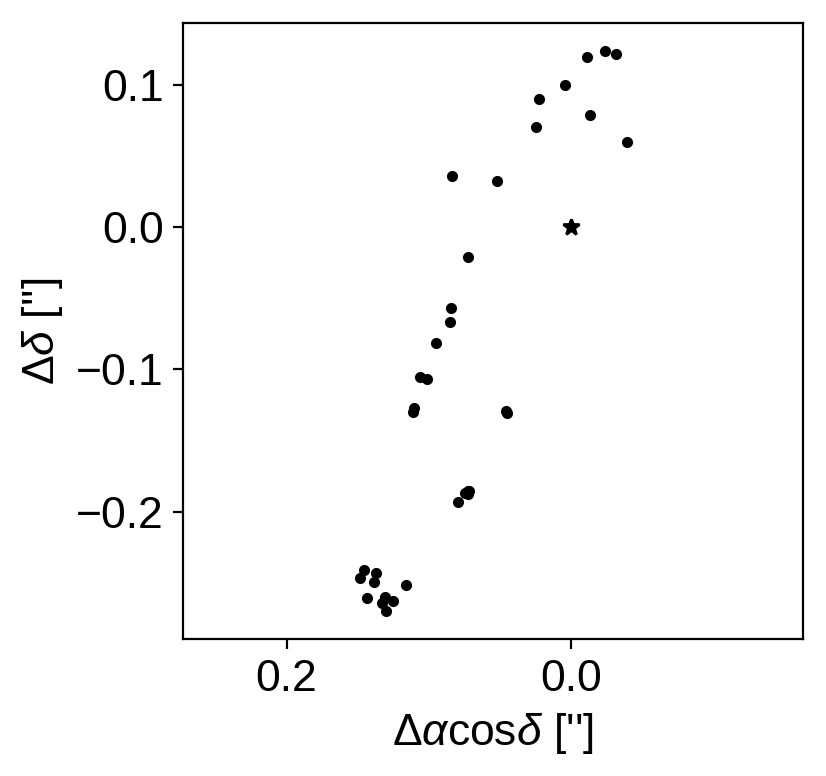

In [5]:
import matplotlib.pyplot as plt

# Make a plot of the astrometric data on the sky
# The convention is that North is up and East is left
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))

xs = rho_data * np.cos(theta_data) # X is north
ys = rho_data * np.sin(theta_data) # Y is east
ax.plot(ys, xs, ".k")
ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0,0, "k*")
ax.set_aspect("equal", "datalim")

The plot on the sky is helpful to look at, but the "raw" measurements are the values of $\rho$ (separation) and $\theta$ (also called P.A., position angle) that we listed in our data table, and that the measurement uncertainties live on these values as nice Gaussians. So, to visualize this space more clearly, we can plot $\rho$ vs. time and P.A. vs. time.

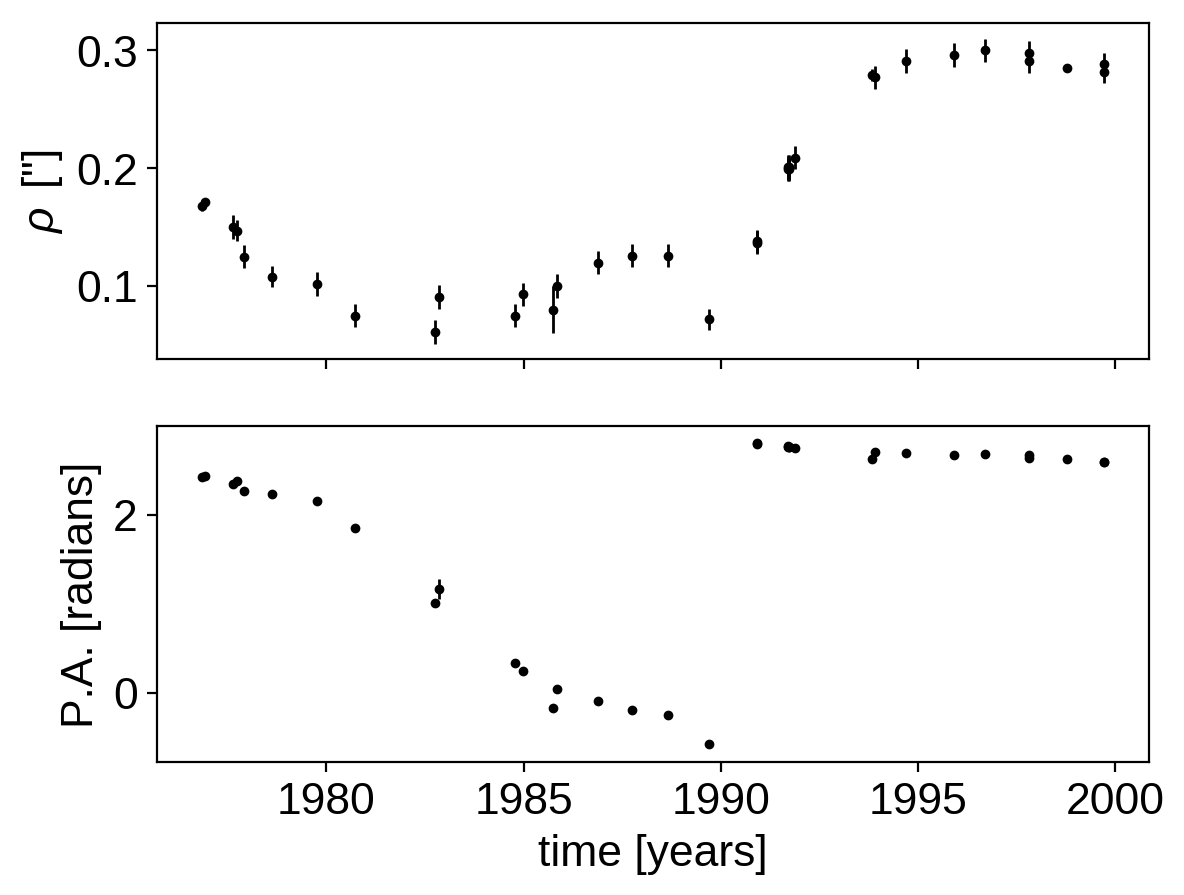

In [6]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].errorbar(astro_yrs, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].errorbar(astro_yrs, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].set_ylabel(r'P.A. [radians]')
ax[1].set_xlabel("time [years]");

# Fitting the astrometric orbit with *exoplanet*

To get started, let's import the relative packages from *exoplanet*, plot up a preliminary orbit from the literature, and then sample to find the best parameters.

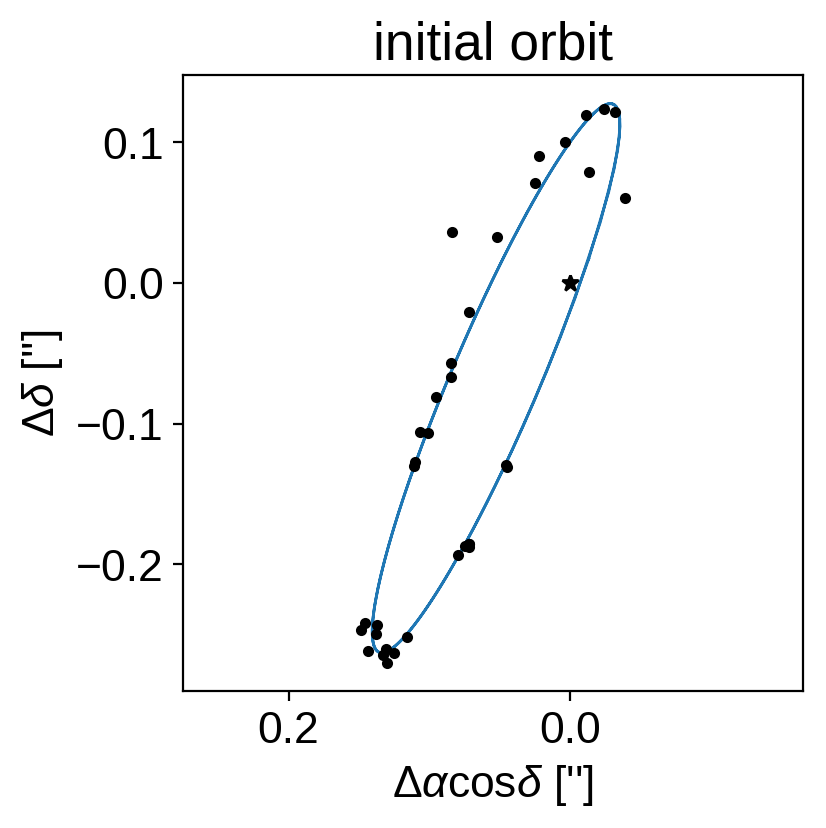

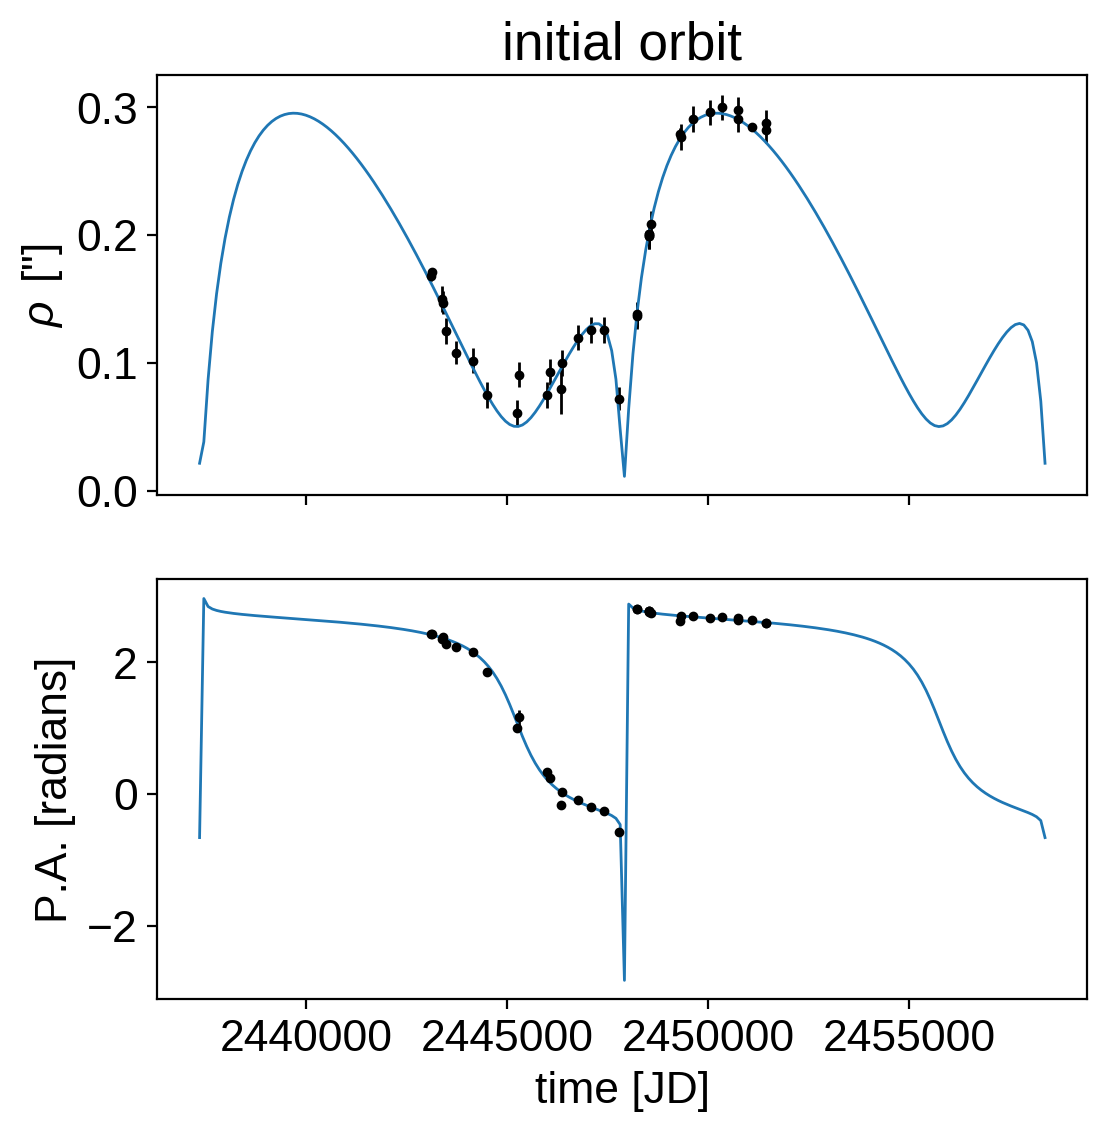

In [7]:
import pymc3 as pm 
import theano.tensor as tt

import exoplanet as xo
from exoplanet.distributions import Angle

from astropy import constants

# conversion constant from au to R_sun
au_to_R_sun = (constants.au / constants.R_sun).value

# Just to get started, let's take a look at the orbit using the best-fit parameters from Pourbaix et al. 1998

# Orbital elements from Pourbaix et al. 1998
# For the relative astrometric fit, we only need the following parameters
a_ang = 0.324  # arcsec
parallax = 1  # arcsec (meaningless choice for now)
a = a_ang * au_to_R_sun / parallax
e = 0.798
i = 96.0 * deg  # [rad]
omega = 251.6 * deg - np.pi  # Pourbaix reports omega_2, but we want omega_1
Omega = 159.6 * deg 
P = 28.8 * 365.25 # days

T0 = Time(1989.92, format="decimalyear")
T0.format = "jd"
T0 = T0.value  # [Julian Date]

# instantiate the orbit
orbit = xo.orbits.KeplerianOrbit(
    a=a, t_periastron=T0, period=P, incl=i, ecc=e,
    omega=omega, Omega=Omega)

# The position functions take an optional argument parallax to convert from
# physical units back to arcseconds
t = np.linspace(T0 - P, T0 + P, num=200) # days
rho, theta = theano.function([], orbit.get_relative_angles(t, parallax))()

# Plot the orbit 
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))

xs = rho * np.cos(theta) # X is north
ys = rho * np.sin(theta) # Y is east
ax.plot(ys, xs, color="C0", lw=1)

# plot the data
xs = rho_data * np.cos(theta_data) # X is north
ys = rho_data * np.sin(theta_data) # Y is east
ax.plot(ys, xs, ".k")

ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("initial orbit");

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax[0].errorbar(astro_jds, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].plot(t, rho, color="C0", lw=1)
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[0].set_title("initial orbit");

ax[1].errorbar(astro_jds, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].plot(t, theta, color="C0", lw=1)
ax[1].set_ylabel(r'P.A. [radians]')
ax[1].set_xlabel("time [JD]");

Now that we have an initial orbit, we can set the model up using PyMC3 to do inference.

In [8]:
yr = 365.25

# for predicted orbits
t_fine = np.linspace(astro_jds.min() - 500, astro_jds.max() + 500, num=1000)

def get_model(parallax=None):
    with pm.Model() as model:

        if parallax is None:
            # Without an actual parallax measurement, we can model the orbit in units of arcseconds
            # by providing a fake_parallax and conversion constant
            plx = 1  # arcsec 
        else:
            # Below we will run a version of this model where a measurement of parallax is provided
            # The measurement is in milliarcsec
            m_plx = pm.Bound(pm.Normal, lower=0, upper=100)("m_plx", mu=parallax[0], sd=parallax[1], testval=parallax[0])
            plx = pm.Deterministic("plx", 1e-3 * m_plx)
            
        a_ang = pm.Uniform("a_ang", 0.1, 1.0, testval=0.324)
        a = pm.Deterministic("a", a_ang / plx)

        # We expect the period to be somewhere in the range of 25 years, 
        # so we'll set a broad prior on logP
        logP = pm.Normal("logP", mu=np.log(25*yr), sd=10.0, testval=np.log(28.8*yr))
        P = pm.Deterministic("P", tt.exp(logP))

        # For astrometric-only fits, it's generally better to fit in
        # p = Omega + omega and m = Omega - omega instead of omega and Omega
        # directly
        omega0 = 251.6 * deg - np.pi
        Omega0 = 159.6 * deg
        p = Angle("p", testval=Omega0 + omega0)
        m = Angle("m", testval=Omega0 - omega0)
        omega = pm.Deterministic("omega", 0.5*(p - m))
        Omega = pm.Deterministic("Omega", 0.5*(p + m))

        # For these orbits, it can also be better to fit for a phase angle
        # (relative to a reference time) instead of the time of periasteron
        # passage directly
        phase = Angle("phase", testval=0.0)
        tperi = pm.Deterministic("tperi", T0 + P * phase / (2*np.pi))

        # Geometric uiform prior on cos(incl)
        cos_incl = pm.Uniform("cos_incl", lower=-1, upper=1, testval=np.cos(96.0 * deg))
        incl = pm.Deterministic("incl", tt.arccos(cos_incl))
        ecc = pm.Uniform("ecc", lower=0.0, upper=1.0, testval=0.798)

        # Set up the orbit
        orbit = xo.orbits.KeplerianOrbit(
            a=a * au_to_R_sun, t_periastron=tperi, period=P, 
            incl=incl, ecc=ecc, omega=omega, Omega=Omega)
        if parallax is not None:
            pm.Deterministic("M_tot", orbit.m_total)

        # Compute the model in rho and theta
        rho_model, theta_model = orbit.get_relative_angles(astro_jds, plx)
        pm.Deterministic("rho_model", rho_model)
        pm.Deterministic("theta_model", theta_model)

        # Add jitter terms to both separation and position angle
        log_rho_s = pm.Normal("log_rho_s", mu=np.log(np.median(rho_err)), sd=5.0)
        log_theta_s = pm.Normal("log_theta_s", mu=np.log(np.median(theta_err)), sd=5.0)
        rho_tot_err = tt.sqrt(rho_err**2 + tt.exp(2*log_rho_s))
        theta_tot_err = tt.sqrt(theta_err**2 + tt.exp(2*log_theta_s))

        # define the likelihood function, e.g., a Gaussian on both rho and theta
        pm.Normal("rho_obs", mu=rho_model, sd=rho_tot_err, observed=rho_data)

        # We want to be cognizant of the fact that theta wraps so the following is equivalent to 
        # pm.Normal("obs_theta", mu=theta_model, observed=theta_data, sd=theta_tot_err)
        # but takes into account the wrapping. Thanks to Rob de Rosa for the tip.
        theta_diff = tt.arctan2(tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data))
        pm.Normal("theta_obs", mu=theta_diff, sd=theta_tot_err, observed=0.0)

        # Set up predicted orbits for later plotting 
        rho_dense, theta_dense = orbit.get_relative_angles(t_fine, plx)
        rho_save = pm.Deterministic("rho_save", rho_dense)
        theta_save = pm.Deterministic("theta_save", theta_dense)

        # Optimize to find the initial parameters
        map_soln = model.test_point
        map_soln = xo.optimize(map_soln, vars=[log_rho_s, log_theta_s])
        map_soln = xo.optimize(map_soln, vars=[phase])
        map_soln = xo.optimize(map_soln, vars=[p, m, ecc])
        map_soln = xo.optimize(map_soln, vars=[logP, a_ang, phase])
        map_soln = xo.optimize(map_soln)
    
    return model, map_soln

model, map_soln = get_model()

optimizing logp for variables: ['log_theta_s', 'log_rho_s']


message: Optimization terminated successfully.
logp: 104.85554109314326 -> 147.14399186006236


optimizing logp for variables: ['phase_angle__']


message: Optimization terminated successfully.
logp: 147.14399186006236 -> 167.6422059819834


optimizing logp for variables: ['ecc_interval__', 'm_angle__', 'p_angle__']


message: Optimization terminated successfully.
logp: 167.64220598198335 -> 210.06340668298836


optimizing logp for variables: ['phase_angle__', 'a_ang_interval__', 'logP']


message: Optimization terminated successfully.
logp: 210.0634066829884 -> 210.50136991122002


optimizing logp for variables: ['log_theta_s', 'log_rho_s', 'ecc_interval__', 'cos_incl_interval__', 'phase_angle__', 'm_angle__', 'p_angle__', 'logP', 'a_ang_interval__']


message: Optimization terminated successfully.
logp: 210.50136991122002 -> 215.02117742210876


Now that we have a maximum a posteriori estimate of the parameters, let's take a look at the results to make sure that they seem reasonable.

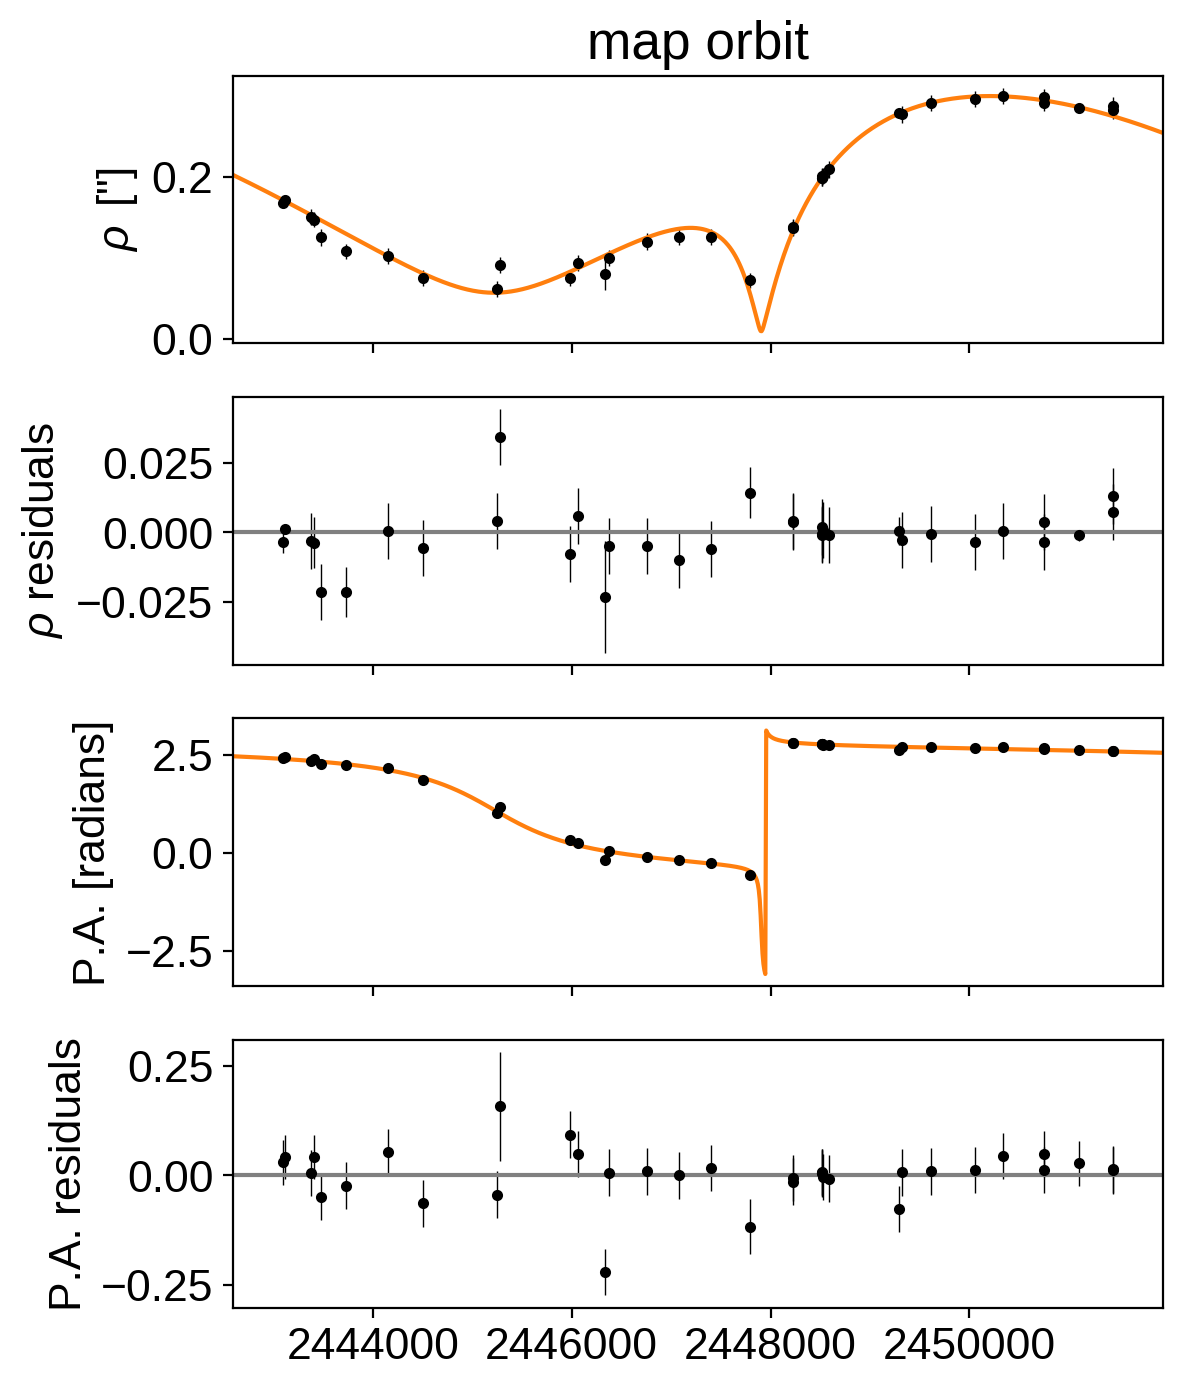

In [9]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6,8))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r'$\rho$ residuals')
ax[2].set_ylabel(r'P.A. [radians]')
ax[3].set_ylabel(r'P.A. residuals')

tot_rho_err = np.sqrt(rho_err**2 + np.exp(2 * map_soln["log_rho_s"]))
tot_theta_err = np.sqrt(theta_err**2 + np.exp(2 * map_soln["log_theta_s"]))

ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
ax[0].plot(t_fine, map_soln["rho_save"], "C1")

ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(astro_jds, rho_data - map_soln["rho_model"], yerr=tot_rho_err, **ekw)


ax[2].plot(t_fine, map_soln["theta_save"], "C1")
ax[2].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)

ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(astro_jds, theta_data - map_soln["theta_model"], yerr=tot_theta_err, **ekw) 

ax[3].set_xlim(t_fine[0], t_fine[-1])
ax[0].set_title("map orbit");

Now let's sample the posterior.

In [10]:
np.random.seed(1234)
sampler = xo.PyMC3Sampler(start=200, window=100, finish=500)
with model:
    burnin = sampler.tune(tune=4500, start=map_soln,
                          step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=4000)

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 15/808 [00:00<00:05, 149.97draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:00<00:09, 87.11draws/s] 

Sampling 4 chains:   4%|▎         | 29/808 [00:00<00:10, 74.11draws/s]

Sampling 4 chains:   4%|▍         | 36/808 [00:00<00:10, 71.00draws/s]

Sampling 4 chains:   5%|▌         | 42/808 [00:00<00:11, 64.98draws/s]

Sampling 4 chains:   6%|▌         | 48/808 [00:00<00:13, 56.34draws/s]

Sampling 4 chains:   7%|▋         | 56/808 [00:00<00:12, 60.95draws/s]

Sampling 4 chains:   8%|▊         | 62/808 [00:00<00:12, 57.43draws/s]

Sampling 4 chains:   8%|▊         | 68/808 [00:01<00:12, 57.57draws/s]

Sampling 4 chains:   9%|▉         | 74/808 [00:01<00:12, 57.19draws/s]

Sampling 4 chains:  10%|█         | 81/808 [00:01<00:12, 58.25draws/s]

Sampling 4 chains:  11%|█         | 87/808 [00:01<00:12, 56.12draws/s]

Sampling 4 chains:  12%|█▏        | 96/808 [00:01<00:12, 57.73draws/s]

Sampling 4 chains:  13%|█▎        | 104/808 [00:01<00:12, 57.23draws/s]

Sampling 4 chains:  14%|█▍        | 112/808 [00:01<00:11, 60.93draws/s]

Sampling 4 chains:  15%|█▍        | 119/808 [00:01<00:11, 59.31draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:02<00:12, 56.56draws/s]

Sampling 4 chains:  16%|█▋        | 132/808 [00:02<00:11, 59.77draws/s]

Sampling 4 chains:  17%|█▋        | 139/808 [00:02<00:11, 60.81draws/s]

Sampling 4 chains:  18%|█▊        | 147/808 [00:02<00:10, 64.68draws/s]

Sampling 4 chains:  19%|█▉        | 154/808 [00:02<00:10, 64.01draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:02<00:09, 65.23draws/s]

Sampling 4 chains:  21%|██        | 168/808 [00:02<00:09, 64.69draws/s]

Sampling 4 chains:  22%|██▏       | 175/808 [00:02<00:09, 64.82draws/s]

Sampling 4 chains:  23%|██▎       | 182/808 [00:02<00:09, 64.42draws/s]

Sampling 4 chains:  24%|██▎       | 190/808 [00:03<00:09, 64.77draws/s]

Sampling 4 chains:  24%|██▍       | 197/808 [00:03<00:09, 65.06draws/s]

Sampling 4 chains:  25%|██▌       | 205/808 [00:03<00:08, 67.08draws/s]

Sampling 4 chains:  26%|██▌       | 212/808 [00:03<00:09, 65.92draws/s]

Sampling 4 chains:  27%|██▋       | 220/808 [00:03<00:08, 66.01draws/s]

Sampling 4 chains:  28%|██▊       | 227/808 [00:03<00:09, 64.21draws/s]

Sampling 4 chains:  29%|██▉       | 234/808 [00:03<00:09, 59.93draws/s]

Sampling 4 chains:  30%|██▉       | 242/808 [00:03<00:08, 63.69draws/s]

Sampling 4 chains:  31%|███       | 249/808 [00:03<00:08, 62.42draws/s]

Sampling 4 chains:  32%|███▏      | 258/808 [00:04<00:08, 64.28draws/s]

Sampling 4 chains:  33%|███▎      | 265/808 [00:04<00:08, 62.83draws/s]

Sampling 4 chains:  34%|███▎      | 272/808 [00:04<00:08, 61.59draws/s]

Sampling 4 chains:  35%|███▍      | 280/808 [00:04<00:08, 65.04draws/s]

Sampling 4 chains:  36%|███▌      | 287/808 [00:04<00:08, 61.66draws/s]

Sampling 4 chains:  36%|███▋      | 294/808 [00:04<00:08, 60.27draws/s]

Sampling 4 chains:  37%|███▋      | 301/808 [00:04<00:08, 62.43draws/s]

Sampling 4 chains:  38%|███▊      | 308/808 [00:04<00:08, 62.50draws/s]

Sampling 4 chains:  39%|███▉      | 315/808 [00:05<00:08, 58.09draws/s]

Sampling 4 chains:  40%|███▉      | 323/808 [00:05<00:08, 57.35draws/s]

Sampling 4 chains:  41%|████      | 332/808 [00:05<00:07, 63.28draws/s]

Sampling 4 chains:  42%|████▏     | 339/808 [00:05<00:07, 60.54draws/s]

Sampling 4 chains:  43%|████▎     | 346/808 [00:05<00:07, 62.25draws/s]

Sampling 4 chains:  44%|████▎     | 353/808 [00:05<00:07, 63.08draws/s]

Sampling 4 chains:  45%|████▍     | 360/808 [00:05<00:07, 60.04draws/s]

Sampling 4 chains:  45%|████▌     | 367/808 [00:05<00:07, 61.52draws/s]

Sampling 4 chains:  46%|████▋     | 375/808 [00:05<00:06, 62.52draws/s]

Sampling 4 chains:  47%|████▋     | 382/808 [00:06<00:06, 63.36draws/s]

Sampling 4 chains:  48%|████▊     | 389/808 [00:06<00:07, 59.32draws/s]

Sampling 4 chains:  49%|████▉     | 397/808 [00:06<00:07, 58.66draws/s]

Sampling 4 chains:  50%|█████     | 406/808 [00:06<00:06, 58.61draws/s]

Sampling 4 chains:  51%|█████▏    | 415/808 [00:06<00:06, 61.14draws/s]

Sampling 4 chains:  52%|█████▏    | 423/808 [00:06<00:05, 64.76draws/s]

Sampling 4 chains:  53%|█████▎    | 430/808 [00:06<00:06, 61.80draws/s]

Sampling 4 chains:  55%|█████▍    | 441/808 [00:07<00:05, 65.11draws/s]

Sampling 4 chains:  56%|█████▌    | 450/808 [00:07<00:05, 64.53draws/s]

Sampling 4 chains:  57%|█████▋    | 458/808 [00:07<00:05, 61.79draws/s]

Sampling 4 chains:  58%|█████▊    | 468/808 [00:07<00:05, 66.13draws/s]

Sampling 4 chains:  59%|█████▉    | 475/808 [00:07<00:05, 65.89draws/s]

Sampling 4 chains:  60%|█████▉    | 482/808 [00:07<00:05, 60.08draws/s]

Sampling 4 chains:  61%|██████    | 489/808 [00:07<00:05, 58.02draws/s]

Sampling 4 chains:  62%|██████▏   | 497/808 [00:07<00:05, 60.43draws/s]

Sampling 4 chains:  62%|██████▏   | 504/808 [00:08<00:05, 60.73draws/s]

Sampling 4 chains:  63%|██████▎   | 511/808 [00:08<00:05, 58.03draws/s]

Sampling 4 chains:  64%|██████▍   | 518/808 [00:08<00:04, 59.85draws/s]

Sampling 4 chains:  65%|██████▍   | 525/808 [00:08<00:04, 60.24draws/s]

Sampling 4 chains:  66%|██████▌   | 532/808 [00:08<00:04, 61.52draws/s]

Sampling 4 chains:  67%|██████▋   | 539/808 [00:08<00:04, 61.60draws/s]

Sampling 4 chains:  68%|██████▊   | 547/808 [00:08<00:03, 65.27draws/s]

Sampling 4 chains:  69%|██████▊   | 554/808 [00:08<00:03, 64.52draws/s]

Sampling 4 chains:  69%|██████▉   | 561/808 [00:08<00:03, 65.18draws/s]

Sampling 4 chains:  70%|███████   | 568/808 [00:09<00:03, 66.38draws/s]

Sampling 4 chains:  71%|███████   | 575/808 [00:09<00:03, 66.08draws/s]

Sampling 4 chains:  72%|███████▏  | 582/808 [00:09<00:03, 65.10draws/s]

Sampling 4 chains:  73%|███████▎  | 590/808 [00:09<00:03, 62.90draws/s]

Sampling 4 chains:  74%|███████▍  | 598/808 [00:09<00:03, 65.98draws/s]

Sampling 4 chains:  75%|███████▍  | 605/808 [00:09<00:03, 65.88draws/s]

Sampling 4 chains:  76%|███████▌  | 612/808 [00:09<00:03, 62.33draws/s]

Sampling 4 chains:  77%|███████▋  | 619/808 [00:09<00:03, 60.49draws/s]

Sampling 4 chains:  78%|███████▊  | 627/808 [00:10<00:03, 59.30draws/s]

Sampling 4 chains:  79%|███████▊  | 635/808 [00:10<00:02, 63.24draws/s]

Sampling 4 chains:  80%|███████▉  | 643/808 [00:10<00:02, 64.94draws/s]

Sampling 4 chains:  80%|████████  | 650/808 [00:10<00:02, 60.11draws/s]

Sampling 4 chains:  82%|████████▏ | 659/808 [00:10<00:02, 62.14draws/s]

Sampling 4 chains:  82%|████████▏ | 666/808 [00:10<00:02, 61.68draws/s]

Sampling 4 chains:  83%|████████▎ | 673/808 [00:10<00:02, 62.04draws/s]

Sampling 4 chains:  84%|████████▍ | 680/808 [00:10<00:02, 61.23draws/s]

Sampling 4 chains:  85%|████████▌ | 688/808 [00:10<00:01, 63.61draws/s]

Sampling 4 chains:  86%|████████▋ | 697/808 [00:11<00:01, 64.88draws/s]

Sampling 4 chains:  87%|████████▋ | 704/808 [00:11<00:01, 66.14draws/s]

Sampling 4 chains:  88%|████████▊ | 711/808 [00:11<00:01, 59.72draws/s]

Sampling 4 chains:  89%|████████▉ | 718/808 [00:11<00:01, 59.84draws/s]

Sampling 4 chains:  90%|████████▉ | 725/808 [00:11<00:01, 56.79draws/s]

Sampling 4 chains:  91%|█████████ | 732/808 [00:11<00:01, 57.45draws/s]

Sampling 4 chains:  92%|█████████▏| 740/808 [00:11<00:01, 56.51draws/s]

Sampling 4 chains:  93%|█████████▎| 748/808 [00:11<00:00, 60.82draws/s]

Sampling 4 chains:  93%|█████████▎| 755/808 [00:12<00:00, 58.25draws/s]

Sampling 4 chains:  94%|█████████▍| 762/808 [00:12<00:00, 60.19draws/s]

Sampling 4 chains:  95%|█████████▌| 769/808 [00:12<00:00, 58.06draws/s]

Sampling 4 chains:  96%|█████████▌| 777/808 [00:12<00:00, 60.63draws/s]

Sampling 4 chains:  97%|█████████▋| 784/808 [00:12<00:00, 61.73draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [00:12<00:00, 61.26draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [00:12<00:00, 57.19draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [00:13<00:00, 40.40draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:13<00:00, 60.33draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 13/408 [00:00<00:03, 126.42draws/s]

Sampling 4 chains:   5%|▌         | 22/408 [00:00<00:04, 94.87draws/s] 

Sampling 4 chains:   8%|▊         | 31/408 [00:00<00:04, 87.40draws/s]

Sampling 4 chains:  10%|▉         | 39/408 [00:00<00:04, 84.97draws/s]

Sampling 4 chains:  12%|█▏        | 49/408 [00:00<00:04, 86.70draws/s]

Sampling 4 chains:  14%|█▍        | 57/408 [00:00<00:04, 81.63draws/s]

Sampling 4 chains:  16%|█▋        | 67/408 [00:00<00:04, 76.07draws/s]

Sampling 4 chains:  19%|█▉        | 77/408 [00:00<00:04, 81.19draws/s]

Sampling 4 chains:  21%|██        | 86/408 [00:01<00:03, 83.40draws/s]

Sampling 4 chains:  23%|██▎       | 95/408 [00:01<00:03, 79.12draws/s]

Sampling 4 chains:  26%|██▌       | 106/408 [00:01<00:03, 83.80draws/s]

Sampling 4 chains:  28%|██▊       | 115/408 [00:01<00:03, 85.42draws/s]

Sampling 4 chains:  30%|███       | 124/408 [00:01<00:03, 84.58draws/s]

Sampling 4 chains:  33%|███▎      | 133/408 [00:01<00:03, 82.57draws/s]

Sampling 4 chains:  36%|███▌      | 145/408 [00:01<00:03, 85.52draws/s]

Sampling 4 chains:  38%|███▊      | 154/408 [00:01<00:02, 86.45draws/s]

Sampling 4 chains:  41%|████      | 167/408 [00:01<00:02, 89.72draws/s]

Sampling 4 chains:  43%|████▎     | 177/408 [00:02<00:02, 81.84draws/s]

Sampling 4 chains:  46%|████▌     | 186/408 [00:02<00:02, 81.11draws/s]

Sampling 4 chains:  48%|████▊     | 196/408 [00:02<00:02, 85.73draws/s]

Sampling 4 chains:  50%|█████     | 205/408 [00:02<00:02, 78.72draws/s]

Sampling 4 chains:  52%|█████▏    | 214/408 [00:02<00:02, 76.55draws/s]

Sampling 4 chains:  55%|█████▌    | 225/408 [00:02<00:02, 82.60draws/s]

Sampling 4 chains:  58%|█████▊    | 236/408 [00:02<00:02, 82.62draws/s]

Sampling 4 chains:  60%|██████    | 245/408 [00:02<00:01, 81.94draws/s]

Sampling 4 chains:  62%|██████▏   | 254/408 [00:03<00:01, 82.77draws/s]

Sampling 4 chains:  64%|██████▍   | 263/408 [00:03<00:01, 80.08draws/s]

Sampling 4 chains:  67%|██████▋   | 274/408 [00:03<00:01, 80.57draws/s]

Sampling 4 chains:  70%|██████▉   | 284/408 [00:03<00:01, 85.23draws/s]

Sampling 4 chains:  72%|███████▏  | 293/408 [00:03<00:01, 79.00draws/s]

Sampling 4 chains:  74%|███████▍  | 302/408 [00:03<00:01, 79.36draws/s]

Sampling 4 chains:  76%|███████▌  | 311/408 [00:03<00:01, 80.37draws/s]

Sampling 4 chains:  79%|███████▉  | 324/408 [00:03<00:00, 86.63draws/s]

Sampling 4 chains:  82%|████████▏ | 333/408 [00:04<00:00, 82.06draws/s]

Sampling 4 chains:  84%|████████▍ | 342/408 [00:04<00:00, 83.23draws/s]

Sampling 4 chains:  87%|████████▋ | 355/408 [00:04<00:00, 88.53draws/s]

Sampling 4 chains:  90%|█████████ | 368/408 [00:04<00:00, 96.93draws/s]

Sampling 4 chains:  93%|█████████▎| 379/408 [00:04<00:00, 87.25draws/s]

Sampling 4 chains:  95%|█████████▌| 389/408 [00:04<00:00, 84.26draws/s]

Sampling 4 chains:  98%|█████████▊| 398/408 [00:04<00:00, 71.70draws/s]

Sampling 4 chains: 100%|█████████▉| 406/408 [00:05<00:00, 58.79draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:05<00:00, 80.26draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:00<00:01, 447.79draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:00<00:02, 349.83draws/s]

Sampling 4 chains:  11%|█         | 89/808 [00:00<00:02, 281.28draws/s]

Sampling 4 chains:  14%|█▍        | 112/808 [00:00<00:02, 258.19draws/s]

Sampling 4 chains:  17%|█▋        | 141/808 [00:00<00:02, 266.84draws/s]

Sampling 4 chains:  22%|██▏       | 174/808 [00:00<00:02, 279.37draws/s]

Sampling 4 chains:  25%|██▌       | 205/808 [00:00<00:02, 287.90draws/s]

Sampling 4 chains:  31%|███       | 249/808 [00:00<00:01, 319.31draws/s]

Sampling 4 chains:  37%|███▋      | 296/808 [00:00<00:01, 352.27draws/s]

Sampling 4 chains:  43%|████▎     | 346/808 [00:01<00:01, 386.01draws/s]

Sampling 4 chains:  48%|████▊     | 387/808 [00:01<00:01, 361.40draws/s]

Sampling 4 chains:  54%|█████▍    | 435/808 [00:01<00:00, 389.76draws/s]

Sampling 4 chains:  59%|█████▉    | 476/808 [00:01<00:00, 394.43draws/s]

Sampling 4 chains:  65%|██████▍   | 524/808 [00:01<00:00, 415.04draws/s]

Sampling 4 chains:  71%|███████▏  | 576/808 [00:01<00:00, 440.27draws/s]

Sampling 4 chains:  77%|███████▋  | 623/808 [00:01<00:00, 447.67draws/s]

Sampling 4 chains:  83%|████████▎ | 673/808 [00:01<00:00, 461.11draws/s]

Sampling 4 chains:  89%|████████▉ | 720/808 [00:01<00:00, 439.02draws/s]

Sampling 4 chains:  95%|█████████▍| 765/808 [00:02<00:00, 367.13draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [00:02<00:00, 237.69draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:02<00:00, 336.57draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 36/1608 [00:00<00:04, 356.08draws/s]

Sampling 4 chains:   5%|▍         | 74/1608 [00:00<00:04, 358.66draws/s]

Sampling 4 chains:   7%|▋         | 120/1608 [00:00<00:03, 377.13draws/s]

Sampling 4 chains:   9%|▉         | 146/1608 [00:00<00:04, 315.30draws/s]

Sampling 4 chains:  12%|█▏        | 192/1608 [00:00<00:04, 348.12draws/s]

Sampling 4 chains:  15%|█▍        | 238/1608 [00:00<00:03, 374.39draws/s]

Sampling 4 chains:  17%|█▋        | 278/1608 [00:00<00:03, 378.76draws/s]

Sampling 4 chains:  20%|█▉        | 315/1608 [00:00<00:03, 367.52draws/s]

Sampling 4 chains:  22%|██▏       | 356/1608 [00:00<00:03, 378.36draws/s]

Sampling 4 chains:  25%|██▍       | 394/1608 [00:01<00:03, 367.35draws/s]

Sampling 4 chains:  27%|██▋       | 439/1608 [00:01<00:03, 386.89draws/s]

Sampling 4 chains:  30%|██▉       | 482/1608 [00:01<00:02, 394.03draws/s]

Sampling 4 chains:  33%|███▎      | 532/1608 [00:01<00:02, 419.81draws/s]

Sampling 4 chains:  36%|███▌      | 580/1608 [00:01<00:02, 435.43draws/s]

Sampling 4 chains:  39%|███▉      | 630/1608 [00:01<00:02, 450.86draws/s]

Sampling 4 chains:  42%|████▏     | 676/1608 [00:01<00:02, 448.43draws/s]

Sampling 4 chains:  45%|████▌     | 725/1608 [00:01<00:01, 457.91draws/s]

Sampling 4 chains:  48%|████▊     | 778/1608 [00:01<00:01, 473.91draws/s]

Sampling 4 chains:  51%|█████▏    | 827/1608 [00:01<00:01, 476.58draws/s]

Sampling 4 chains:  55%|█████▍    | 881/1608 [00:02<00:01, 493.94draws/s]

Sampling 4 chains:  58%|█████▊    | 937/1608 [00:02<00:01, 511.26draws/s]

Sampling 4 chains:  62%|██████▏   | 989/1608 [00:02<00:01, 513.07draws/s]

Sampling 4 chains:  65%|██████▍   | 1043/1608 [00:02<00:01, 519.09draws/s]

Sampling 4 chains:  68%|██████▊   | 1096/1608 [00:02<00:01, 487.87draws/s]

Sampling 4 chains:  71%|███████▏  | 1146/1608 [00:02<00:00, 490.06draws/s]

Sampling 4 chains:  74%|███████▍  | 1197/1608 [00:02<00:00, 489.41draws/s]

Sampling 4 chains:  78%|███████▊  | 1251/1608 [00:02<00:00, 503.37draws/s]

Sampling 4 chains:  81%|████████  | 1302/1608 [00:02<00:00, 486.56draws/s]

Sampling 4 chains:  85%|████████▍ | 1362/1608 [00:03<00:00, 511.46draws/s]

Sampling 4 chains:  88%|████████▊ | 1422/1608 [00:03<00:00, 531.14draws/s]

Sampling 4 chains:  92%|█████████▏| 1478/1608 [00:03<00:00, 538.77draws/s]

Sampling 4 chains:  95%|█████████▌| 1533/1608 [00:03<00:00, 395.87draws/s]

Sampling 4 chains:  98%|█████████▊| 1579/1608 [00:03<00:00, 373.39draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [00:03<00:00, 420.77draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|▏         | 46/3208 [00:00<00:07, 436.82draws/s]

Sampling 4 chains:   2%|▏         | 73/3208 [00:00<00:08, 364.22draws/s]

Sampling 4 chains:   3%|▎         | 106/3208 [00:00<00:08, 347.85draws/s]

Sampling 4 chains:   4%|▍         | 143/3208 [00:00<00:08, 352.85draws/s]

Sampling 4 chains:   6%|▌         | 178/3208 [00:00<00:08, 347.96draws/s]

Sampling 4 chains:   7%|▋         | 225/3208 [00:00<00:07, 376.46draws/s]

Sampling 4 chains:   8%|▊         | 269/3208 [00:00<00:07, 390.19draws/s]

Sampling 4 chains:  10%|▉         | 306/3208 [00:00<00:07, 382.86draws/s]

Sampling 4 chains:  11%|█         | 351/3208 [00:00<00:07, 400.32draws/s]

Sampling 4 chains:  12%|█▏        | 392/3208 [00:01<00:07, 401.05draws/s]

Sampling 4 chains:  14%|█▍        | 442/3208 [00:01<00:06, 425.92draws/s]

Sampling 4 chains:  15%|█▌        | 485/3208 [00:01<00:06, 408.45draws/s]

Sampling 4 chains:  16%|█▋        | 528/3208 [00:01<00:06, 412.60draws/s]

Sampling 4 chains:  18%|█▊        | 588/3208 [00:01<00:05, 451.44draws/s]

Sampling 4 chains:  20%|█▉        | 635/3208 [00:01<00:05, 442.21draws/s]

Sampling 4 chains:  21%|██        | 681/3208 [00:01<00:05, 446.22draws/s]

Sampling 4 chains:  23%|██▎       | 731/3208 [00:01<00:05, 459.19draws/s]

Sampling 4 chains:  24%|██▍       | 778/3208 [00:01<00:05, 459.07draws/s]

Sampling 4 chains:  26%|██▌       | 831/3208 [00:01<00:04, 477.32draws/s]

Sampling 4 chains:  27%|██▋       | 880/3208 [00:02<00:04, 477.02draws/s]

Sampling 4 chains:  29%|██▉       | 929/3208 [00:02<00:04, 477.82draws/s]

Sampling 4 chains:  31%|███       | 980/3208 [00:02<00:04, 485.95draws/s]

Sampling 4 chains:  32%|███▏      | 1030/3208 [00:02<00:04, 488.56draws/s]

Sampling 4 chains:  34%|███▍      | 1091/3208 [00:02<00:04, 515.26draws/s]

Sampling 4 chains:  36%|███▌      | 1151/3208 [00:02<00:03, 537.89draws/s]

Sampling 4 chains:  38%|███▊      | 1209/3208 [00:02<00:03, 548.62draws/s]

Sampling 4 chains:  39%|███▉      | 1265/3208 [00:02<00:03, 532.23draws/s]

Sampling 4 chains:  41%|████▏     | 1324/3208 [00:02<00:03, 547.86draws/s]

Sampling 4 chains:  43%|████▎     | 1380/3208 [00:03<00:03, 530.99draws/s]

Sampling 4 chains:  45%|████▍     | 1434/3208 [00:03<00:03, 501.55draws/s]

Sampling 4 chains:  47%|████▋     | 1496/3208 [00:03<00:03, 531.60draws/s]

Sampling 4 chains:  48%|████▊     | 1555/3208 [00:03<00:03, 547.37draws/s]

Sampling 4 chains:  50%|█████     | 1617/3208 [00:03<00:02, 565.18draws/s]

Sampling 4 chains:  52%|█████▏    | 1675/3208 [00:03<00:02, 541.80draws/s]

Sampling 4 chains:  54%|█████▍    | 1730/3208 [00:03<00:02, 539.49draws/s]

Sampling 4 chains:  56%|█████▌    | 1793/3208 [00:03<00:02, 561.96draws/s]

Sampling 4 chains:  58%|█████▊    | 1850/3208 [00:03<00:02, 548.61draws/s]

Sampling 4 chains:  59%|█████▉    | 1906/3208 [00:03<00:02, 540.60draws/s]

Sampling 4 chains:  61%|██████▏   | 1968/3208 [00:04<00:02, 559.44draws/s]

Sampling 4 chains:  63%|██████▎   | 2025/3208 [00:04<00:02, 527.83draws/s]

Sampling 4 chains:  65%|██████▍   | 2079/3208 [00:04<00:02, 522.21draws/s]

Sampling 4 chains:  66%|██████▋   | 2132/3208 [00:04<00:02, 517.99draws/s]

Sampling 4 chains:  68%|██████▊   | 2187/3208 [00:04<00:01, 524.44draws/s]

Sampling 4 chains:  70%|██████▉   | 2243/3208 [00:04<00:01, 532.46draws/s]

Sampling 4 chains:  72%|███████▏  | 2297/3208 [00:04<00:01, 528.88draws/s]

Sampling 4 chains:  73%|███████▎  | 2355/3208 [00:04<00:01, 543.17draws/s]

Sampling 4 chains:  75%|███████▌  | 2417/3208 [00:04<00:01, 562.62draws/s]

Sampling 4 chains:  77%|███████▋  | 2478/3208 [00:05<00:01, 574.31draws/s]

Sampling 4 chains:  79%|███████▉  | 2548/3208 [00:05<00:01, 605.35draws/s]

Sampling 4 chains:  81%|████████▏ | 2610/3208 [00:05<00:01, 570.17draws/s]

Sampling 4 chains:  83%|████████▎ | 2668/3208 [00:05<00:00, 571.72draws/s]

Sampling 4 chains:  85%|████████▍ | 2726/3208 [00:05<00:00, 556.92draws/s]

Sampling 4 chains:  87%|████████▋ | 2783/3208 [00:05<00:00, 548.16draws/s]

Sampling 4 chains:  89%|████████▊ | 2842/3208 [00:05<00:00, 558.69draws/s]

Sampling 4 chains:  90%|█████████ | 2901/3208 [00:05<00:00, 566.26draws/s]

Sampling 4 chains:  92%|█████████▏| 2958/3208 [00:05<00:00, 534.11draws/s]

Sampling 4 chains:  94%|█████████▍| 3012/3208 [00:06<00:00, 425.31draws/s]

Sampling 4 chains:  95%|█████████▌| 3059/3208 [00:06<00:00, 418.67draws/s]

Sampling 4 chains:  97%|█████████▋| 3104/3208 [00:06<00:00, 386.80draws/s]

Sampling 4 chains:  98%|█████████▊| 3146/3208 [00:06<00:00, 337.65draws/s]

Sampling 4 chains:  99%|█████████▉| 3183/3208 [00:06<00:00, 304.03draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [00:06<00:00, 469.60draws/s]

Sampling 4 chains:   0%|          | 0/11208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 33/11208 [00:00<00:34, 325.97draws/s]

Sampling 4 chains:   1%|          | 60/11208 [00:00<00:37, 298.29draws/s]

Sampling 4 chains:   1%|          | 91/11208 [00:00<00:37, 300.41draws/s]

Sampling 4 chains:   1%|          | 128/11208 [00:00<00:34, 317.57draws/s]

Sampling 4 chains:   2%|▏         | 172/11208 [00:00<00:31, 345.90draws/s]

Sampling 4 chains:   2%|▏         | 207/11208 [00:00<00:31, 345.21draws/s]

Sampling 4 chains:   2%|▏         | 240/11208 [00:00<00:32, 338.33draws/s]

Sampling 4 chains:   2%|▏         | 272/11208 [00:00<00:34, 317.53draws/s]

Sampling 4 chains:   3%|▎         | 317/11208 [00:00<00:31, 346.76draws/s]

Sampling 4 chains:   3%|▎         | 362/11208 [00:01<00:29, 367.95draws/s]

Sampling 4 chains:   4%|▎         | 413/11208 [00:01<00:27, 398.83draws/s]

Sampling 4 chains:   4%|▍         | 456/11208 [00:01<00:26, 405.63draws/s]

Sampling 4 chains:   5%|▍         | 505/11208 [00:01<00:25, 427.18draws/s]

Sampling 4 chains:   5%|▍         | 549/11208 [00:01<00:25, 422.80draws/s]

Sampling 4 chains:   5%|▌         | 615/11208 [00:01<00:22, 471.67draws/s]

Sampling 4 chains:   6%|▌         | 665/11208 [00:01<00:23, 450.36draws/s]

Sampling 4 chains:   6%|▋         | 712/11208 [00:01<00:23, 445.88draws/s]

Sampling 4 chains:   7%|▋         | 758/11208 [00:01<00:23, 447.42draws/s]

Sampling 4 chains:   7%|▋         | 804/11208 [00:01<00:23, 441.13draws/s]

Sampling 4 chains:   8%|▊         | 849/11208 [00:02<00:24, 418.92draws/s]

Sampling 4 chains:   8%|▊         | 894/11208 [00:02<00:24, 425.73draws/s]

Sampling 4 chains:   8%|▊         | 938/11208 [00:02<00:24, 427.30draws/s]

Sampling 4 chains:   9%|▉         | 996/11208 [00:02<00:22, 463.57draws/s]

Sampling 4 chains:   9%|▉         | 1053/11208 [00:02<00:20, 489.69draws/s]

Sampling 4 chains:  10%|▉         | 1104/11208 [00:02<00:20, 491.88draws/s]

Sampling 4 chains:  10%|█         | 1159/11208 [00:02<00:19, 507.09draws/s]

Sampling 4 chains:  11%|█         | 1211/11208 [00:02<00:20, 495.09draws/s]

Sampling 4 chains:  11%|█▏        | 1262/11208 [00:02<00:20, 494.09draws/s]

Sampling 4 chains:  12%|█▏        | 1313/11208 [00:03<00:19, 497.24draws/s]

Sampling 4 chains:  12%|█▏        | 1372/11208 [00:03<00:19, 515.53draws/s]

Sampling 4 chains:  13%|█▎        | 1424/11208 [00:03<00:19, 508.60draws/s]

Sampling 4 chains:  13%|█▎        | 1483/11208 [00:03<00:18, 530.21draws/s]

Sampling 4 chains:  14%|█▎        | 1537/11208 [00:03<00:18, 517.61draws/s]

Sampling 4 chains:  14%|█▍        | 1593/11208 [00:03<00:18, 529.02draws/s]

Sampling 4 chains:  15%|█▍        | 1652/11208 [00:03<00:17, 544.47draws/s]

Sampling 4 chains:  15%|█▌        | 1707/11208 [00:03<00:17, 534.66draws/s]

Sampling 4 chains:  16%|█▌        | 1762/11208 [00:03<00:17, 530.72draws/s]

Sampling 4 chains:  16%|█▌        | 1820/11208 [00:03<00:17, 542.56draws/s]

Sampling 4 chains:  17%|█▋        | 1878/11208 [00:04<00:16, 552.50draws/s]

Sampling 4 chains:  17%|█▋        | 1934/11208 [00:04<00:17, 519.50draws/s]

Sampling 4 chains:  18%|█▊        | 1987/11208 [00:04<00:18, 491.16draws/s]

Sampling 4 chains:  18%|█▊        | 2040/11208 [00:04<00:18, 501.93draws/s]

Sampling 4 chains:  19%|█▊        | 2091/11208 [00:04<00:19, 478.93draws/s]

Sampling 4 chains:  19%|█▉        | 2141/11208 [00:04<00:18, 484.99draws/s]

Sampling 4 chains:  20%|█▉        | 2193/11208 [00:04<00:18, 494.12draws/s]

Sampling 4 chains:  20%|██        | 2250/11208 [00:04<00:17, 512.94draws/s]

Sampling 4 chains:  21%|██        | 2302/11208 [00:04<00:17, 502.95draws/s]

Sampling 4 chains:  21%|██        | 2366/11208 [00:05<00:16, 536.06draws/s]

Sampling 4 chains:  22%|██▏       | 2430/11208 [00:05<00:15, 562.83draws/s]

Sampling 4 chains:  22%|██▏       | 2488/11208 [00:05<00:15, 564.24draws/s]

Sampling 4 chains:  23%|██▎       | 2546/11208 [00:05<00:15, 555.25draws/s]

Sampling 4 chains:  23%|██▎       | 2603/11208 [00:05<00:15, 541.38draws/s]

Sampling 4 chains:  24%|██▎       | 2658/11208 [00:05<00:15, 538.95draws/s]

Sampling 4 chains:  24%|██▍       | 2724/11208 [00:05<00:14, 568.94draws/s]

Sampling 4 chains:  25%|██▍       | 2782/11208 [00:05<00:15, 540.64draws/s]

Sampling 4 chains:  25%|██▌       | 2845/11208 [00:05<00:14, 564.30draws/s]

Sampling 4 chains:  26%|██▌       | 2903/11208 [00:05<00:14, 567.71draws/s]

Sampling 4 chains:  26%|██▋       | 2962/11208 [00:06<00:14, 574.14draws/s]

Sampling 4 chains:  27%|██▋       | 3020/11208 [00:06<00:15, 529.65draws/s]

Sampling 4 chains:  27%|██▋       | 3074/11208 [00:06<00:16, 493.30draws/s]

Sampling 4 chains:  28%|██▊       | 3127/11208 [00:06<00:16, 502.98draws/s]

Sampling 4 chains:  28%|██▊       | 3179/11208 [00:06<00:16, 492.44draws/s]

Sampling 4 chains:  29%|██▉       | 3235/11208 [00:06<00:15, 510.50draws/s]

Sampling 4 chains:  29%|██▉       | 3287/11208 [00:06<00:15, 497.00draws/s]

Sampling 4 chains:  30%|██▉       | 3338/11208 [00:06<00:16, 488.73draws/s]

Sampling 4 chains:  30%|███       | 3396/11208 [00:06<00:15, 511.10draws/s]

Sampling 4 chains:  31%|███       | 3448/11208 [00:07<00:15, 511.57draws/s]

Sampling 4 chains:  31%|███       | 3500/11208 [00:07<00:15, 506.07draws/s]

Sampling 4 chains:  32%|███▏      | 3562/11208 [00:07<00:14, 534.34draws/s]

Sampling 4 chains:  32%|███▏      | 3631/11208 [00:07<00:13, 571.08draws/s]

Sampling 4 chains:  33%|███▎      | 3690/11208 [00:07<00:14, 525.65draws/s]

Sampling 4 chains:  33%|███▎      | 3745/11208 [00:07<00:14, 520.74draws/s]

Sampling 4 chains:  34%|███▍      | 3801/11208 [00:07<00:13, 530.76draws/s]

Sampling 4 chains:  34%|███▍      | 3856/11208 [00:07<00:13, 535.23draws/s]

Sampling 4 chains:  35%|███▍      | 3911/11208 [00:07<00:13, 538.50draws/s]

Sampling 4 chains:  35%|███▌      | 3966/11208 [00:08<00:14, 504.78draws/s]

Sampling 4 chains:  36%|███▌      | 4026/11208 [00:08<00:13, 528.01draws/s]

Sampling 4 chains:  36%|███▋      | 4080/11208 [00:08<00:14, 494.69draws/s]

Sampling 4 chains:  37%|███▋      | 4131/11208 [00:08<00:14, 496.98draws/s]

Sampling 4 chains:  37%|███▋      | 4184/11208 [00:08<00:13, 502.34draws/s]

Sampling 4 chains:  38%|███▊      | 4249/11208 [00:08<00:12, 537.23draws/s]

Sampling 4 chains:  38%|███▊      | 4305/11208 [00:08<00:12, 542.36draws/s]

Sampling 4 chains:  39%|███▉      | 4360/11208 [00:08<00:12, 538.94draws/s]

Sampling 4 chains:  39%|███▉      | 4416/11208 [00:08<00:12, 543.19draws/s]

Sampling 4 chains:  40%|███▉      | 4475/11208 [00:08<00:12, 554.85draws/s]

Sampling 4 chains:  40%|████      | 4531/11208 [00:09<00:12, 549.45draws/s]

Sampling 4 chains:  41%|████      | 4587/11208 [00:09<00:12, 537.33draws/s]

Sampling 4 chains:  41%|████▏     | 4643/11208 [00:09<00:12, 537.79draws/s]

Sampling 4 chains:  42%|████▏     | 4697/11208 [00:09<00:12, 501.84draws/s]

Sampling 4 chains:  42%|████▏     | 4757/11208 [00:09<00:12, 526.03draws/s]

Sampling 4 chains:  43%|████▎     | 4824/11208 [00:09<00:11, 560.35draws/s]

Sampling 4 chains:  44%|████▎     | 4882/11208 [00:09<00:11, 564.00draws/s]

Sampling 4 chains:  44%|████▍     | 4943/11208 [00:09<00:10, 575.27draws/s]

Sampling 4 chains:  45%|████▍     | 5002/11208 [00:09<00:10, 570.13draws/s]

Sampling 4 chains:  45%|████▌     | 5061/11208 [00:10<00:10, 574.59draws/s]

Sampling 4 chains:  46%|████▌     | 5126/11208 [00:10<00:10, 595.02draws/s]

Sampling 4 chains:  46%|████▋     | 5186/11208 [00:10<00:10, 573.19draws/s]

Sampling 4 chains:  47%|████▋     | 5251/11208 [00:10<00:10, 592.56draws/s]

Sampling 4 chains:  47%|████▋     | 5311/11208 [00:10<00:10, 559.20draws/s]

Sampling 4 chains:  48%|████▊     | 5368/11208 [00:10<00:10, 548.78draws/s]

Sampling 4 chains:  48%|████▊     | 5424/11208 [00:10<00:10, 532.53draws/s]

Sampling 4 chains:  49%|████▉     | 5481/11208 [00:10<00:10, 539.35draws/s]

Sampling 4 chains:  49%|████▉     | 5539/11208 [00:10<00:10, 548.69draws/s]

Sampling 4 chains:  50%|████▉     | 5595/11208 [00:11<00:10, 536.79draws/s]

Sampling 4 chains:  50%|█████     | 5652/11208 [00:11<00:10, 544.62draws/s]

Sampling 4 chains:  51%|█████     | 5707/11208 [00:11<00:10, 544.02draws/s]

Sampling 4 chains:  51%|█████▏    | 5763/11208 [00:11<00:09, 548.19draws/s]

Sampling 4 chains:  52%|█████▏    | 5818/11208 [00:11<00:10, 536.89draws/s]

Sampling 4 chains:  52%|█████▏    | 5872/11208 [00:11<00:10, 530.04draws/s]

Sampling 4 chains:  53%|█████▎    | 5926/11208 [00:11<00:10, 512.59draws/s]

Sampling 4 chains:  53%|█████▎    | 5988/11208 [00:11<00:09, 540.06draws/s]

Sampling 4 chains:  54%|█████▍    | 6047/11208 [00:11<00:09, 549.42draws/s]

Sampling 4 chains:  54%|█████▍    | 6103/11208 [00:11<00:09, 543.43draws/s]

Sampling 4 chains:  55%|█████▍    | 6158/11208 [00:12<00:09, 539.57draws/s]

Sampling 4 chains:  55%|█████▌    | 6213/11208 [00:12<00:09, 536.36draws/s]

Sampling 4 chains:  56%|█████▌    | 6273/11208 [00:12<00:08, 551.86draws/s]

Sampling 4 chains:  56%|█████▋    | 6329/11208 [00:12<00:08, 542.34draws/s]

Sampling 4 chains:  57%|█████▋    | 6384/11208 [00:12<00:09, 518.20draws/s]

Sampling 4 chains:  57%|█████▋    | 6440/11208 [00:12<00:09, 525.81draws/s]

Sampling 4 chains:  58%|█████▊    | 6493/11208 [00:12<00:09, 512.97draws/s]

Sampling 4 chains:  59%|█████▊    | 6560/11208 [00:12<00:08, 548.69draws/s]

Sampling 4 chains:  59%|█████▉    | 6623/11208 [00:12<00:08, 569.78draws/s]

Sampling 4 chains:  60%|█████▉    | 6681/11208 [00:13<00:08, 543.29draws/s]

Sampling 4 chains:  60%|██████    | 6741/11208 [00:13<00:07, 558.73draws/s]

Sampling 4 chains:  61%|██████    | 6798/11208 [00:13<00:08, 537.59draws/s]

Sampling 4 chains:  61%|██████    | 6853/11208 [00:13<00:08, 524.81draws/s]

Sampling 4 chains:  62%|██████▏   | 6907/11208 [00:13<00:08, 502.21draws/s]

Sampling 4 chains:  62%|██████▏   | 6966/11208 [00:13<00:08, 525.07draws/s]

Sampling 4 chains:  63%|██████▎   | 7025/11208 [00:13<00:07, 541.18draws/s]

Sampling 4 chains:  63%|██████▎   | 7080/11208 [00:13<00:07, 539.05draws/s]

Sampling 4 chains:  64%|██████▎   | 7138/11208 [00:13<00:07, 549.23draws/s]

Sampling 4 chains:  64%|██████▍   | 7196/11208 [00:13<00:07, 557.33draws/s]

Sampling 4 chains:  65%|██████▍   | 7252/11208 [00:14<00:07, 539.90draws/s]

Sampling 4 chains:  65%|██████▌   | 7307/11208 [00:14<00:07, 526.57draws/s]

Sampling 4 chains:  66%|██████▌   | 7361/11208 [00:14<00:07, 530.42draws/s]

Sampling 4 chains:  66%|██████▌   | 7419/11208 [00:14<00:06, 543.83draws/s]

Sampling 4 chains:  67%|██████▋   | 7480/11208 [00:14<00:06, 561.29draws/s]

Sampling 4 chains:  67%|██████▋   | 7537/11208 [00:14<00:06, 542.10draws/s]

Sampling 4 chains:  68%|██████▊   | 7592/11208 [00:14<00:06, 538.94draws/s]

Sampling 4 chains:  68%|██████▊   | 7654/11208 [00:14<00:06, 560.28draws/s]

Sampling 4 chains:  69%|██████▉   | 7711/11208 [00:14<00:06, 560.69draws/s]

Sampling 4 chains:  69%|██████▉   | 7768/11208 [00:15<00:06, 514.47draws/s]

Sampling 4 chains:  70%|██████▉   | 7822/11208 [00:15<00:06, 521.59draws/s]

Sampling 4 chains:  70%|███████   | 7878/11208 [00:15<00:06, 532.04draws/s]

Sampling 4 chains:  71%|███████   | 7932/11208 [00:15<00:06, 512.17draws/s]

Sampling 4 chains:  71%|███████   | 7985/11208 [00:15<00:06, 516.63draws/s]

Sampling 4 chains:  72%|███████▏  | 8040/11208 [00:15<00:06, 524.30draws/s]

Sampling 4 chains:  72%|███████▏  | 8098/11208 [00:15<00:05, 538.21draws/s]

Sampling 4 chains:  73%|███████▎  | 8157/11208 [00:15<00:05, 550.62draws/s]

Sampling 4 chains:  73%|███████▎  | 8214/11208 [00:15<00:05, 554.92draws/s]

Sampling 4 chains:  74%|███████▍  | 8270/11208 [00:15<00:05, 542.60draws/s]

Sampling 4 chains:  74%|███████▍  | 8331/11208 [00:16<00:05, 559.69draws/s]

Sampling 4 chains:  75%|███████▍  | 8392/11208 [00:16<00:04, 572.26draws/s]

Sampling 4 chains:  75%|███████▌  | 8450/11208 [00:16<00:05, 533.17draws/s]

Sampling 4 chains:  76%|███████▌  | 8505/11208 [00:16<00:05, 521.62draws/s]

Sampling 4 chains:  76%|███████▋  | 8561/11208 [00:16<00:04, 531.24draws/s]

Sampling 4 chains:  77%|███████▋  | 8621/11208 [00:16<00:04, 546.63draws/s]

Sampling 4 chains:  77%|███████▋  | 8677/11208 [00:16<00:04, 549.50draws/s]

Sampling 4 chains:  78%|███████▊  | 8733/11208 [00:16<00:04, 524.58draws/s]

Sampling 4 chains:  78%|███████▊  | 8788/11208 [00:16<00:04, 530.32draws/s]

Sampling 4 chains:  79%|███████▉  | 8842/11208 [00:17<00:04, 521.76draws/s]

Sampling 4 chains:  79%|███████▉  | 8903/11208 [00:17<00:04, 545.40draws/s]

Sampling 4 chains:  80%|████████  | 8968/11208 [00:17<00:03, 572.33draws/s]

Sampling 4 chains:  81%|████████  | 9026/11208 [00:17<00:04, 543.03draws/s]

Sampling 4 chains:  81%|████████  | 9082/11208 [00:17<00:03, 541.85draws/s]

Sampling 4 chains:  82%|████████▏ | 9143/11208 [00:17<00:03, 558.83draws/s]

Sampling 4 chains:  82%|████████▏ | 9200/11208 [00:17<00:03, 543.05draws/s]

Sampling 4 chains:  83%|████████▎ | 9255/11208 [00:17<00:03, 527.83draws/s]

Sampling 4 chains:  83%|████████▎ | 9309/11208 [00:17<00:03, 524.90draws/s]

Sampling 4 chains:  84%|████████▎ | 9368/11208 [00:18<00:03, 540.86draws/s]

Sampling 4 chains:  84%|████████▍ | 9424/11208 [00:18<00:03, 545.26draws/s]

Sampling 4 chains:  85%|████████▍ | 9479/11208 [00:18<00:03, 527.23draws/s]

Sampling 4 chains:  85%|████████▌ | 9533/11208 [00:18<00:03, 528.69draws/s]

Sampling 4 chains:  86%|████████▌ | 9587/11208 [00:18<00:03, 519.70draws/s]

Sampling 4 chains:  86%|████████▌ | 9643/11208 [00:18<00:02, 528.54draws/s]

Sampling 4 chains:  87%|████████▋ | 9697/11208 [00:18<00:02, 521.35draws/s]

Sampling 4 chains:  87%|████████▋ | 9759/11208 [00:18<00:02, 546.12draws/s]

Sampling 4 chains:  88%|████████▊ | 9815/11208 [00:18<00:02, 517.87draws/s]

Sampling 4 chains:  88%|████████▊ | 9868/11208 [00:18<00:02, 504.42draws/s]

Sampling 4 chains:  89%|████████▊ | 9924/11208 [00:19<00:02, 517.61draws/s]

Sampling 4 chains:  89%|████████▉ | 9977/11208 [00:19<00:02, 506.37draws/s]

Sampling 4 chains:  90%|████████▉ | 10037/11208 [00:19<00:02, 530.54draws/s]

Sampling 4 chains:  90%|█████████ | 10098/11208 [00:19<00:02, 551.46draws/s]

Sampling 4 chains:  91%|█████████ | 10154/11208 [00:19<00:01, 538.72draws/s]

Sampling 4 chains:  91%|█████████ | 10209/11208 [00:19<00:01, 515.81draws/s]

Sampling 4 chains:  92%|█████████▏| 10262/11208 [00:19<00:01, 510.59draws/s]

Sampling 4 chains:  92%|█████████▏| 10315/11208 [00:19<00:01, 516.01draws/s]

Sampling 4 chains:  92%|█████████▏| 10367/11208 [00:19<00:01, 514.38draws/s]

Sampling 4 chains:  93%|█████████▎| 10419/11208 [00:20<00:01, 515.60draws/s]

Sampling 4 chains:  93%|█████████▎| 10479/11208 [00:20<00:01, 538.24draws/s]

Sampling 4 chains:  94%|█████████▍| 10538/11208 [00:20<00:01, 551.20draws/s]

Sampling 4 chains:  95%|█████████▍| 10594/11208 [00:20<00:01, 543.75draws/s]

Sampling 4 chains:  95%|█████████▌| 10649/11208 [00:20<00:01, 525.68draws/s]

Sampling 4 chains:  95%|█████████▌| 10702/11208 [00:20<00:00, 522.51draws/s]

Sampling 4 chains:  96%|█████████▌| 10755/11208 [00:20<00:00, 513.65draws/s]

Sampling 4 chains:  96%|█████████▋| 10813/11208 [00:20<00:00, 529.03draws/s]

Sampling 4 chains:  97%|█████████▋| 10867/11208 [00:20<00:00, 527.48draws/s]

Sampling 4 chains:  97%|█████████▋| 10920/11208 [00:20<00:00, 499.59draws/s]

Sampling 4 chains:  98%|█████████▊| 10971/11208 [00:21<00:00, 457.25draws/s]

Sampling 4 chains:  98%|█████████▊| 11018/11208 [00:21<00:00, 460.45draws/s]

Sampling 4 chains:  99%|█████████▊| 11065/11208 [00:21<00:00, 459.83draws/s]

Sampling 4 chains:  99%|█████████▉| 11117/11208 [00:21<00:00, 475.70draws/s]

Sampling 4 chains: 100%|█████████▉| 11166/11208 [00:21<00:00, 425.02draws/s]

Sampling 4 chains: 100%|██████████| 11208/11208 [00:21<00:00, 512.35draws/s]

Sampling 4 chains:   0%|          | 0/2008 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 37/2008 [00:00<00:05, 368.15draws/s]

Sampling 4 chains:   4%|▎         | 71/2008 [00:00<00:05, 358.30draws/s]

Sampling 4 chains:   6%|▌         | 121/2008 [00:00<00:04, 389.61draws/s]

Sampling 4 chains:   8%|▊         | 157/2008 [00:00<00:04, 379.55draws/s]

Sampling 4 chains:   9%|▉         | 187/2008 [00:00<00:05, 342.43draws/s]

Sampling 4 chains:  11%|█         | 224/2008 [00:00<00:05, 346.53draws/s]

Sampling 4 chains:  13%|█▎        | 261/2008 [00:00<00:04, 350.09draws/s]

Sampling 4 chains:  15%|█▌        | 310/2008 [00:00<00:04, 381.99draws/s]

Sampling 4 chains:  17%|█▋        | 351/2008 [00:00<00:04, 387.61draws/s]

Sampling 4 chains:  19%|█▉        | 390/2008 [00:01<00:04, 361.18draws/s]

Sampling 4 chains:  22%|██▏       | 436/2008 [00:01<00:04, 384.00draws/s]

Sampling 4 chains:  24%|██▍       | 483/2008 [00:01<00:03, 403.91draws/s]

Sampling 4 chains:  26%|██▋       | 530/2008 [00:01<00:03, 421.66draws/s]

Sampling 4 chains:  29%|██▊       | 573/2008 [00:01<00:03, 422.83draws/s]

Sampling 4 chains:  31%|███       | 619/2008 [00:01<00:03, 432.40draws/s]

Sampling 4 chains:  34%|███▍      | 680/2008 [00:01<00:02, 472.08draws/s]

Sampling 4 chains:  36%|███▋      | 729/2008 [00:01<00:02, 463.08draws/s]

Sampling 4 chains:  39%|███▊      | 777/2008 [00:01<00:02, 457.88draws/s]

Sampling 4 chains:  41%|████      | 826/2008 [00:01<00:02, 466.69draws/s]

Sampling 4 chains:  44%|████▍     | 880/2008 [00:02<00:02, 486.26draws/s]

Sampling 4 chains:  47%|████▋     | 943/2008 [00:02<00:02, 519.50draws/s]

Sampling 4 chains:  50%|████▉     | 996/2008 [00:02<00:02, 503.70draws/s]

Sampling 4 chains:  52%|█████▏    | 1051/2008 [00:02<00:01, 515.12draws/s]

Sampling 4 chains:  55%|█████▌    | 1110/2008 [00:02<00:01, 534.39draws/s]

Sampling 4 chains:  58%|█████▊    | 1165/2008 [00:02<00:01, 536.31draws/s]

Sampling 4 chains:  61%|██████    | 1220/2008 [00:02<00:01, 531.55draws/s]

Sampling 4 chains:  64%|██████▍   | 1282/2008 [00:02<00:01, 554.79draws/s]

Sampling 4 chains:  67%|██████▋   | 1338/2008 [00:02<00:01, 529.87draws/s]

Sampling 4 chains:  69%|██████▉   | 1394/2008 [00:03<00:01, 536.50draws/s]

Sampling 4 chains:  72%|███████▏  | 1449/2008 [00:03<00:01, 532.79draws/s]

Sampling 4 chains:  75%|███████▌  | 1510/2008 [00:03<00:00, 548.92draws/s]

Sampling 4 chains:  78%|███████▊  | 1572/2008 [00:03<00:00, 567.31draws/s]

Sampling 4 chains:  81%|████████  | 1630/2008 [00:03<00:00, 552.29draws/s]

Sampling 4 chains:  84%|████████▍ | 1686/2008 [00:03<00:00, 543.68draws/s]

Sampling 4 chains:  87%|████████▋ | 1750/2008 [00:03<00:00, 568.16draws/s]

Sampling 4 chains:  90%|█████████ | 1808/2008 [00:03<00:00, 557.76draws/s]

Sampling 4 chains:  93%|█████████▎| 1865/2008 [00:03<00:00, 544.44draws/s]

Sampling 4 chains:  96%|█████████▌| 1920/2008 [00:04<00:00, 483.87draws/s]

Sampling 4 chains:  98%|█████████▊| 1970/2008 [00:04<00:00, 392.80draws/s]

Sampling 4 chains: 100%|██████████| 2008/2008 [00:04<00:00, 449.17draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang]


Sampling 4 chains:   0%|          | 0/16000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 33/16000 [00:00<00:48, 329.32draws/s]

Sampling 4 chains:   0%|          | 79/16000 [00:00<00:44, 358.63draws/s]

Sampling 4 chains:   1%|          | 133/16000 [00:00<00:39, 398.40draws/s]

Sampling 4 chains:   1%|          | 188/16000 [00:00<00:36, 433.08draws/s]

Sampling 4 chains:   1%|▏         | 237/16000 [00:00<00:35, 447.13draws/s]

Sampling 4 chains:   2%|▏         | 286/16000 [00:00<00:34, 457.42draws/s]

Sampling 4 chains:   2%|▏         | 334/16000 [00:00<00:33, 463.81draws/s]

Sampling 4 chains:   2%|▏         | 382/16000 [00:00<00:33, 467.62draws/s]

Sampling 4 chains:   3%|▎         | 434/16000 [00:00<00:32, 481.26draws/s]

Sampling 4 chains:   3%|▎         | 482/16000 [00:01<00:32, 474.93draws/s]

Sampling 4 chains:   3%|▎         | 534/16000 [00:01<00:32, 481.25draws/s]

Sampling 4 chains:   4%|▎         | 584/16000 [00:01<00:31, 485.10draws/s]

Sampling 4 chains:   4%|▍         | 633/16000 [00:01<00:31, 481.17draws/s]

Sampling 4 chains:   4%|▍         | 682/16000 [00:01<00:31, 481.98draws/s]

Sampling 4 chains:   5%|▍         | 731/16000 [00:01<00:31, 481.49draws/s]

Sampling 4 chains:   5%|▍         | 784/16000 [00:01<00:30, 494.37draws/s]

Sampling 4 chains:   5%|▌         | 834/16000 [00:01<00:30, 490.27draws/s]

Sampling 4 chains:   6%|▌         | 884/16000 [00:01<00:30, 491.11draws/s]

Sampling 4 chains:   6%|▌         | 935/16000 [00:01<00:30, 490.47draws/s]

Sampling 4 chains:   6%|▌         | 985/16000 [00:02<00:30, 487.11draws/s]

Sampling 4 chains:   6%|▋         | 1034/16000 [00:02<00:30, 487.59draws/s]

Sampling 4 chains:   7%|▋         | 1086/16000 [00:02<00:30, 494.57draws/s]

Sampling 4 chains:   7%|▋         | 1136/16000 [00:02<00:30, 483.22draws/s]

Sampling 4 chains:   7%|▋         | 1188/16000 [00:02<00:30, 489.32draws/s]

Sampling 4 chains:   8%|▊         | 1238/16000 [00:02<00:30, 481.40draws/s]

Sampling 4 chains:   8%|▊         | 1287/16000 [00:02<00:31, 471.36draws/s]

Sampling 4 chains:   8%|▊         | 1335/16000 [00:02<00:31, 465.24draws/s]

Sampling 4 chains:   9%|▊         | 1385/16000 [00:02<00:30, 474.61draws/s]

Sampling 4 chains:   9%|▉         | 1435/16000 [00:02<00:30, 479.61draws/s]

Sampling 4 chains:   9%|▉         | 1486/16000 [00:03<00:29, 484.02draws/s]

Sampling 4 chains:  10%|▉         | 1535/16000 [00:03<00:30, 473.48draws/s]

Sampling 4 chains:  10%|▉         | 1584/16000 [00:03<00:30, 477.62draws/s]

Sampling 4 chains:  10%|█         | 1632/16000 [00:03<00:30, 474.09draws/s]

Sampling 4 chains:  11%|█         | 1682/16000 [00:03<00:29, 480.16draws/s]

Sampling 4 chains:  11%|█         | 1731/16000 [00:03<00:30, 474.92draws/s]

Sampling 4 chains:  11%|█         | 1779/16000 [00:03<00:29, 475.06draws/s]

Sampling 4 chains:  11%|█▏        | 1828/16000 [00:03<00:29, 478.65draws/s]

Sampling 4 chains:  12%|█▏        | 1878/16000 [00:03<00:29, 482.95draws/s]

Sampling 4 chains:  12%|█▏        | 1927/16000 [00:04<00:29, 482.48draws/s]

Sampling 4 chains:  12%|█▏        | 1976/16000 [00:04<00:29, 480.51draws/s]

Sampling 4 chains:  13%|█▎        | 2025/16000 [00:04<00:30, 462.43draws/s]

Sampling 4 chains:  13%|█▎        | 2074/16000 [00:04<00:29, 468.76draws/s]

Sampling 4 chains:  13%|█▎        | 2124/16000 [00:04<00:29, 477.40draws/s]

Sampling 4 chains:  14%|█▎        | 2173/16000 [00:04<00:28, 479.83draws/s]

Sampling 4 chains:  14%|█▍        | 2223/16000 [00:04<00:28, 483.84draws/s]

Sampling 4 chains:  14%|█▍        | 2272/16000 [00:04<00:28, 479.42draws/s]

Sampling 4 chains:  15%|█▍        | 2321/16000 [00:04<00:28, 477.20draws/s]

Sampling 4 chains:  15%|█▍        | 2371/16000 [00:04<00:28, 478.77draws/s]

Sampling 4 chains:  15%|█▌        | 2419/16000 [00:05<00:28, 475.63draws/s]

Sampling 4 chains:  15%|█▌        | 2467/16000 [00:05<00:28, 474.66draws/s]

Sampling 4 chains:  16%|█▌        | 2516/16000 [00:05<00:28, 476.89draws/s]

Sampling 4 chains:  16%|█▌        | 2564/16000 [00:05<00:28, 471.26draws/s]

Sampling 4 chains:  16%|█▋        | 2612/16000 [00:05<00:28, 470.61draws/s]

Sampling 4 chains:  17%|█▋        | 2660/16000 [00:05<00:28, 466.82draws/s]

Sampling 4 chains:  17%|█▋        | 2707/16000 [00:05<00:28, 467.06draws/s]

Sampling 4 chains:  17%|█▋        | 2757/16000 [00:05<00:27, 474.72draws/s]

Sampling 4 chains:  18%|█▊        | 2805/16000 [00:05<00:27, 475.62draws/s]

Sampling 4 chains:  18%|█▊        | 2856/16000 [00:05<00:27, 484.31draws/s]

Sampling 4 chains:  18%|█▊        | 2905/16000 [00:06<00:27, 484.31draws/s]

Sampling 4 chains:  18%|█▊        | 2954/16000 [00:06<00:27, 479.59draws/s]

Sampling 4 chains:  19%|█▉        | 3003/16000 [00:06<00:27, 480.67draws/s]

Sampling 4 chains:  19%|█▉        | 3052/16000 [00:06<00:27, 478.96draws/s]

Sampling 4 chains:  19%|█▉        | 3100/16000 [00:06<00:27, 475.47draws/s]

Sampling 4 chains:  20%|█▉        | 3148/16000 [00:06<00:27, 473.12draws/s]

Sampling 4 chains:  20%|██        | 3200/16000 [00:06<00:26, 484.82draws/s]

Sampling 4 chains:  20%|██        | 3249/16000 [00:06<00:26, 480.51draws/s]

Sampling 4 chains:  21%|██        | 3298/16000 [00:06<00:26, 480.39draws/s]

Sampling 4 chains:  21%|██        | 3348/16000 [00:06<00:26, 485.76draws/s]

Sampling 4 chains:  21%|██        | 3397/16000 [00:07<00:26, 478.43draws/s]

Sampling 4 chains:  22%|██▏       | 3445/16000 [00:07<00:26, 477.43draws/s]

Sampling 4 chains:  22%|██▏       | 3493/16000 [00:07<00:26, 474.12draws/s]

Sampling 4 chains:  22%|██▏       | 3541/16000 [00:07<00:26, 469.94draws/s]

Sampling 4 chains:  22%|██▏       | 3589/16000 [00:07<00:26, 468.91draws/s]

Sampling 4 chains:  23%|██▎       | 3637/16000 [00:07<00:26, 470.24draws/s]

Sampling 4 chains:  23%|██▎       | 3685/16000 [00:07<00:26, 467.58draws/s]

Sampling 4 chains:  23%|██▎       | 3734/16000 [00:07<00:26, 471.39draws/s]

Sampling 4 chains:  24%|██▎       | 3783/16000 [00:07<00:25, 476.12draws/s]

Sampling 4 chains:  24%|██▍       | 3832/16000 [00:08<00:25, 478.72draws/s]

Sampling 4 chains:  24%|██▍       | 3882/16000 [00:08<00:25, 481.87draws/s]

Sampling 4 chains:  25%|██▍       | 3935/16000 [00:08<00:24, 493.40draws/s]

Sampling 4 chains:  25%|██▍       | 3985/16000 [00:08<00:24, 491.41draws/s]

Sampling 4 chains:  25%|██▌       | 4035/16000 [00:08<00:24, 484.72draws/s]

Sampling 4 chains:  26%|██▌       | 4085/16000 [00:08<00:24, 487.56draws/s]

Sampling 4 chains:  26%|██▌       | 4137/16000 [00:08<00:23, 495.14draws/s]

Sampling 4 chains:  26%|██▌       | 4187/16000 [00:08<00:23, 495.69draws/s]

Sampling 4 chains:  26%|██▋       | 4239/16000 [00:08<00:23, 500.24draws/s]

Sampling 4 chains:  27%|██▋       | 4290/16000 [00:08<00:23, 496.39draws/s]

Sampling 4 chains:  27%|██▋       | 4340/16000 [00:09<00:23, 494.45draws/s]

Sampling 4 chains:  27%|██▋       | 4390/16000 [00:09<00:23, 484.00draws/s]

Sampling 4 chains:  28%|██▊       | 4442/16000 [00:09<00:23, 491.56draws/s]

Sampling 4 chains:  28%|██▊       | 4493/16000 [00:09<00:23, 496.22draws/s]

Sampling 4 chains:  28%|██▊       | 4544/16000 [00:09<00:23, 494.27draws/s]

Sampling 4 chains:  29%|██▊       | 4594/16000 [00:09<00:23, 488.31draws/s]

Sampling 4 chains:  29%|██▉       | 4647/16000 [00:09<00:22, 498.28draws/s]

Sampling 4 chains:  29%|██▉       | 4699/16000 [00:09<00:22, 502.82draws/s]

Sampling 4 chains:  30%|██▉       | 4750/16000 [00:09<00:22, 500.65draws/s]

Sampling 4 chains:  30%|███       | 4801/16000 [00:09<00:22, 500.06draws/s]

Sampling 4 chains:  30%|███       | 4852/16000 [00:10<00:22, 485.03draws/s]

Sampling 4 chains:  31%|███       | 4901/16000 [00:10<00:22, 485.99draws/s]

Sampling 4 chains:  31%|███       | 4951/16000 [00:10<00:22, 489.95draws/s]

Sampling 4 chains:  31%|███▏      | 5001/16000 [00:10<00:22, 481.28draws/s]

Sampling 4 chains:  32%|███▏      | 5054/16000 [00:10<00:22, 488.36draws/s]

Sampling 4 chains:  32%|███▏      | 5103/16000 [00:10<00:22, 479.28draws/s]

Sampling 4 chains:  32%|███▏      | 5153/16000 [00:10<00:22, 481.80draws/s]

Sampling 4 chains:  33%|███▎      | 5202/16000 [00:10<00:22, 471.88draws/s]

Sampling 4 chains:  33%|███▎      | 5250/16000 [00:10<00:22, 470.57draws/s]

Sampling 4 chains:  33%|███▎      | 5298/16000 [00:11<00:22, 473.06draws/s]

Sampling 4 chains:  33%|███▎      | 5347/16000 [00:11<00:22, 476.59draws/s]

Sampling 4 chains:  34%|███▎      | 5395/16000 [00:11<00:22, 474.33draws/s]

Sampling 4 chains:  34%|███▍      | 5445/16000 [00:11<00:22, 478.37draws/s]

Sampling 4 chains:  34%|███▍      | 5497/16000 [00:11<00:21, 483.55draws/s]

Sampling 4 chains:  35%|███▍      | 5546/16000 [00:11<00:21, 480.95draws/s]

Sampling 4 chains:  35%|███▍      | 5597/16000 [00:11<00:21, 484.02draws/s]

Sampling 4 chains:  35%|███▌      | 5646/16000 [00:11<00:21, 476.56draws/s]

Sampling 4 chains:  36%|███▌      | 5695/16000 [00:11<00:21, 478.51draws/s]

Sampling 4 chains:  36%|███▌      | 5743/16000 [00:11<00:21, 470.29draws/s]

Sampling 4 chains:  36%|███▌      | 5791/16000 [00:12<00:21, 468.03draws/s]

Sampling 4 chains:  36%|███▋      | 5838/16000 [00:12<00:21, 468.49draws/s]

Sampling 4 chains:  37%|███▋      | 5886/16000 [00:12<00:21, 466.25draws/s]

Sampling 4 chains:  37%|███▋      | 5933/16000 [00:12<00:21, 464.40draws/s]

Sampling 4 chains:  37%|███▋      | 5982/16000 [00:12<00:21, 471.39draws/s]

Sampling 4 chains:  38%|███▊      | 6030/16000 [00:12<00:21, 473.47draws/s]

Sampling 4 chains:  38%|███▊      | 6081/16000 [00:12<00:20, 476.86draws/s]

Sampling 4 chains:  38%|███▊      | 6132/16000 [00:12<00:20, 483.87draws/s]

Sampling 4 chains:  39%|███▊      | 6181/16000 [00:12<00:20, 473.62draws/s]

Sampling 4 chains:  39%|███▉      | 6229/16000 [00:12<00:20, 475.41draws/s]

Sampling 4 chains:  39%|███▉      | 6279/16000 [00:13<00:20, 480.06draws/s]

Sampling 4 chains:  40%|███▉      | 6330/16000 [00:13<00:19, 486.96draws/s]

Sampling 4 chains:  40%|███▉      | 6379/16000 [00:13<00:20, 479.36draws/s]

Sampling 4 chains:  40%|████      | 6429/16000 [00:13<00:19, 484.11draws/s]

Sampling 4 chains:  40%|████      | 6478/16000 [00:13<00:19, 484.47draws/s]

Sampling 4 chains:  41%|████      | 6527/16000 [00:13<00:19, 485.02draws/s]

Sampling 4 chains:  41%|████      | 6580/16000 [00:13<00:18, 496.20draws/s]

Sampling 4 chains:  41%|████▏     | 6630/16000 [00:13<00:18, 496.74draws/s]

Sampling 4 chains:  42%|████▏     | 6682/16000 [00:13<00:18, 503.20draws/s]

Sampling 4 chains:  42%|████▏     | 6733/16000 [00:13<00:18, 498.76draws/s]

Sampling 4 chains:  42%|████▏     | 6783/16000 [00:14<00:18, 492.71draws/s]

Sampling 4 chains:  43%|████▎     | 6834/16000 [00:14<00:18, 491.57draws/s]

Sampling 4 chains:  43%|████▎     | 6884/16000 [00:14<00:18, 487.40draws/s]

Sampling 4 chains:  43%|████▎     | 6933/16000 [00:14<00:18, 482.69draws/s]

Sampling 4 chains:  44%|████▎     | 6984/16000 [00:14<00:18, 489.44draws/s]

Sampling 4 chains:  44%|████▍     | 7033/16000 [00:14<00:18, 486.09draws/s]

Sampling 4 chains:  44%|████▍     | 7082/16000 [00:14<00:18, 483.79draws/s]

Sampling 4 chains:  45%|████▍     | 7133/16000 [00:14<00:18, 489.37draws/s]

Sampling 4 chains:  45%|████▍     | 7189/16000 [00:14<00:17, 504.77draws/s]

Sampling 4 chains:  45%|████▌     | 7240/16000 [00:15<00:17, 495.35draws/s]

Sampling 4 chains:  46%|████▌     | 7290/16000 [00:15<00:17, 487.92draws/s]

Sampling 4 chains:  46%|████▌     | 7339/16000 [00:15<00:17, 487.40draws/s]

Sampling 4 chains:  46%|████▌     | 7388/16000 [00:15<00:17, 485.13draws/s]

Sampling 4 chains:  46%|████▋     | 7437/16000 [00:15<00:17, 477.99draws/s]

Sampling 4 chains:  47%|████▋     | 7486/16000 [00:15<00:17, 479.30draws/s]

Sampling 4 chains:  47%|████▋     | 7538/16000 [00:15<00:17, 485.96draws/s]

Sampling 4 chains:  47%|████▋     | 7588/16000 [00:15<00:17, 488.77draws/s]

Sampling 4 chains:  48%|████▊     | 7637/16000 [00:15<00:17, 481.15draws/s]

Sampling 4 chains:  48%|████▊     | 7686/16000 [00:15<00:17, 479.46draws/s]

Sampling 4 chains:  48%|████▊     | 7736/16000 [00:16<00:17, 481.06draws/s]

Sampling 4 chains:  49%|████▊     | 7786/16000 [00:16<00:16, 485.07draws/s]

Sampling 4 chains:  49%|████▉     | 7835/16000 [00:16<00:17, 460.81draws/s]

Sampling 4 chains:  49%|████▉     | 7882/16000 [00:16<00:17, 453.00draws/s]

Sampling 4 chains:  50%|████▉     | 7931/16000 [00:16<00:17, 460.41draws/s]

Sampling 4 chains:  50%|████▉     | 7979/16000 [00:16<00:17, 465.49draws/s]

Sampling 4 chains:  50%|█████     | 8032/16000 [00:16<00:16, 482.55draws/s]

Sampling 4 chains:  51%|█████     | 8081/16000 [00:16<00:16, 468.74draws/s]

Sampling 4 chains:  51%|█████     | 8130/16000 [00:16<00:16, 472.50draws/s]

Sampling 4 chains:  51%|█████     | 8179/16000 [00:16<00:16, 477.25draws/s]

Sampling 4 chains:  51%|█████▏    | 8230/16000 [00:17<00:15, 486.29draws/s]

Sampling 4 chains:  52%|█████▏    | 8279/16000 [00:17<00:16, 476.45draws/s]

Sampling 4 chains:  52%|█████▏    | 8327/16000 [00:17<00:16, 473.97draws/s]

Sampling 4 chains:  52%|█████▏    | 8375/16000 [00:17<00:16, 466.48draws/s]

Sampling 4 chains:  53%|█████▎    | 8422/16000 [00:17<00:16, 453.59draws/s]

Sampling 4 chains:  53%|█████▎    | 8468/16000 [00:17<00:16, 452.13draws/s]

Sampling 4 chains:  53%|█████▎    | 8516/16000 [00:17<00:16, 458.10draws/s]

Sampling 4 chains:  54%|█████▎    | 8566/16000 [00:17<00:15, 468.09draws/s]

Sampling 4 chains:  54%|█████▍    | 8615/16000 [00:17<00:15, 471.98draws/s]

Sampling 4 chains:  54%|█████▍    | 8664/16000 [00:18<00:15, 476.38draws/s]

Sampling 4 chains:  54%|█████▍    | 8712/16000 [00:18<00:15, 468.07draws/s]

Sampling 4 chains:  55%|█████▍    | 8765/16000 [00:18<00:14, 484.76draws/s]

Sampling 4 chains:  55%|█████▌    | 8814/16000 [00:18<00:14, 481.77draws/s]

Sampling 4 chains:  55%|█████▌    | 8863/16000 [00:18<00:14, 478.06draws/s]

Sampling 4 chains:  56%|█████▌    | 8911/16000 [00:18<00:14, 473.75draws/s]

Sampling 4 chains:  56%|█████▌    | 8963/16000 [00:18<00:14, 486.27draws/s]

Sampling 4 chains:  56%|█████▋    | 9012/16000 [00:18<00:14, 479.18draws/s]

Sampling 4 chains:  57%|█████▋    | 9061/16000 [00:18<00:14, 472.34draws/s]

Sampling 4 chains:  57%|█████▋    | 9109/16000 [00:18<00:14, 465.60draws/s]

Sampling 4 chains:  57%|█████▋    | 9157/16000 [00:19<00:14, 469.80draws/s]

Sampling 4 chains:  58%|█████▊    | 9205/16000 [00:19<00:14, 467.63draws/s]

Sampling 4 chains:  58%|█████▊    | 9252/16000 [00:19<00:14, 465.10draws/s]

Sampling 4 chains:  58%|█████▊    | 9300/16000 [00:19<00:14, 468.20draws/s]

Sampling 4 chains:  58%|█████▊    | 9350/16000 [00:19<00:14, 474.20draws/s]

Sampling 4 chains:  59%|█████▊    | 9399/16000 [00:19<00:13, 475.19draws/s]

Sampling 4 chains:  59%|█████▉    | 9452/16000 [00:19<00:13, 488.68draws/s]

Sampling 4 chains:  59%|█████▉    | 9501/16000 [00:19<00:13, 476.57draws/s]

Sampling 4 chains:  60%|█████▉    | 9551/16000 [00:19<00:13, 480.34draws/s]

Sampling 4 chains:  60%|██████    | 9600/16000 [00:19<00:13, 474.53draws/s]

Sampling 4 chains:  60%|██████    | 9648/16000 [00:20<00:13, 466.92draws/s]

Sampling 4 chains:  61%|██████    | 9695/16000 [00:20<00:13, 464.90draws/s]

Sampling 4 chains:  61%|██████    | 9742/16000 [00:20<00:13, 464.39draws/s]

Sampling 4 chains:  61%|██████    | 9794/16000 [00:20<00:12, 478.79draws/s]

Sampling 4 chains:  62%|██████▏   | 9845/16000 [00:20<00:12, 487.65draws/s]

Sampling 4 chains:  62%|██████▏   | 9895/16000 [00:20<00:12, 485.85draws/s]

Sampling 4 chains:  62%|██████▏   | 9945/16000 [00:20<00:12, 485.21draws/s]

Sampling 4 chains:  62%|██████▏   | 9994/16000 [00:20<00:12, 482.38draws/s]

Sampling 4 chains:  63%|██████▎   | 10045/16000 [00:20<00:12, 488.69draws/s]

Sampling 4 chains:  63%|██████▎   | 10094/16000 [00:21<00:12, 488.81draws/s]

Sampling 4 chains:  63%|██████▎   | 10146/16000 [00:21<00:11, 494.10draws/s]

Sampling 4 chains:  64%|██████▎   | 10196/16000 [00:21<00:11, 490.98draws/s]

Sampling 4 chains:  64%|██████▍   | 10246/16000 [00:21<00:11, 486.33draws/s]

Sampling 4 chains:  64%|██████▍   | 10297/16000 [00:21<00:11, 491.71draws/s]

Sampling 4 chains:  65%|██████▍   | 10347/16000 [00:21<00:11, 490.71draws/s]

Sampling 4 chains:  65%|██████▍   | 10397/16000 [00:21<00:11, 493.06draws/s]

Sampling 4 chains:  65%|██████▌   | 10447/16000 [00:21<00:11, 487.11draws/s]

Sampling 4 chains:  66%|██████▌   | 10499/16000 [00:21<00:11, 495.42draws/s]

Sampling 4 chains:  66%|██████▌   | 10549/16000 [00:21<00:11, 481.72draws/s]

Sampling 4 chains:  66%|██████▌   | 10598/16000 [00:22<00:11, 481.20draws/s]

Sampling 4 chains:  67%|██████▋   | 10647/16000 [00:22<00:11, 481.65draws/s]

Sampling 4 chains:  67%|██████▋   | 10697/16000 [00:22<00:10, 486.86draws/s]

Sampling 4 chains:  67%|██████▋   | 10746/16000 [00:22<00:10, 485.83draws/s]

Sampling 4 chains:  67%|██████▋   | 10796/16000 [00:22<00:10, 487.81draws/s]

Sampling 4 chains:  68%|██████▊   | 10846/16000 [00:22<00:10, 487.52draws/s]

Sampling 4 chains:  68%|██████▊   | 10898/16000 [00:22<00:10, 493.28draws/s]

Sampling 4 chains:  68%|██████▊   | 10948/16000 [00:22<00:10, 480.82draws/s]

Sampling 4 chains:  69%|██████▊   | 10997/16000 [00:22<00:10, 481.84draws/s]

Sampling 4 chains:  69%|██████▉   | 11047/16000 [00:22<00:10, 486.70draws/s]

Sampling 4 chains:  69%|██████▉   | 11097/16000 [00:23<00:10, 486.67draws/s]

Sampling 4 chains:  70%|██████▉   | 11147/16000 [00:23<00:09, 489.33draws/s]

Sampling 4 chains:  70%|██████▉   | 11196/16000 [00:23<00:09, 489.20draws/s]

Sampling 4 chains:  70%|███████   | 11245/16000 [00:23<00:09, 478.64draws/s]

Sampling 4 chains:  71%|███████   | 11294/16000 [00:23<00:09, 480.80draws/s]

Sampling 4 chains:  71%|███████   | 11343/16000 [00:23<00:09, 472.06draws/s]

Sampling 4 chains:  71%|███████   | 11391/16000 [00:23<00:09, 468.68draws/s]

Sampling 4 chains:  72%|███████▏  | 11440/16000 [00:23<00:09, 474.58draws/s]

Sampling 4 chains:  72%|███████▏  | 11488/16000 [00:23<00:09, 468.39draws/s]

Sampling 4 chains:  72%|███████▏  | 11537/16000 [00:24<00:09, 474.38draws/s]

Sampling 4 chains:  72%|███████▏  | 11585/16000 [00:24<00:09, 475.05draws/s]

Sampling 4 chains:  73%|███████▎  | 11633/16000 [00:24<00:09, 456.29draws/s]

Sampling 4 chains:  73%|███████▎  | 11680/16000 [00:24<00:09, 457.02draws/s]

Sampling 4 chains:  73%|███████▎  | 11728/16000 [00:24<00:09, 462.77draws/s]

Sampling 4 chains:  74%|███████▎  | 11778/16000 [00:24<00:08, 470.99draws/s]

Sampling 4 chains:  74%|███████▍  | 11827/16000 [00:24<00:08, 475.31draws/s]

Sampling 4 chains:  74%|███████▍  | 11876/16000 [00:24<00:08, 476.66draws/s]

Sampling 4 chains:  75%|███████▍  | 11928/16000 [00:24<00:08, 486.66draws/s]

Sampling 4 chains:  75%|███████▍  | 11977/16000 [00:24<00:08, 486.23draws/s]

Sampling 4 chains:  75%|███████▌  | 12029/16000 [00:25<00:08, 495.77draws/s]

Sampling 4 chains:  75%|███████▌  | 12079/16000 [00:25<00:07, 491.78draws/s]

Sampling 4 chains:  76%|███████▌  | 12129/16000 [00:25<00:07, 488.21draws/s]

Sampling 4 chains:  76%|███████▌  | 12178/16000 [00:25<00:07, 480.13draws/s]

Sampling 4 chains:  76%|███████▋  | 12230/16000 [00:25<00:07, 490.56draws/s]

Sampling 4 chains:  77%|███████▋  | 12280/16000 [00:25<00:07, 489.46draws/s]

Sampling 4 chains:  77%|███████▋  | 12332/16000 [00:25<00:07, 493.26draws/s]

Sampling 4 chains:  77%|███████▋  | 12382/16000 [00:25<00:07, 491.50draws/s]

Sampling 4 chains:  78%|███████▊  | 12432/16000 [00:25<00:07, 478.42draws/s]

Sampling 4 chains:  78%|███████▊  | 12481/16000 [00:25<00:07, 477.07draws/s]

Sampling 4 chains:  78%|███████▊  | 12533/16000 [00:26<00:07, 486.08draws/s]

Sampling 4 chains:  79%|███████▊  | 12583/16000 [00:26<00:06, 489.28draws/s]

Sampling 4 chains:  79%|███████▉  | 12634/16000 [00:26<00:06, 492.72draws/s]

Sampling 4 chains:  79%|███████▉  | 12684/16000 [00:26<00:06, 494.19draws/s]

Sampling 4 chains:  80%|███████▉  | 12735/16000 [00:26<00:06, 496.52draws/s]

Sampling 4 chains:  80%|███████▉  | 12785/16000 [00:26<00:06, 488.16draws/s]

Sampling 4 chains:  80%|████████  | 12834/16000 [00:26<00:06, 486.68draws/s]

Sampling 4 chains:  81%|████████  | 12883/16000 [00:26<00:06, 471.04draws/s]

Sampling 4 chains:  81%|████████  | 12931/16000 [00:26<00:06, 464.93draws/s]

Sampling 4 chains:  81%|████████  | 12979/16000 [00:27<00:06, 464.33draws/s]

Sampling 4 chains:  81%|████████▏ | 13027/16000 [00:27<00:06, 467.47draws/s]

Sampling 4 chains:  82%|████████▏ | 13077/16000 [00:27<00:06, 475.70draws/s]

Sampling 4 chains:  82%|████████▏ | 13128/16000 [00:27<00:05, 484.04draws/s]

Sampling 4 chains:  82%|████████▏ | 13177/16000 [00:27<00:05, 474.82draws/s]

Sampling 4 chains:  83%|████████▎ | 13226/16000 [00:27<00:05, 475.28draws/s]

Sampling 4 chains:  83%|████████▎ | 13274/16000 [00:27<00:05, 473.53draws/s]

Sampling 4 chains:  83%|████████▎ | 13322/16000 [00:27<00:05, 464.91draws/s]

Sampling 4 chains:  84%|████████▎ | 13371/16000 [00:27<00:05, 469.86draws/s]

Sampling 4 chains:  84%|████████▍ | 13423/16000 [00:27<00:05, 483.03draws/s]

Sampling 4 chains:  84%|████████▍ | 13472/16000 [00:28<00:05, 481.79draws/s]

Sampling 4 chains:  85%|████████▍ | 13526/16000 [00:28<00:05, 493.12draws/s]

Sampling 4 chains:  85%|████████▍ | 13577/16000 [00:28<00:04, 492.46draws/s]

Sampling 4 chains:  85%|████████▌ | 13627/16000 [00:28<00:04, 490.83draws/s]

Sampling 4 chains:  85%|████████▌ | 13677/16000 [00:28<00:04, 487.68draws/s]

Sampling 4 chains:  86%|████████▌ | 13726/16000 [00:28<00:04, 487.80draws/s]

Sampling 4 chains:  86%|████████▌ | 13775/16000 [00:28<00:04, 486.30draws/s]

Sampling 4 chains:  86%|████████▋ | 13824/16000 [00:28<00:04, 477.10draws/s]

Sampling 4 chains:  87%|████████▋ | 13875/16000 [00:28<00:04, 482.51draws/s]

Sampling 4 chains:  87%|████████▋ | 13924/16000 [00:28<00:04, 482.13draws/s]

Sampling 4 chains:  87%|████████▋ | 13973/16000 [00:29<00:04, 483.15draws/s]

Sampling 4 chains:  88%|████████▊ | 14022/16000 [00:29<00:04, 474.02draws/s]

Sampling 4 chains:  88%|████████▊ | 14074/16000 [00:29<00:03, 486.04draws/s]

Sampling 4 chains:  88%|████████▊ | 14123/16000 [00:29<00:03, 475.93draws/s]

Sampling 4 chains:  89%|████████▊ | 14172/16000 [00:29<00:03, 479.19draws/s]

Sampling 4 chains:  89%|████████▉ | 14221/16000 [00:29<00:03, 472.78draws/s]

Sampling 4 chains:  89%|████████▉ | 14269/16000 [00:29<00:03, 472.02draws/s]

Sampling 4 chains:  89%|████████▉ | 14319/16000 [00:29<00:03, 480.00draws/s]

Sampling 4 chains:  90%|████████▉ | 14369/16000 [00:29<00:03, 485.09draws/s]

Sampling 4 chains:  90%|█████████ | 14418/16000 [00:29<00:03, 479.61draws/s]

Sampling 4 chains:  90%|█████████ | 14467/16000 [00:30<00:03, 478.56draws/s]

Sampling 4 chains:  91%|█████████ | 14516/16000 [00:30<00:03, 479.41draws/s]

Sampling 4 chains:  91%|█████████ | 14568/16000 [00:30<00:02, 489.04draws/s]

Sampling 4 chains:  91%|█████████▏| 14617/16000 [00:30<00:02, 482.21draws/s]

Sampling 4 chains:  92%|█████████▏| 14666/16000 [00:30<00:02, 479.68draws/s]

Sampling 4 chains:  92%|█████████▏| 14715/16000 [00:30<00:02, 480.69draws/s]

Sampling 4 chains:  92%|█████████▏| 14764/16000 [00:30<00:02, 477.73draws/s]

Sampling 4 chains:  93%|█████████▎| 14813/16000 [00:30<00:02, 480.14draws/s]

Sampling 4 chains:  93%|█████████▎| 14864/16000 [00:30<00:02, 487.25draws/s]

Sampling 4 chains:  93%|█████████▎| 14916/16000 [00:31<00:02, 489.03draws/s]

Sampling 4 chains:  94%|█████████▎| 14968/16000 [00:31<00:02, 497.25draws/s]

Sampling 4 chains:  94%|█████████▍| 15018/16000 [00:31<00:02, 488.26draws/s]

Sampling 4 chains:  94%|█████████▍| 15067/16000 [00:31<00:01, 485.22draws/s]

Sampling 4 chains:  94%|█████████▍| 15116/16000 [00:31<00:01, 478.67draws/s]

Sampling 4 chains:  95%|█████████▍| 15164/16000 [00:31<00:01, 478.12draws/s]

Sampling 4 chains:  95%|█████████▌| 15214/16000 [00:31<00:01, 482.25draws/s]

Sampling 4 chains:  95%|█████████▌| 15265/16000 [00:31<00:01, 487.68draws/s]

Sampling 4 chains:  96%|█████████▌| 15315/16000 [00:31<00:01, 483.57draws/s]

Sampling 4 chains:  96%|█████████▌| 15365/16000 [00:31<00:01, 485.79draws/s]

Sampling 4 chains:  96%|█████████▋| 15414/16000 [00:32<00:01, 480.42draws/s]

Sampling 4 chains:  97%|█████████▋| 15464/16000 [00:32<00:01, 484.09draws/s]

Sampling 4 chains:  97%|█████████▋| 15513/16000 [00:32<00:01, 479.23draws/s]

Sampling 4 chains:  97%|█████████▋| 15561/16000 [00:32<00:00, 477.96draws/s]

Sampling 4 chains:  98%|█████████▊| 15611/16000 [00:32<00:00, 482.14draws/s]

Sampling 4 chains:  98%|█████████▊| 15662/16000 [00:32<00:00, 488.73draws/s]

Sampling 4 chains:  98%|█████████▊| 15713/16000 [00:32<00:00, 489.89draws/s]

Sampling 4 chains:  99%|█████████▊| 15763/16000 [00:32<00:00, 487.14draws/s]

Sampling 4 chains:  99%|█████████▉| 15817/16000 [00:32<00:00, 501.30draws/s]

Sampling 4 chains:  99%|█████████▉| 15868/16000 [00:33<00:00, 460.28draws/s]

Sampling 4 chains:  99%|█████████▉| 15915/16000 [00:33<00:00, 367.90draws/s]

Sampling 4 chains: 100%|█████████▉| 15956/16000 [00:33<00:00, 293.89draws/s]

Sampling 4 chains: 100%|█████████▉| 15991/16000 [00:33<00:00, 192.95draws/s]

Sampling 4 chains: 100%|██████████| 16000/16000 [00:33<00:00, 472.96draws/s]

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


First we can check the convergence for some of the key parameters.

In [11]:
pm.summary(trace, varnames=["P", "tperi", "a_ang", "omega", "Omega", "incl", "ecc"])

mean          sd  mc_error       hpd_2.5      hpd_97.5  \
P      1.038255e+04  129.315009  1.976962  1.016905e+04  1.066498e+04   
tperi  2.447861e+06   19.828141  0.190237  2.447822e+06  2.447899e+06   
a_ang  3.176476e-01    0.007683  0.000081  3.032826e-01  3.334459e-01   
omega -1.906695e+00    0.013630  0.000151 -1.934752e+00 -1.881192e+00   
Omega -3.547344e-01    0.011482  0.000093 -3.775492e-01 -3.328923e-01   
incl   1.691461e+00    0.006040  0.000061  1.679530e+00  1.703220e+00   
ecc    7.755793e-01    0.011989  0.000133  7.512201e-01  7.984346e-01   

              n_eff      Rhat  
P       4064.145432  1.000308  
tperi  12032.144158  1.000402  
a_ang   9798.982069  1.000240  
omega   9919.026813  1.000312  
Omega  12736.051289  0.999958  
incl    9671.049536  1.000298  
ecc     8203.164064  1.000260

That looks pretty good.
Now here's a corner plot showing the covariances between parameters.

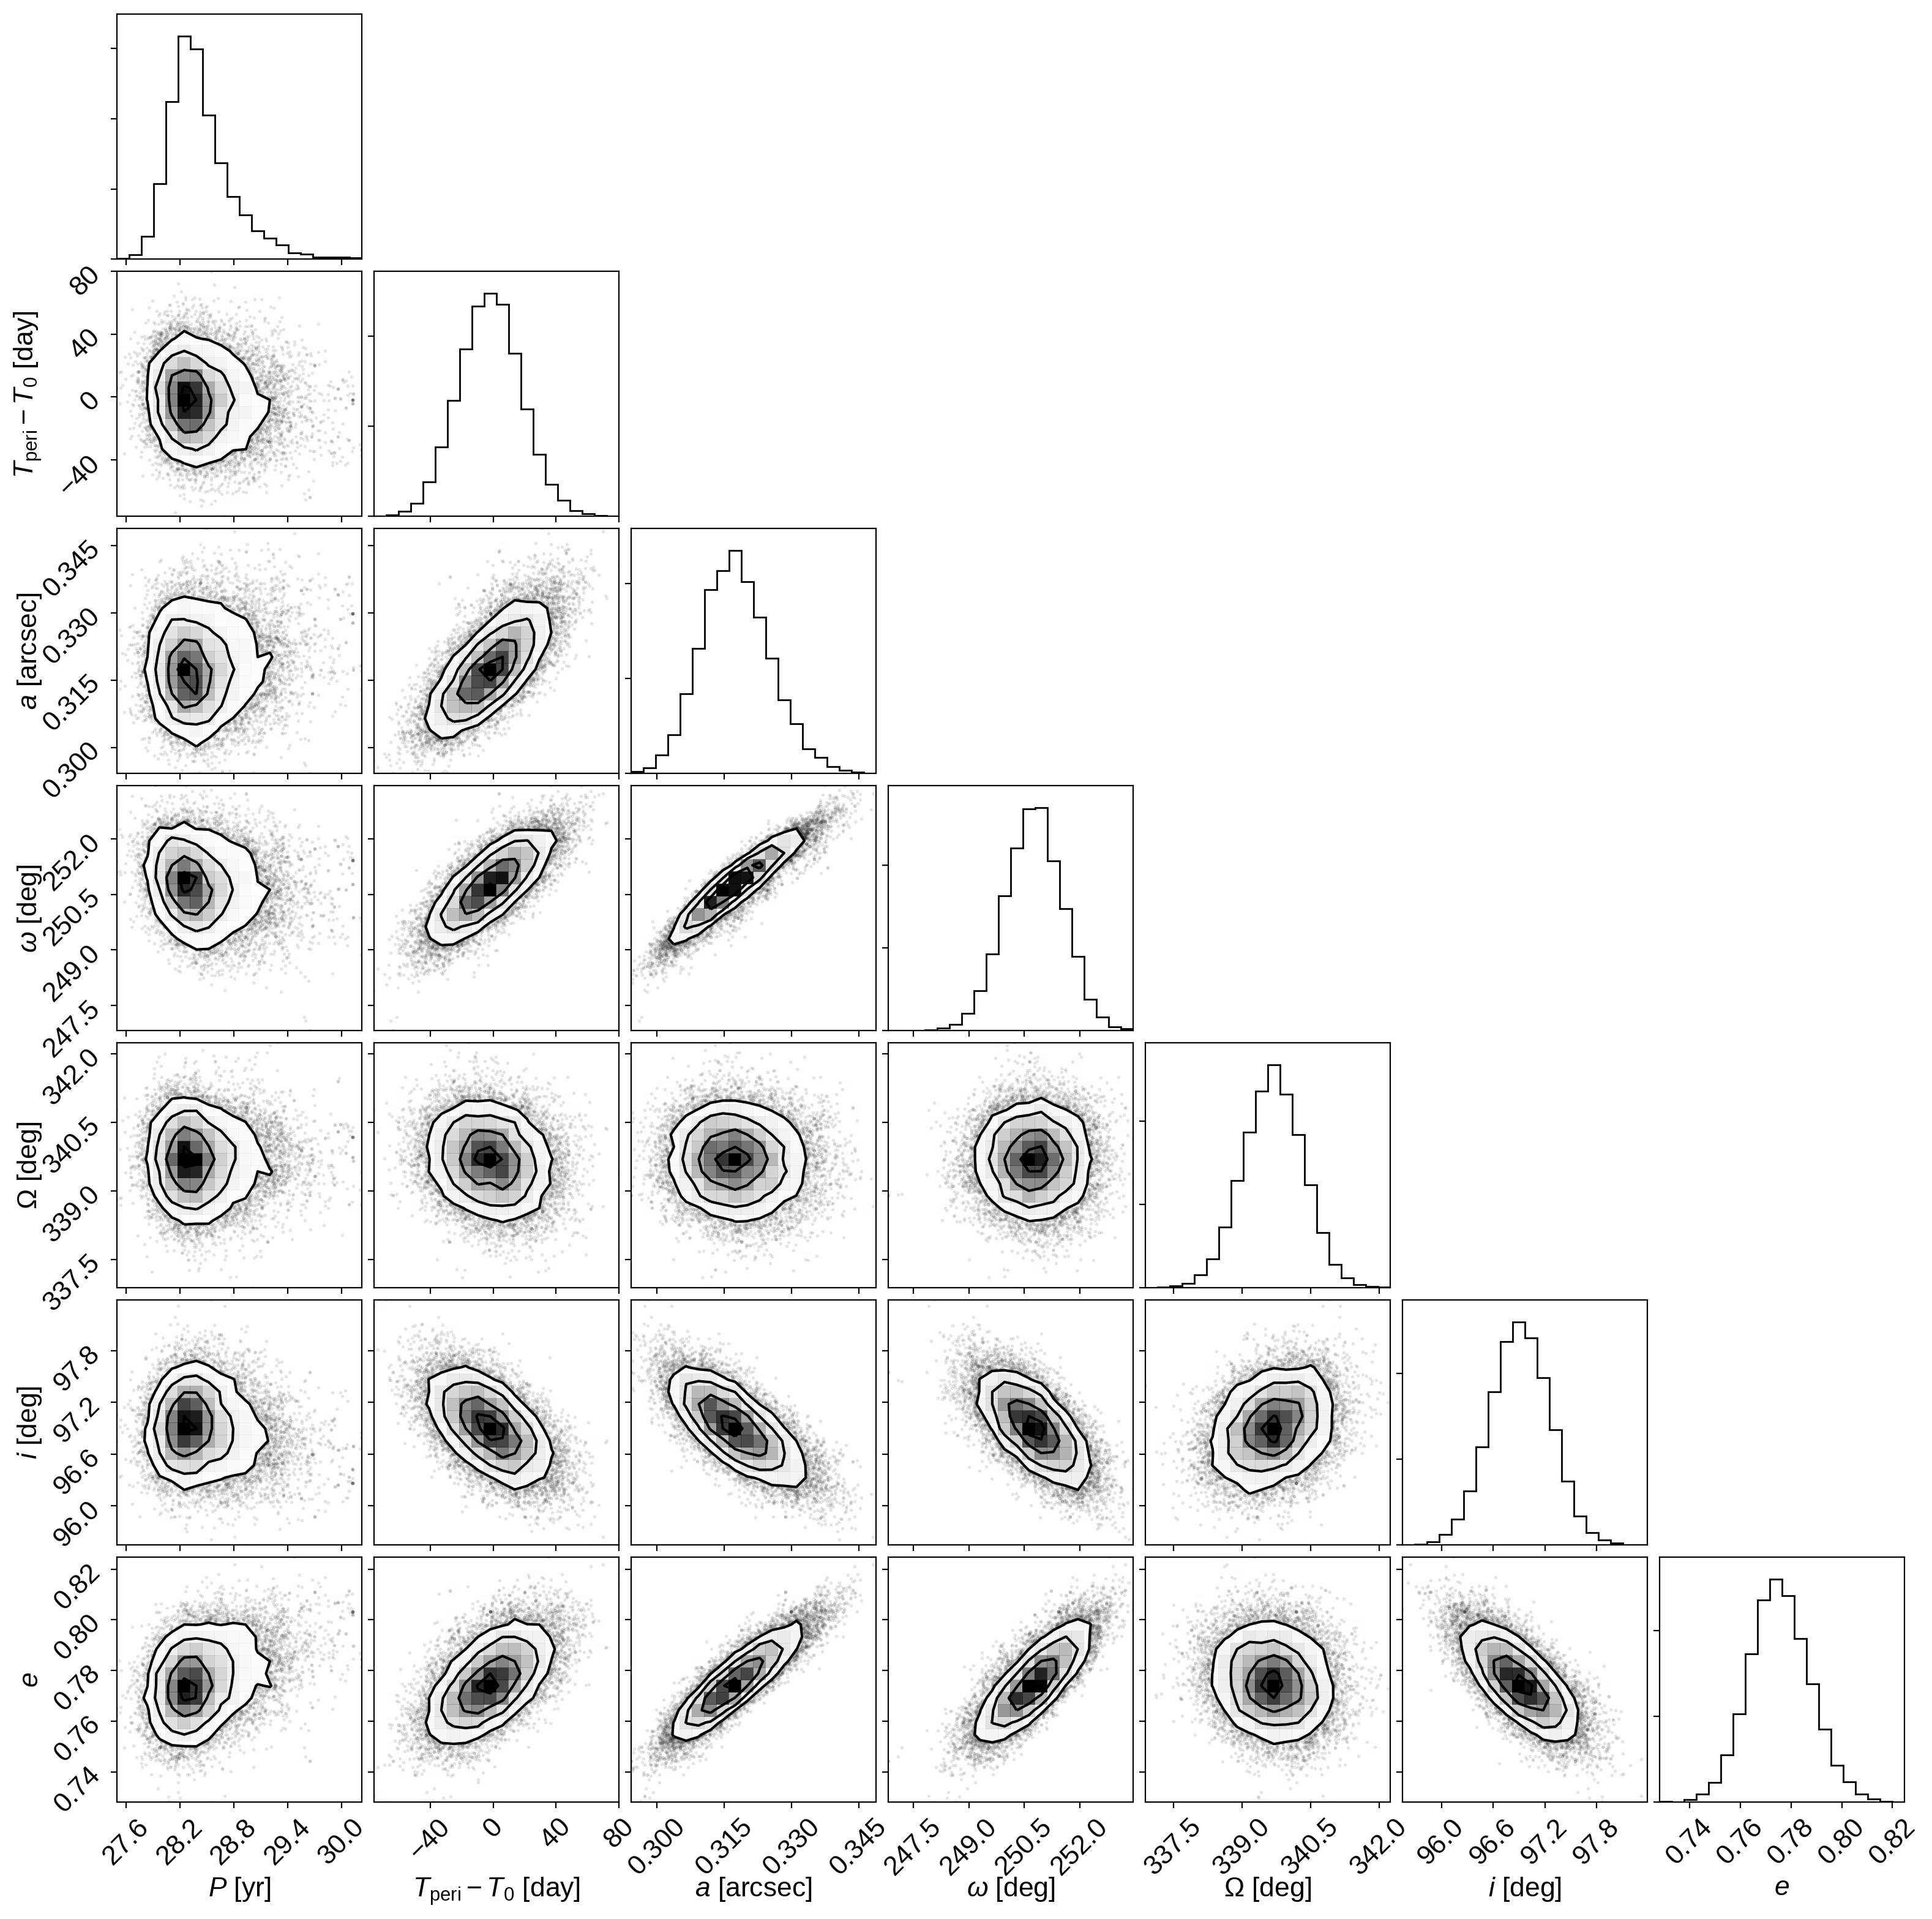

In [12]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=["ecc"])
samples["$P$ [yr]"] = trace["P"] / yr
samples["$T_\mathrm{peri} - T_0$ [day]"] = trace["tperi"] - T0
samples["$a$ [arcsec]"] = trace["a_ang"]
samples["$\omega$ [deg]"] = (trace["omega"] / deg) % 360
samples["$\Omega$ [deg]"] = (trace["Omega"] / deg) % 360
samples["$i$ [deg]"] = (trace["incl"] / deg) % 360
samples["$e$"] = samples["ecc"]
del samples["ecc"]
corner.corner(samples);

Finally, we can plot the posterior constraints on $\rho$ and $\theta$.
This figure is much like the one for the MAP solution above, but this time the orange is a contour (not a line) showing the 68% credible region for the model.

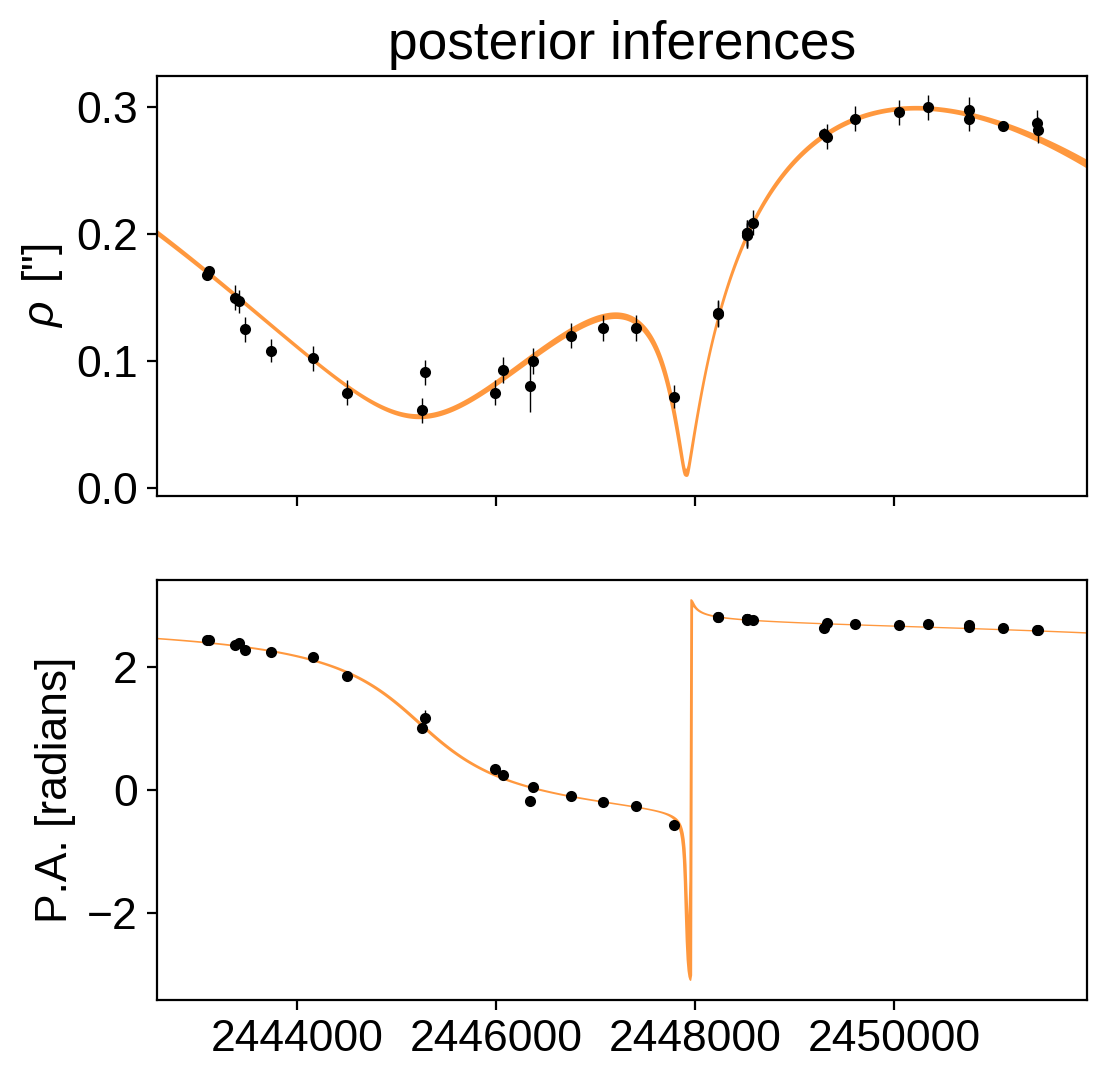

In [13]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r'P.A. [radians]')

tot_rho_err = np.sqrt(rho_err**2 + np.exp(2 * np.median(trace["log_rho_s"], axis=0)))
tot_theta_err = np.sqrt(theta_err**2 + np.exp(2 * np.median(trace["log_theta_s"], axis=0)))

ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
q = np.percentile(trace["rho_save"], [16, 84], axis=0)
ax[0].fill_between(t_fine, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[1].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)
q = np.percentile(trace["theta_save"], [16, 84], axis=0)
ax[1].fill_between(t_fine, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[-1].set_xlim(t_fine[0], t_fine[-1])
ax[0].set_title("posterior inferences");

As we can see from the narrow range of orbits (the orange swath appears like a thin line), the orbit is actually highly constrained by the astrometry.
We also see two outlier epochs in the vicinity of 2445000 - 2447000, since adjacent epochs seem to be right on the orbit.
It's likely the uncertainties were not estimated correctly for these, and the simlplistic jitter model we implemented isn't sophisticated to apply more weight to only these discrepant points.

## Including parallax

While this is encouraging that we fit an astrometric orbit, a simple astrometric fit to just $\rho$ and $\theta$ isn't actually that physically satisfying, since many of the orbital parameters simply have to do with the orientation relative to us ($i$, $\omega$, and $\Omega$). The only truely intrinsic parameters are $P$ and $e$. To learn more about some of the physical parameters, such as the total mass of the system, we'd like to incorporate distance information to put a physical scale to the problem. 

The *Gaia* DR2 parallax is $\varpi = 24.05 \pm 0.45$ mas.

We can use exactly the same model as above with only an added parallax constraint:

In [14]:
plx_model, plx_map_soln = get_model(parallax=[24.05, 0.45])

optimizing logp for variables: ['log_theta_s', 'log_rho_s']


message: Optimization terminated successfully.
logp: 107.64015029576193 -> 149.928601062681


optimizing logp for variables: ['phase_angle__']


message: Optimization terminated successfully.
logp: 149.928601062681 -> 170.42681518460196


optimizing logp for variables: ['ecc_interval__', 'm_angle__', 'p_angle__']


message: Optimization terminated successfully.
logp: 170.42681518460196 -> 212.848015885607


optimizing logp for variables: ['phase_angle__', 'a_ang_interval__', 'logP']


message: Optimization terminated successfully.
logp: 212.848015885607 -> 213.28597911383866


optimizing logp for variables: ['log_theta_s', 'log_rho_s', 'ecc_interval__', 'cos_incl_interval__', 'phase_angle__', 'm_angle__', 'p_angle__', 'logP', 'a_ang_interval__', 'm_plx_interval__']


message: Optimization terminated successfully.
logp: 213.28597911383866 -> 217.8058683350251


In [15]:
np.random.seed(5432)
plx_sampler = xo.PyMC3Sampler(start=200, window=100, finish=500)
with plx_model:
    burnin = plx_sampler.tune(tune=4500, start=plx_map_soln,
                          step_kwargs=dict(target_accept=0.9))
    plx_trace = plx_sampler.sample(draws=4000)

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 13/808 [00:00<00:06, 113.72draws/s]

Sampling 4 chains:   2%|▏         | 19/808 [00:00<00:08, 89.04draws/s] 

Sampling 4 chains:   3%|▎         | 25/808 [00:00<00:11, 68.31draws/s]

Sampling 4 chains:   4%|▍         | 31/808 [00:00<00:12, 61.63draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:00<00:13, 58.16draws/s]

Sampling 4 chains:   5%|▌         | 43/808 [00:00<00:13, 55.12draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:00<00:13, 54.68draws/s]

Sampling 4 chains:   7%|▋         | 54/808 [00:00<00:14, 52.55draws/s]

Sampling 4 chains:   7%|▋         | 60/808 [00:01<00:13, 54.11draws/s]

Sampling 4 chains:   8%|▊         | 66/808 [00:01<00:13, 55.01draws/s]

Sampling 4 chains:   9%|▉         | 72/808 [00:01<00:13, 54.49draws/s]

Sampling 4 chains:  10%|▉         | 78/808 [00:01<00:13, 52.85draws/s]

Sampling 4 chains:  10%|█         | 84/808 [00:01<00:13, 53.31draws/s]

Sampling 4 chains:  11%|█         | 90/808 [00:01<00:13, 53.10draws/s]

Sampling 4 chains:  12%|█▏        | 97/808 [00:01<00:12, 56.31draws/s]

Sampling 4 chains:  13%|█▎        | 107/808 [00:01<00:11, 62.83draws/s]

Sampling 4 chains:  14%|█▍        | 114/808 [00:01<00:11, 59.29draws/s]

Sampling 4 chains:  15%|█▍        | 121/808 [00:02<00:11, 59.96draws/s]

Sampling 4 chains:  16%|█▌        | 128/808 [00:02<00:12, 56.31draws/s]

Sampling 4 chains:  17%|█▋        | 135/808 [00:02<00:11, 57.55draws/s]

Sampling 4 chains:  17%|█▋        | 141/808 [00:02<00:11, 57.13draws/s]

Sampling 4 chains:  18%|█▊        | 147/808 [00:02<00:11, 57.22draws/s]

Sampling 4 chains:  19%|█▉        | 154/808 [00:02<00:11, 59.25draws/s]

Sampling 4 chains:  20%|█▉        | 160/808 [00:02<00:11, 57.85draws/s]

Sampling 4 chains:  21%|██        | 166/808 [00:02<00:12, 52.63draws/s]

Sampling 4 chains:  21%|██▏       | 172/808 [00:02<00:12, 52.87draws/s]

Sampling 4 chains:  22%|██▏       | 178/808 [00:03<00:12, 50.27draws/s]

Sampling 4 chains:  23%|██▎       | 185/808 [00:03<00:11, 53.48draws/s]

Sampling 4 chains:  24%|██▎       | 191/808 [00:03<00:11, 55.14draws/s]

Sampling 4 chains:  24%|██▍       | 197/808 [00:03<00:11, 55.05draws/s]

Sampling 4 chains:  25%|██▌       | 203/808 [00:03<00:11, 54.13draws/s]

Sampling 4 chains:  26%|██▌       | 210/808 [00:03<00:10, 55.97draws/s]

Sampling 4 chains:  27%|██▋       | 216/808 [00:03<00:10, 54.02draws/s]

Sampling 4 chains:  27%|██▋       | 222/808 [00:03<00:10, 54.00draws/s]

Sampling 4 chains:  28%|██▊       | 229/808 [00:04<00:10, 53.52draws/s]

Sampling 4 chains:  29%|██▉       | 235/808 [00:04<00:10, 54.04draws/s]

Sampling 4 chains:  30%|██▉       | 242/808 [00:04<00:10, 56.46draws/s]

Sampling 4 chains:  31%|███       | 248/808 [00:04<00:10, 53.08draws/s]

Sampling 4 chains:  31%|███▏      | 254/808 [00:04<00:10, 52.88draws/s]

Sampling 4 chains:  32%|███▏      | 261/808 [00:04<00:09, 54.80draws/s]

Sampling 4 chains:  33%|███▎      | 268/808 [00:04<00:09, 56.70draws/s]

Sampling 4 chains:  34%|███▍      | 274/808 [00:04<00:09, 53.59draws/s]

Sampling 4 chains:  35%|███▍      | 280/808 [00:04<00:10, 51.15draws/s]

Sampling 4 chains:  36%|███▌      | 287/808 [00:05<00:09, 53.80draws/s]

Sampling 4 chains:  37%|███▋      | 295/808 [00:05<00:09, 55.25draws/s]

Sampling 4 chains:  37%|███▋      | 301/808 [00:05<00:08, 56.55draws/s]

Sampling 4 chains:  38%|███▊      | 308/808 [00:05<00:08, 59.74draws/s]

Sampling 4 chains:  39%|███▉      | 315/808 [00:05<00:08, 55.02draws/s]

Sampling 4 chains:  40%|███▉      | 321/808 [00:05<00:09, 53.72draws/s]

Sampling 4 chains:  40%|████      | 327/808 [00:05<00:08, 54.87draws/s]

Sampling 4 chains:  41%|████      | 333/808 [00:05<00:08, 55.24draws/s]

Sampling 4 chains:  42%|████▏     | 339/808 [00:06<00:08, 52.55draws/s]

Sampling 4 chains:  43%|████▎     | 346/808 [00:06<00:08, 54.76draws/s]

Sampling 4 chains:  44%|████▎     | 352/808 [00:06<00:08, 52.58draws/s]

Sampling 4 chains:  44%|████▍     | 358/808 [00:06<00:08, 50.01draws/s]

Sampling 4 chains:  45%|████▌     | 365/808 [00:06<00:08, 52.09draws/s]

Sampling 4 chains:  46%|████▌     | 371/808 [00:06<00:08, 50.93draws/s]

Sampling 4 chains:  47%|████▋     | 377/808 [00:06<00:08, 51.65draws/s]

Sampling 4 chains:  48%|████▊     | 385/808 [00:06<00:07, 56.47draws/s]

Sampling 4 chains:  48%|████▊     | 391/808 [00:07<00:07, 53.78draws/s]

Sampling 4 chains:  49%|████▉     | 397/808 [00:07<00:07, 52.29draws/s]

Sampling 4 chains:  50%|█████     | 405/808 [00:07<00:07, 56.26draws/s]

Sampling 4 chains:  51%|█████     | 413/808 [00:07<00:06, 56.73draws/s]

Sampling 4 chains:  52%|█████▏    | 419/808 [00:07<00:06, 56.70draws/s]

Sampling 4 chains:  53%|█████▎    | 425/808 [00:07<00:07, 52.20draws/s]

Sampling 4 chains:  53%|█████▎    | 431/808 [00:07<00:06, 53.96draws/s]

Sampling 4 chains:  54%|█████▍    | 437/808 [00:07<00:06, 54.71draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [00:07<00:07, 51.81draws/s]

Sampling 4 chains:  56%|█████▌    | 449/808 [00:08<00:06, 52.14draws/s]

Sampling 4 chains:  57%|█████▋    | 457/808 [00:08<00:06, 56.58draws/s]

Sampling 4 chains:  57%|█████▋    | 464/808 [00:08<00:06, 55.47draws/s]

Sampling 4 chains:  58%|█████▊    | 470/808 [00:08<00:06, 55.50draws/s]

Sampling 4 chains:  59%|█████▉    | 477/808 [00:08<00:06, 54.41draws/s]

Sampling 4 chains:  60%|██████    | 485/808 [00:08<00:05, 58.29draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [00:08<00:05, 54.57draws/s]

Sampling 4 chains:  62%|██████▏   | 499/808 [00:08<00:05, 54.10draws/s]

Sampling 4 chains:  63%|██████▎   | 508/808 [00:09<00:04, 60.67draws/s]

Sampling 4 chains:  64%|██████▎   | 515/808 [00:09<00:04, 58.73draws/s]

Sampling 4 chains:  65%|██████▍   | 522/808 [00:09<00:04, 61.26draws/s]

Sampling 4 chains:  65%|██████▌   | 529/808 [00:09<00:04, 59.75draws/s]

Sampling 4 chains:  66%|██████▋   | 536/808 [00:09<00:04, 59.77draws/s]

Sampling 4 chains:  67%|██████▋   | 543/808 [00:09<00:04, 62.10draws/s]

Sampling 4 chains:  68%|██████▊   | 550/808 [00:09<00:04, 58.22draws/s]

Sampling 4 chains:  69%|██████▉   | 557/808 [00:09<00:04, 57.29draws/s]

Sampling 4 chains:  70%|██████▉   | 563/808 [00:10<00:04, 54.74draws/s]

Sampling 4 chains:  70%|███████   | 569/808 [00:10<00:04, 53.38draws/s]

Sampling 4 chains:  71%|███████   | 575/808 [00:10<00:04, 51.42draws/s]

Sampling 4 chains:  72%|███████▏  | 582/808 [00:10<00:04, 55.56draws/s]

Sampling 4 chains:  73%|███████▎  | 588/808 [00:10<00:04, 52.02draws/s]

Sampling 4 chains:  74%|███████▎  | 594/808 [00:10<00:04, 51.25draws/s]

Sampling 4 chains:  74%|███████▍  | 601/808 [00:10<00:03, 55.39draws/s]

Sampling 4 chains:  75%|███████▌  | 608/808 [00:10<00:03, 56.48draws/s]

Sampling 4 chains:  76%|███████▌  | 614/808 [00:10<00:03, 57.31draws/s]

Sampling 4 chains:  77%|███████▋  | 620/808 [00:11<00:03, 53.16draws/s]

Sampling 4 chains:  77%|███████▋  | 626/808 [00:11<00:03, 54.19draws/s]

Sampling 4 chains:  78%|███████▊  | 634/808 [00:11<00:03, 57.48draws/s]

Sampling 4 chains:  79%|███████▉  | 641/808 [00:11<00:02, 60.36draws/s]

Sampling 4 chains:  80%|████████  | 649/808 [00:11<00:02, 60.50draws/s]

Sampling 4 chains:  81%|████████  | 656/808 [00:11<00:02, 60.75draws/s]

Sampling 4 chains:  82%|████████▏ | 663/808 [00:11<00:02, 57.36draws/s]

Sampling 4 chains:  83%|████████▎ | 670/808 [00:11<00:02, 59.29draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [00:12<00:02, 63.23draws/s]

Sampling 4 chains:  85%|████████▌ | 688/808 [00:12<00:01, 66.30draws/s]

Sampling 4 chains:  86%|████████▌ | 695/808 [00:12<00:01, 61.73draws/s]

Sampling 4 chains:  87%|████████▋ | 702/808 [00:12<00:01, 59.97draws/s]

Sampling 4 chains:  88%|████████▊ | 709/808 [00:12<00:01, 60.39draws/s]

Sampling 4 chains:  89%|████████▊ | 716/808 [00:12<00:01, 55.37draws/s]

Sampling 4 chains:  90%|████████▉ | 724/808 [00:12<00:01, 54.16draws/s]

Sampling 4 chains:  91%|█████████ | 732/808 [00:12<00:01, 53.35draws/s]

Sampling 4 chains:  92%|█████████▏| 740/808 [00:13<00:01, 59.25draws/s]

Sampling 4 chains:  92%|█████████▏| 747/808 [00:13<00:01, 54.22draws/s]

Sampling 4 chains:  93%|█████████▎| 753/808 [00:13<00:01, 51.08draws/s]

Sampling 4 chains:  94%|█████████▍| 760/808 [00:13<00:00, 54.31draws/s]

Sampling 4 chains:  95%|█████████▍| 766/808 [00:13<00:00, 52.23draws/s]

Sampling 4 chains:  96%|█████████▌| 773/808 [00:13<00:00, 55.52draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [00:13<00:00, 55.55draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [00:14<00:00, 48.52draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [00:14<00:00, 41.79draws/s]

Sampling 4 chains:  99%|█████████▊| 797/808 [00:14<00:00, 41.06draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [00:14<00:00, 32.29draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [00:14<00:00, 21.65draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:15<00:00, 53.09draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 13/408 [00:00<00:03, 113.33draws/s]

Sampling 4 chains:   5%|▍         | 20/408 [00:00<00:04, 90.96draws/s] 

Sampling 4 chains:   6%|▌         | 25/408 [00:00<00:05, 63.84draws/s]

Sampling 4 chains:   8%|▊         | 33/408 [00:00<00:05, 67.33draws/s]

Sampling 4 chains:  10%|▉         | 39/408 [00:00<00:05, 62.29draws/s]

Sampling 4 chains:  11%|█▏        | 46/408 [00:00<00:05, 60.99draws/s]

Sampling 4 chains:  13%|█▎        | 52/408 [00:00<00:06, 59.30draws/s]

Sampling 4 chains:  15%|█▍        | 60/408 [00:00<00:05, 63.41draws/s]

Sampling 4 chains:  17%|█▋        | 68/408 [00:01<00:05, 66.88draws/s]

Sampling 4 chains:  18%|█▊        | 75/408 [00:01<00:05, 59.65draws/s]

Sampling 4 chains:  20%|██        | 82/408 [00:01<00:05, 59.37draws/s]

Sampling 4 chains:  22%|██▏       | 90/408 [00:01<00:04, 64.07draws/s]

Sampling 4 chains:  24%|██▍       | 97/408 [00:01<00:05, 59.21draws/s]

Sampling 4 chains:  26%|██▌       | 106/408 [00:01<00:04, 65.27draws/s]

Sampling 4 chains:  28%|██▊       | 113/408 [00:01<00:04, 59.90draws/s]

Sampling 4 chains:  30%|██▉       | 122/408 [00:01<00:04, 62.32draws/s]

Sampling 4 chains:  32%|███▏      | 132/408 [00:02<00:04, 66.20draws/s]

Sampling 4 chains:  34%|███▍      | 140/408 [00:02<00:04, 64.13draws/s]

Sampling 4 chains:  36%|███▌      | 147/408 [00:02<00:04, 61.66draws/s]

Sampling 4 chains:  39%|███▉      | 159/408 [00:02<00:03, 70.75draws/s]

Sampling 4 chains:  41%|████      | 168/408 [00:02<00:03, 74.66draws/s]

Sampling 4 chains:  43%|████▎     | 176/408 [00:02<00:03, 71.79draws/s]

Sampling 4 chains:  45%|████▌     | 185/408 [00:02<00:02, 75.75draws/s]

Sampling 4 chains:  47%|████▋     | 193/408 [00:02<00:03, 70.28draws/s]

Sampling 4 chains:  50%|████▉     | 202/408 [00:02<00:02, 74.45draws/s]

Sampling 4 chains:  51%|█████▏    | 210/408 [00:03<00:02, 67.48draws/s]

Sampling 4 chains:  53%|█████▎    | 218/408 [00:03<00:02, 66.67draws/s]

Sampling 4 chains:  55%|█████▌    | 226/408 [00:03<00:02, 70.02draws/s]

Sampling 4 chains:  57%|█████▋    | 234/408 [00:03<00:02, 71.44draws/s]

Sampling 4 chains:  59%|█████▉    | 242/408 [00:03<00:02, 62.58draws/s]

Sampling 4 chains:  61%|██████▏   | 250/408 [00:03<00:02, 64.51draws/s]

Sampling 4 chains:  63%|██████▎   | 258/408 [00:03<00:02, 66.65draws/s]

Sampling 4 chains:  65%|██████▍   | 265/408 [00:03<00:02, 64.01draws/s]

Sampling 4 chains:  67%|██████▋   | 273/408 [00:04<00:01, 67.99draws/s]

Sampling 4 chains:  69%|██████▉   | 282/408 [00:04<00:01, 71.08draws/s]

Sampling 4 chains:  71%|███████   | 290/408 [00:04<00:01, 73.17draws/s]

Sampling 4 chains:  74%|███████▍  | 301/408 [00:04<00:01, 81.27draws/s]

Sampling 4 chains:  76%|███████▌  | 310/408 [00:04<00:01, 70.52draws/s]

Sampling 4 chains:  79%|███████▉  | 323/408 [00:04<00:01, 79.67draws/s]

Sampling 4 chains:  81%|████████▏ | 332/408 [00:04<00:01, 74.81draws/s]

Sampling 4 chains:  84%|████████▎ | 341/408 [00:04<00:00, 78.19draws/s]

Sampling 4 chains:  86%|████████▌ | 350/408 [00:04<00:00, 79.64draws/s]

Sampling 4 chains:  88%|████████▊ | 359/408 [00:05<00:00, 74.83draws/s]

Sampling 4 chains:  90%|████████▉ | 367/408 [00:05<00:00, 73.58draws/s]

Sampling 4 chains:  93%|█████████▎| 378/408 [00:05<00:00, 77.00draws/s]

Sampling 4 chains:  95%|█████████▍| 387/408 [00:05<00:00, 80.09draws/s]

Sampling 4 chains:  97%|█████████▋| 396/408 [00:05<00:00, 77.77draws/s]

Sampling 4 chains:  99%|█████████▉| 405/408 [00:05<00:00, 71.71draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:05<00:00, 68.77draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:00<00:02, 356.04draws/s]

Sampling 4 chains:   8%|▊         | 63/808 [00:00<00:02, 318.32draws/s]

Sampling 4 chains:  12%|█▏        | 97/808 [00:00<00:02, 323.19draws/s]

Sampling 4 chains:  16%|█▋        | 133/808 [00:00<00:02, 332.07draws/s]

Sampling 4 chains:  23%|██▎       | 183/808 [00:00<00:01, 368.42draws/s]

Sampling 4 chains:  28%|██▊       | 230/808 [00:00<00:01, 391.39draws/s]

Sampling 4 chains:  34%|███▎      | 272/808 [00:00<00:01, 399.53draws/s]

Sampling 4 chains:  40%|███▉      | 322/808 [00:00<00:01, 422.74draws/s]

Sampling 4 chains:  47%|████▋     | 380/808 [00:00<00:00, 459.49draws/s]

Sampling 4 chains:  53%|█████▎    | 427/808 [00:01<00:00, 457.62draws/s]

Sampling 4 chains:  59%|█████▊    | 474/808 [00:01<00:00, 460.17draws/s]

Sampling 4 chains:  64%|██████▍   | 521/808 [00:01<00:00, 440.24draws/s]

Sampling 4 chains:  72%|███████▏  | 580/808 [00:01<00:00, 475.01draws/s]

Sampling 4 chains:  78%|███████▊  | 629/808 [00:01<00:00, 475.28draws/s]

Sampling 4 chains:  84%|████████▍ | 682/808 [00:01<00:00, 464.16draws/s]

Sampling 4 chains:  90%|█████████ | 729/808 [00:01<00:00, 423.80draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [00:01<00:00, 445.87draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:01<00:00, 416.80draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 42/1608 [00:00<00:03, 418.36draws/s]

Sampling 4 chains:   5%|▍         | 74/1608 [00:00<00:04, 381.62draws/s]

Sampling 4 chains:   6%|▋         | 103/1608 [00:00<00:04, 348.09draws/s]

Sampling 4 chains:   9%|▉         | 147/1608 [00:00<00:03, 370.98draws/s]

Sampling 4 chains:  12%|█▏        | 185/1608 [00:00<00:03, 369.95draws/s]

Sampling 4 chains:  13%|█▎        | 216/1608 [00:00<00:04, 339.13draws/s]

Sampling 4 chains:  16%|█▌        | 260/1608 [00:00<00:03, 363.88draws/s]

Sampling 4 chains:  19%|█▉        | 309/1608 [00:00<00:03, 393.86draws/s]

Sampling 4 chains:  22%|██▏       | 350/1608 [00:00<00:03, 395.24draws/s]

Sampling 4 chains:  24%|██▍       | 389/1608 [00:01<00:03, 362.35draws/s]

Sampling 4 chains:  27%|██▋       | 434/1608 [00:01<00:03, 384.25draws/s]

Sampling 4 chains:  29%|██▉       | 474/1608 [00:01<00:02, 388.47draws/s]

Sampling 4 chains:  32%|███▏      | 515/1608 [00:01<00:02, 390.87draws/s]

Sampling 4 chains:  35%|███▍      | 557/1608 [00:01<00:02, 398.58draws/s]

Sampling 4 chains:  37%|███▋      | 602/1608 [00:01<00:02, 410.66draws/s]

Sampling 4 chains:  41%|████      | 655/1608 [00:01<00:02, 439.00draws/s]

Sampling 4 chains:  44%|████▎     | 700/1608 [00:01<00:02, 437.16draws/s]

Sampling 4 chains:  46%|████▋     | 745/1608 [00:01<00:01, 432.86draws/s]

Sampling 4 chains:  50%|████▉     | 800/1608 [00:01<00:01, 458.62draws/s]

Sampling 4 chains:  53%|█████▎    | 847/1608 [00:02<00:01, 453.68draws/s]

Sampling 4 chains:  56%|█████▌    | 893/1608 [00:02<00:01, 421.62draws/s]

Sampling 4 chains:  58%|█████▊    | 936/1608 [00:02<00:01, 418.23draws/s]

Sampling 4 chains:  61%|██████    | 981/1608 [00:02<00:01, 427.11draws/s]

Sampling 4 chains:  64%|██████▍   | 1029/1608 [00:02<00:01, 441.48draws/s]

Sampling 4 chains:  67%|██████▋   | 1074/1608 [00:02<00:01, 437.26draws/s]

Sampling 4 chains:  70%|███████   | 1132/1608 [00:02<00:01, 471.48draws/s]

Sampling 4 chains:  73%|███████▎  | 1181/1608 [00:02<00:00, 466.88draws/s]

Sampling 4 chains:  77%|███████▋  | 1236/1608 [00:02<00:00, 487.68draws/s]

Sampling 4 chains:  80%|████████  | 1287/1608 [00:03<00:00, 492.74draws/s]

Sampling 4 chains:  83%|████████▎ | 1337/1608 [00:03<00:00, 487.09draws/s]

Sampling 4 chains:  87%|████████▋ | 1393/1608 [00:03<00:00, 506.31draws/s]

Sampling 4 chains:  90%|████████▉ | 1445/1608 [00:03<00:00, 478.32draws/s]

Sampling 4 chains:  93%|█████████▎| 1494/1608 [00:03<00:00, 422.25draws/s]

Sampling 4 chains:  96%|█████████▌| 1538/1608 [00:03<00:00, 404.52draws/s]

Sampling 4 chains:  98%|█████████▊| 1580/1608 [00:03<00:00, 346.19draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [00:03<00:00, 404.92draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 37/3208 [00:00<00:08, 365.22draws/s]

Sampling 4 chains:   2%|▏         | 78/3208 [00:00<00:08, 376.42draws/s]

Sampling 4 chains:   4%|▍         | 121/3208 [00:00<00:07, 390.28draws/s]

Sampling 4 chains:   5%|▌         | 168/3208 [00:00<00:07, 404.32draws/s]

Sampling 4 chains:   6%|▌         | 200/3208 [00:00<00:08, 360.16draws/s]

Sampling 4 chains:   8%|▊         | 243/3208 [00:00<00:07, 377.57draws/s]

Sampling 4 chains:   9%|▉         | 286/3208 [00:00<00:07, 391.03draws/s]

Sampling 4 chains:  10%|█         | 329/3208 [00:00<00:07, 396.79draws/s]

Sampling 4 chains:  11%|█▏        | 368/3208 [00:00<00:07, 387.34draws/s]

Sampling 4 chains:  13%|█▎        | 410/3208 [00:01<00:07, 395.52draws/s]

Sampling 4 chains:  14%|█▍        | 449/3208 [00:01<00:07, 360.85draws/s]

Sampling 4 chains:  15%|█▌        | 486/3208 [00:01<00:07, 348.13draws/s]

Sampling 4 chains:  17%|█▋        | 532/3208 [00:01<00:07, 375.18draws/s]

Sampling 4 chains:  18%|█▊        | 571/3208 [00:01<00:07, 373.97draws/s]

Sampling 4 chains:  20%|█▉        | 627/3208 [00:01<00:06, 414.05draws/s]

Sampling 4 chains:  21%|██        | 675/3208 [00:01<00:05, 431.68draws/s]

Sampling 4 chains:  22%|██▏       | 720/3208 [00:01<00:05, 433.37draws/s]

Sampling 4 chains:  24%|██▍       | 765/3208 [00:01<00:05, 433.97draws/s]

Sampling 4 chains:  25%|██▌       | 818/3208 [00:01<00:05, 458.31draws/s]

Sampling 4 chains:  27%|██▋       | 872/3208 [00:02<00:04, 477.25draws/s]

Sampling 4 chains:  29%|██▊       | 921/3208 [00:02<00:05, 446.06draws/s]

Sampling 4 chains:  30%|███       | 967/3208 [00:02<00:05, 441.28draws/s]

Sampling 4 chains:  32%|███▏      | 1014/3208 [00:02<00:04, 448.10draws/s]

Sampling 4 chains:  33%|███▎      | 1064/3208 [00:02<00:04, 462.07draws/s]

Sampling 4 chains:  35%|███▍      | 1112/3208 [00:02<00:04, 465.40draws/s]

Sampling 4 chains:  36%|███▋      | 1165/3208 [00:02<00:04, 480.82draws/s]

Sampling 4 chains:  38%|███▊      | 1214/3208 [00:02<00:04, 478.29draws/s]

Sampling 4 chains:  39%|███▉      | 1263/3208 [00:02<00:04, 470.89draws/s]

Sampling 4 chains:  41%|████      | 1311/3208 [00:03<00:04, 459.96draws/s]

Sampling 4 chains:  43%|████▎     | 1365/3208 [00:03<00:03, 479.96draws/s]

Sampling 4 chains:  44%|████▍     | 1415/3208 [00:03<00:03, 484.38draws/s]

Sampling 4 chains:  46%|████▌     | 1473/3208 [00:03<00:03, 506.02draws/s]

Sampling 4 chains:  48%|████▊     | 1525/3208 [00:03<00:03, 488.37draws/s]

Sampling 4 chains:  49%|████▉     | 1575/3208 [00:03<00:03, 487.05draws/s]

Sampling 4 chains:  51%|█████     | 1625/3208 [00:03<00:03, 480.90draws/s]

Sampling 4 chains:  52%|█████▏    | 1674/3208 [00:03<00:03, 461.51draws/s]

Sampling 4 chains:  54%|█████▎    | 1721/3208 [00:03<00:03, 437.92draws/s]

Sampling 4 chains:  55%|█████▌    | 1772/3208 [00:04<00:03, 455.72draws/s]

Sampling 4 chains:  57%|█████▋    | 1827/3208 [00:04<00:02, 479.62draws/s]

Sampling 4 chains:  58%|█████▊    | 1876/3208 [00:04<00:02, 462.93draws/s]

Sampling 4 chains:  60%|█████▉    | 1923/3208 [00:04<00:02, 461.54draws/s]

Sampling 4 chains:  62%|██████▏   | 1976/3208 [00:04<00:02, 479.74draws/s]

Sampling 4 chains:  63%|██████▎   | 2037/3208 [00:04<00:02, 511.61draws/s]

Sampling 4 chains:  65%|██████▌   | 2090/3208 [00:04<00:02, 511.11draws/s]

Sampling 4 chains:  67%|██████▋   | 2142/3208 [00:04<00:02, 497.53draws/s]

Sampling 4 chains:  68%|██████▊   | 2193/3208 [00:04<00:02, 495.87draws/s]

Sampling 4 chains:  70%|██████▉   | 2243/3208 [00:04<00:02, 466.18draws/s]

Sampling 4 chains:  71%|███████▏  | 2291/3208 [00:05<00:02, 438.60draws/s]

Sampling 4 chains:  73%|███████▎  | 2336/3208 [00:05<00:02, 424.21draws/s]

Sampling 4 chains:  74%|███████▍  | 2380/3208 [00:05<00:01, 427.99draws/s]

Sampling 4 chains:  76%|███████▌  | 2426/3208 [00:05<00:01, 435.69draws/s]

Sampling 4 chains:  77%|███████▋  | 2482/3208 [00:05<00:01, 465.74draws/s]

Sampling 4 chains:  79%|███████▉  | 2531/3208 [00:05<00:01, 467.46draws/s]

Sampling 4 chains:  80%|████████  | 2579/3208 [00:05<00:01, 459.40draws/s]

Sampling 4 chains:  82%|████████▏ | 2633/3208 [00:05<00:01, 479.82draws/s]

Sampling 4 chains:  84%|████████▎ | 2685/3208 [00:05<00:01, 489.29draws/s]

Sampling 4 chains:  85%|████████▌ | 2735/3208 [00:06<00:00, 481.97draws/s]

Sampling 4 chains:  87%|████████▋ | 2784/3208 [00:06<00:00, 463.75draws/s]

Sampling 4 chains:  88%|████████▊ | 2834/3208 [00:06<00:00, 473.64draws/s]

Sampling 4 chains:  90%|████████▉ | 2882/3208 [00:06<00:00, 472.79draws/s]

Sampling 4 chains:  91%|█████████▏| 2931/3208 [00:06<00:00, 473.94draws/s]

Sampling 4 chains:  93%|█████████▎| 2980/3208 [00:06<00:00, 476.56draws/s]

Sampling 4 chains:  94%|█████████▍| 3030/3208 [00:06<00:00, 482.67draws/s]

Sampling 4 chains:  96%|█████████▌| 3079/3208 [00:06<00:00, 433.73draws/s]

Sampling 4 chains:  97%|█████████▋| 3124/3208 [00:06<00:00, 430.70draws/s]

Sampling 4 chains:  99%|█████████▉| 3168/3208 [00:07<00:00, 411.03draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [00:07<00:00, 440.51draws/s]

Sampling 4 chains:   0%|          | 0/11208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 31/11208 [00:00<00:36, 306.91draws/s]

Sampling 4 chains:   1%|          | 73/11208 [00:00<00:33, 333.63draws/s]

Sampling 4 chains:   1%|          | 115/11208 [00:00<00:31, 355.02draws/s]

Sampling 4 chains:   1%|▏         | 160/11208 [00:00<00:29, 377.78draws/s]

Sampling 4 chains:   2%|▏         | 198/11208 [00:00<00:29, 378.24draws/s]

Sampling 4 chains:   2%|▏         | 240/11208 [00:00<00:28, 383.80draws/s]

Sampling 4 chains:   2%|▏         | 276/11208 [00:00<00:29, 375.89draws/s]

Sampling 4 chains:   3%|▎         | 312/11208 [00:00<00:32, 337.92draws/s]

Sampling 4 chains:   3%|▎         | 352/11208 [00:00<00:30, 352.67draws/s]

Sampling 4 chains:   3%|▎         | 387/11208 [00:01<00:30, 351.78draws/s]

Sampling 4 chains:   4%|▍         | 430/11208 [00:01<00:29, 366.41draws/s]

Sampling 4 chains:   4%|▍         | 471/11208 [00:01<00:28, 374.29draws/s]

Sampling 4 chains:   5%|▍         | 523/11208 [00:01<00:26, 407.88draws/s]

Sampling 4 chains:   5%|▌         | 565/11208 [00:01<00:26, 406.48draws/s]

Sampling 4 chains:   6%|▌         | 618/11208 [00:01<00:24, 436.30draws/s]

Sampling 4 chains:   6%|▌         | 663/11208 [00:01<00:24, 429.64draws/s]

Sampling 4 chains:   6%|▋         | 707/11208 [00:01<00:24, 430.93draws/s]

Sampling 4 chains:   7%|▋         | 751/11208 [00:01<00:24, 420.40draws/s]

Sampling 4 chains:   7%|▋         | 796/11208 [00:01<00:24, 427.29draws/s]

Sampling 4 chains:   8%|▊         | 848/11208 [00:02<00:22, 451.31draws/s]

Sampling 4 chains:   8%|▊         | 900/11208 [00:02<00:21, 469.72draws/s]

Sampling 4 chains:   9%|▊         | 966/11208 [00:02<00:19, 513.90draws/s]

Sampling 4 chains:   9%|▉         | 1020/11208 [00:02<00:19, 514.75draws/s]

Sampling 4 chains:  10%|▉         | 1073/11208 [00:02<00:19, 514.77draws/s]

Sampling 4 chains:  10%|█         | 1126/11208 [00:02<00:19, 514.39draws/s]

Sampling 4 chains:  11%|█         | 1183/11208 [00:02<00:19, 522.73draws/s]

Sampling 4 chains:  11%|█         | 1236/11208 [00:02<00:19, 506.74draws/s]

Sampling 4 chains:  12%|█▏        | 1291/11208 [00:02<00:19, 518.37draws/s]

Sampling 4 chains:  12%|█▏        | 1356/11208 [00:03<00:17, 551.84draws/s]

Sampling 4 chains:  13%|█▎        | 1413/11208 [00:03<00:18, 539.31draws/s]

Sampling 4 chains:  13%|█▎        | 1468/11208 [00:03<00:20, 480.48draws/s]

Sampling 4 chains:  14%|█▎        | 1530/11208 [00:03<00:18, 511.66draws/s]

Sampling 4 chains:  14%|█▍        | 1584/11208 [00:03<00:18, 515.98draws/s]

Sampling 4 chains:  15%|█▍        | 1637/11208 [00:03<00:19, 498.93draws/s]

Sampling 4 chains:  15%|█▌        | 1689/11208 [00:03<00:18, 502.32draws/s]

Sampling 4 chains:  16%|█▌        | 1740/11208 [00:03<00:19, 485.01draws/s]

Sampling 4 chains:  16%|█▌        | 1802/11208 [00:03<00:18, 516.95draws/s]

Sampling 4 chains:  17%|█▋        | 1855/11208 [00:04<00:18, 494.15draws/s]

Sampling 4 chains:  17%|█▋        | 1906/11208 [00:04<00:18, 492.36draws/s]

Sampling 4 chains:  17%|█▋        | 1961/11208 [00:04<00:18, 508.33draws/s]

Sampling 4 chains:  18%|█▊        | 2013/11208 [00:04<00:18, 494.72draws/s]

Sampling 4 chains:  18%|█▊        | 2072/11208 [00:04<00:17, 519.21draws/s]

Sampling 4 chains:  19%|█▉        | 2132/11208 [00:04<00:16, 540.10draws/s]

Sampling 4 chains:  20%|█▉        | 2187/11208 [00:04<00:16, 540.16draws/s]

Sampling 4 chains:  20%|██        | 2242/11208 [00:04<00:17, 526.10draws/s]

Sampling 4 chains:  20%|██        | 2296/11208 [00:04<00:17, 505.76draws/s]

Sampling 4 chains:  21%|██        | 2349/11208 [00:04<00:17, 512.08draws/s]

Sampling 4 chains:  21%|██▏       | 2402/11208 [00:05<00:17, 515.85draws/s]

Sampling 4 chains:  22%|██▏       | 2454/11208 [00:05<00:17, 513.56draws/s]

Sampling 4 chains:  22%|██▏       | 2509/11208 [00:05<00:16, 521.47draws/s]

Sampling 4 chains:  23%|██▎       | 2562/11208 [00:05<00:16, 513.56draws/s]

Sampling 4 chains:  23%|██▎       | 2619/11208 [00:05<00:16, 527.55draws/s]

Sampling 4 chains:  24%|██▍       | 2672/11208 [00:05<00:17, 493.87draws/s]

Sampling 4 chains:  24%|██▍       | 2723/11208 [00:05<00:17, 494.91draws/s]

Sampling 4 chains:  25%|██▍       | 2773/11208 [00:05<00:17, 494.08draws/s]

Sampling 4 chains:  25%|██▌       | 2823/11208 [00:05<00:17, 487.82draws/s]

Sampling 4 chains:  26%|██▌       | 2872/11208 [00:06<00:17, 487.09draws/s]

Sampling 4 chains:  26%|██▌       | 2926/11208 [00:06<00:16, 495.44draws/s]

Sampling 4 chains:  27%|██▋       | 2976/11208 [00:06<00:17, 482.10draws/s]

Sampling 4 chains:  27%|██▋       | 3025/11208 [00:06<00:17, 469.78draws/s]

Sampling 4 chains:  28%|██▊       | 3087/11208 [00:06<00:16, 504.46draws/s]

Sampling 4 chains:  28%|██▊       | 3144/11208 [00:06<00:15, 520.77draws/s]

Sampling 4 chains:  29%|██▊       | 3197/11208 [00:06<00:16, 494.79draws/s]

Sampling 4 chains:  29%|██▉       | 3253/11208 [00:06<00:15, 511.34draws/s]

Sampling 4 chains:  30%|██▉       | 3314/11208 [00:06<00:14, 536.30draws/s]

Sampling 4 chains:  30%|███       | 3369/11208 [00:06<00:15, 521.99draws/s]

Sampling 4 chains:  31%|███       | 3422/11208 [00:07<00:15, 494.85draws/s]

Sampling 4 chains:  31%|███       | 3473/11208 [00:07<00:15, 488.23draws/s]

Sampling 4 chains:  31%|███▏      | 3523/11208 [00:07<00:16, 455.16draws/s]

Sampling 4 chains:  32%|███▏      | 3570/11208 [00:07<00:17, 445.14draws/s]

Sampling 4 chains:  32%|███▏      | 3626/11208 [00:07<00:16, 473.51draws/s]

Sampling 4 chains:  33%|███▎      | 3675/11208 [00:07<00:16, 457.57draws/s]

Sampling 4 chains:  33%|███▎      | 3731/11208 [00:07<00:15, 484.03draws/s]

Sampling 4 chains:  34%|███▍      | 3792/11208 [00:07<00:14, 514.65draws/s]

Sampling 4 chains:  34%|███▍      | 3845/11208 [00:07<00:14, 494.08draws/s]

Sampling 4 chains:  35%|███▍      | 3902/11208 [00:08<00:14, 512.75draws/s]

Sampling 4 chains:  35%|███▌      | 3955/11208 [00:08<00:14, 505.82draws/s]

Sampling 4 chains:  36%|███▌      | 4007/11208 [00:08<00:14, 506.72draws/s]

Sampling 4 chains:  36%|███▌      | 4059/11208 [00:08<00:14, 496.77draws/s]

Sampling 4 chains:  37%|███▋      | 4117/11208 [00:08<00:13, 514.50draws/s]

Sampling 4 chains:  37%|███▋      | 4169/11208 [00:08<00:14, 502.49draws/s]

Sampling 4 chains:  38%|███▊      | 4224/11208 [00:08<00:13, 513.62draws/s]

Sampling 4 chains:  38%|███▊      | 4285/11208 [00:08<00:12, 538.78draws/s]

Sampling 4 chains:  39%|███▊      | 4340/11208 [00:08<00:12, 534.45draws/s]

Sampling 4 chains:  39%|███▉      | 4394/11208 [00:09<00:13, 491.27draws/s]

Sampling 4 chains:  40%|███▉      | 4445/11208 [00:09<00:14, 468.66draws/s]

Sampling 4 chains:  40%|████      | 4501/11208 [00:09<00:13, 492.34draws/s]

Sampling 4 chains:  41%|████      | 4552/11208 [00:09<00:14, 461.56draws/s]

Sampling 4 chains:  41%|████      | 4604/11208 [00:09<00:13, 476.80draws/s]

Sampling 4 chains:  42%|████▏     | 4658/11208 [00:09<00:13, 492.23draws/s]

Sampling 4 chains:  42%|████▏     | 4712/11208 [00:09<00:12, 505.53draws/s]

Sampling 4 chains:  43%|████▎     | 4765/11208 [00:09<00:12, 512.59draws/s]

Sampling 4 chains:  43%|████▎     | 4820/11208 [00:09<00:12, 521.89draws/s]

Sampling 4 chains:  43%|████▎     | 4874/11208 [00:09<00:12, 524.18draws/s]

Sampling 4 chains:  44%|████▍     | 4928/11208 [00:10<00:11, 528.28draws/s]

Sampling 4 chains:  44%|████▍     | 4984/11208 [00:10<00:11, 536.05draws/s]

Sampling 4 chains:  45%|████▍     | 5038/11208 [00:10<00:11, 536.83draws/s]

Sampling 4 chains:  45%|████▌     | 5099/11208 [00:10<00:11, 554.81draws/s]

Sampling 4 chains:  46%|████▌     | 5155/11208 [00:10<00:11, 548.53draws/s]

Sampling 4 chains:  46%|████▋     | 5211/11208 [00:10<00:11, 529.14draws/s]

Sampling 4 chains:  47%|████▋     | 5265/11208 [00:10<00:11, 525.58draws/s]

Sampling 4 chains:  47%|████▋     | 5321/11208 [00:10<00:11, 533.95draws/s]

Sampling 4 chains:  48%|████▊     | 5375/11208 [00:10<00:10, 531.91draws/s]

Sampling 4 chains:  48%|████▊     | 5429/11208 [00:11<00:11, 519.70draws/s]

Sampling 4 chains:  49%|████▉     | 5482/11208 [00:11<00:11, 518.91draws/s]

Sampling 4 chains:  49%|████▉     | 5537/11208 [00:11<00:10, 527.67draws/s]

Sampling 4 chains:  50%|████▉     | 5591/11208 [00:11<00:10, 530.97draws/s]

Sampling 4 chains:  50%|█████     | 5654/11208 [00:11<00:10, 554.19draws/s]

Sampling 4 chains:  51%|█████     | 5720/11208 [00:11<00:09, 579.28draws/s]

Sampling 4 chains:  52%|█████▏    | 5779/11208 [00:11<00:09, 572.70draws/s]

Sampling 4 chains:  52%|█████▏    | 5837/11208 [00:11<00:09, 567.22draws/s]

Sampling 4 chains:  53%|█████▎    | 5895/11208 [00:11<00:09, 560.69draws/s]

Sampling 4 chains:  53%|█████▎    | 5958/11208 [00:11<00:09, 577.45draws/s]

Sampling 4 chains:  54%|█████▎    | 6017/11208 [00:12<00:09, 574.58draws/s]

Sampling 4 chains:  54%|█████▍    | 6075/11208 [00:12<00:08, 570.50draws/s]

Sampling 4 chains:  55%|█████▍    | 6133/11208 [00:12<00:09, 543.72draws/s]

Sampling 4 chains:  55%|█████▌    | 6190/11208 [00:12<00:09, 550.88draws/s]

Sampling 4 chains:  56%|█████▌    | 6246/11208 [00:12<00:09, 511.17draws/s]

Sampling 4 chains:  56%|█████▌    | 6298/11208 [00:12<00:09, 511.40draws/s]

Sampling 4 chains:  57%|█████▋    | 6350/11208 [00:12<00:09, 499.94draws/s]

Sampling 4 chains:  57%|█████▋    | 6401/11208 [00:12<00:09, 497.23draws/s]

Sampling 4 chains:  58%|█████▊    | 6452/11208 [00:12<00:09, 486.78draws/s]

Sampling 4 chains:  58%|█████▊    | 6507/11208 [00:13<00:09, 503.96draws/s]

Sampling 4 chains:  59%|█████▊    | 6564/11208 [00:13<00:08, 521.30draws/s]

Sampling 4 chains:  59%|█████▉    | 6617/11208 [00:13<00:08, 522.77draws/s]

Sampling 4 chains:  60%|█████▉    | 6670/11208 [00:13<00:08, 524.21draws/s]

Sampling 4 chains:  60%|█████▉    | 6723/11208 [00:13<00:08, 506.79draws/s]

Sampling 4 chains:  60%|██████    | 6779/11208 [00:13<00:08, 519.63draws/s]

Sampling 4 chains:  61%|██████    | 6839/11208 [00:13<00:08, 539.93draws/s]

Sampling 4 chains:  62%|██████▏   | 6903/11208 [00:13<00:07, 566.05draws/s]

Sampling 4 chains:  62%|██████▏   | 6961/11208 [00:13<00:07, 562.64draws/s]

Sampling 4 chains:  63%|██████▎   | 7018/11208 [00:13<00:07, 533.72draws/s]

Sampling 4 chains:  63%|██████▎   | 7072/11208 [00:14<00:08, 515.98draws/s]

Sampling 4 chains:  64%|██████▎   | 7125/11208 [00:14<00:07, 516.94draws/s]

Sampling 4 chains:  64%|██████▍   | 7179/11208 [00:14<00:07, 522.11draws/s]

Sampling 4 chains:  65%|██████▍   | 7232/11208 [00:14<00:07, 520.88draws/s]

Sampling 4 chains:  65%|██████▍   | 7285/11208 [00:14<00:07, 518.61draws/s]

Sampling 4 chains:  65%|██████▌   | 7340/11208 [00:14<00:07, 525.81draws/s]

Sampling 4 chains:  66%|██████▌   | 7393/11208 [00:14<00:07, 511.46draws/s]

Sampling 4 chains:  66%|██████▋   | 7449/11208 [00:14<00:07, 522.30draws/s]

Sampling 4 chains:  67%|██████▋   | 7502/11208 [00:14<00:07, 522.73draws/s]

Sampling 4 chains:  67%|██████▋   | 7559/11208 [00:15<00:06, 534.50draws/s]

Sampling 4 chains:  68%|██████▊   | 7613/11208 [00:15<00:06, 513.78draws/s]

Sampling 4 chains:  68%|██████▊   | 7673/11208 [00:15<00:06, 536.45draws/s]

Sampling 4 chains:  69%|██████▉   | 7728/11208 [00:15<00:06, 524.17draws/s]

Sampling 4 chains:  69%|██████▉   | 7781/11208 [00:15<00:06, 519.84draws/s]

Sampling 4 chains:  70%|██████▉   | 7837/11208 [00:15<00:06, 527.11draws/s]

Sampling 4 chains:  70%|███████   | 7890/11208 [00:15<00:06, 527.63draws/s]

Sampling 4 chains:  71%|███████   | 7943/11208 [00:15<00:06, 527.66draws/s]

Sampling 4 chains:  71%|███████▏  | 7997/11208 [00:15<00:06, 530.50draws/s]

Sampling 4 chains:  72%|███████▏  | 8051/11208 [00:15<00:06, 520.39draws/s]

Sampling 4 chains:  72%|███████▏  | 8106/11208 [00:16<00:05, 527.09draws/s]

Sampling 4 chains:  73%|███████▎  | 8168/11208 [00:16<00:05, 550.02draws/s]

Sampling 4 chains:  73%|███████▎  | 8234/11208 [00:16<00:05, 578.33draws/s]

Sampling 4 chains:  74%|███████▍  | 8295/11208 [00:16<00:05, 579.89draws/s]

Sampling 4 chains:  75%|███████▍  | 8354/11208 [00:16<00:05, 528.58draws/s]

Sampling 4 chains:  75%|███████▌  | 8409/11208 [00:16<00:05, 531.07draws/s]

Sampling 4 chains:  76%|███████▌  | 8470/11208 [00:16<00:04, 552.01draws/s]

Sampling 4 chains:  76%|███████▌  | 8526/11208 [00:16<00:04, 552.76draws/s]

Sampling 4 chains:  77%|███████▋  | 8585/11208 [00:16<00:04, 561.50draws/s]

Sampling 4 chains:  77%|███████▋  | 8642/11208 [00:17<00:04, 537.34draws/s]

Sampling 4 chains:  78%|███████▊  | 8697/11208 [00:17<00:04, 539.18draws/s]

Sampling 4 chains:  78%|███████▊  | 8752/11208 [00:17<00:05, 486.48draws/s]

Sampling 4 chains:  79%|███████▊  | 8802/11208 [00:17<00:04, 488.53draws/s]

Sampling 4 chains:  79%|███████▉  | 8852/11208 [00:17<00:04, 490.56draws/s]

Sampling 4 chains:  79%|███████▉  | 8909/11208 [00:17<00:04, 510.93draws/s]

Sampling 4 chains:  80%|████████  | 8972/11208 [00:17<00:04, 539.81draws/s]

Sampling 4 chains:  81%|████████  | 9031/11208 [00:17<00:03, 552.08draws/s]

Sampling 4 chains:  81%|████████  | 9089/11208 [00:17<00:03, 560.15draws/s]

Sampling 4 chains:  82%|████████▏ | 9146/11208 [00:17<00:03, 542.60draws/s]

Sampling 4 chains:  82%|████████▏ | 9201/11208 [00:18<00:03, 541.88draws/s]

Sampling 4 chains:  83%|████████▎ | 9259/11208 [00:18<00:03, 551.30draws/s]

Sampling 4 chains:  83%|████████▎ | 9315/11208 [00:18<00:03, 534.57draws/s]

Sampling 4 chains:  84%|████████▎ | 9369/11208 [00:18<00:03, 524.52draws/s]

Sampling 4 chains:  84%|████████▍ | 9422/11208 [00:18<00:03, 510.78draws/s]

Sampling 4 chains:  85%|████████▍ | 9488/11208 [00:18<00:03, 546.30draws/s]

Sampling 4 chains:  85%|████████▌ | 9544/11208 [00:18<00:03, 547.01draws/s]

Sampling 4 chains:  86%|████████▌ | 9600/11208 [00:18<00:03, 509.76draws/s]

Sampling 4 chains:  86%|████████▌ | 9654/11208 [00:18<00:03, 514.40draws/s]

Sampling 4 chains:  87%|████████▋ | 9711/11208 [00:19<00:02, 527.67draws/s]

Sampling 4 chains:  87%|████████▋ | 9769/11208 [00:19<00:02, 540.35draws/s]

Sampling 4 chains:  88%|████████▊ | 9826/11208 [00:19<00:02, 547.57draws/s]

Sampling 4 chains:  88%|████████▊ | 9882/11208 [00:19<00:02, 532.87draws/s]

Sampling 4 chains:  89%|████████▊ | 9936/11208 [00:19<00:02, 526.23draws/s]

Sampling 4 chains:  89%|████████▉ | 9995/11208 [00:19<00:02, 541.00draws/s]

Sampling 4 chains:  90%|████████▉ | 10051/11208 [00:19<00:02, 544.21draws/s]

Sampling 4 chains:  90%|█████████ | 10106/11208 [00:19<00:02, 543.04draws/s]

Sampling 4 chains:  91%|█████████ | 10161/11208 [00:19<00:01, 532.23draws/s]

Sampling 4 chains:  91%|█████████ | 10216/11208 [00:19<00:01, 531.92draws/s]

Sampling 4 chains:  92%|█████████▏| 10270/11208 [00:20<00:01, 523.47draws/s]

Sampling 4 chains:  92%|█████████▏| 10323/11208 [00:20<00:01, 503.69draws/s]

Sampling 4 chains:  93%|█████████▎| 10374/11208 [00:20<00:01, 494.09draws/s]

Sampling 4 chains:  93%|█████████▎| 10424/11208 [00:20<00:01, 483.80draws/s]

Sampling 4 chains:  94%|█████████▎| 10482/11208 [00:20<00:01, 508.84draws/s]

Sampling 4 chains:  94%|█████████▍| 10535/11208 [00:20<00:01, 512.91draws/s]

Sampling 4 chains:  94%|█████████▍| 10587/11208 [00:20<00:01, 482.66draws/s]

Sampling 4 chains:  95%|█████████▍| 10645/11208 [00:20<00:01, 506.98draws/s]

Sampling 4 chains:  95%|█████████▌| 10702/11208 [00:20<00:00, 522.20draws/s]

Sampling 4 chains:  96%|█████████▌| 10763/11208 [00:21<00:00, 544.74draws/s]

Sampling 4 chains:  97%|█████████▋| 10819/11208 [00:21<00:00, 521.02draws/s]

Sampling 4 chains:  97%|█████████▋| 10872/11208 [00:21<00:00, 434.80draws/s]

Sampling 4 chains:  97%|█████████▋| 10919/11208 [00:21<00:00, 424.78draws/s]

Sampling 4 chains:  98%|█████████▊| 10964/11208 [00:21<00:00, 406.09draws/s]

Sampling 4 chains:  98%|█████████▊| 11007/11208 [00:21<00:00, 407.09draws/s]

Sampling 4 chains:  99%|█████████▊| 11049/11208 [00:21<00:00, 358.96draws/s]

Sampling 4 chains:  99%|█████████▉| 11087/11208 [00:21<00:00, 341.82draws/s]

Sampling 4 chains:  99%|█████████▉| 11123/11208 [00:22<00:00, 232.75draws/s]

Sampling 4 chains: 100%|█████████▉| 11152/11208 [00:22<00:00, 189.66draws/s]

Sampling 4 chains: 100%|█████████▉| 11177/11208 [00:22<00:00, 188.97draws/s]

Sampling 4 chains: 100%|█████████▉| 11200/11208 [00:22<00:00, 170.62draws/s]

Sampling 4 chains: 100%|██████████| 11208/11208 [00:22<00:00, 490.66draws/s]

Sampling 4 chains:   0%|          | 0/2008 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 31/2008 [00:00<00:06, 297.87draws/s]

Sampling 4 chains:   3%|▎         | 54/2008 [00:00<00:07, 270.49draws/s]

Sampling 4 chains:   4%|▍         | 79/2008 [00:00<00:07, 263.90draws/s]

Sampling 4 chains:   5%|▌         | 108/2008 [00:00<00:07, 270.65draws/s]

Sampling 4 chains:   7%|▋         | 143/2008 [00:00<00:06, 290.22draws/s]

Sampling 4 chains:   9%|▉         | 178/2008 [00:00<00:06, 302.63draws/s]

Sampling 4 chains:  11%|█         | 212/2008 [00:00<00:05, 311.83draws/s]

Sampling 4 chains:  13%|█▎        | 252/2008 [00:00<00:05, 333.41draws/s]

Sampling 4 chains:  15%|█▍        | 296/2008 [00:00<00:04, 358.88draws/s]

Sampling 4 chains:  17%|█▋        | 333/2008 [00:01<00:04, 360.00draws/s]

Sampling 4 chains:  19%|█▊        | 373/2008 [00:01<00:04, 370.17draws/s]

Sampling 4 chains:  20%|██        | 411/2008 [00:01<00:04, 340.72draws/s]

Sampling 4 chains:  23%|██▎       | 455/2008 [00:01<00:04, 362.96draws/s]

Sampling 4 chains:  25%|██▍       | 493/2008 [00:01<00:04, 343.86draws/s]

Sampling 4 chains:  27%|██▋       | 534/2008 [00:01<00:04, 359.53draws/s]

Sampling 4 chains:  29%|██▉       | 579/2008 [00:01<00:03, 381.35draws/s]

Sampling 4 chains:  31%|███       | 618/2008 [00:01<00:03, 365.85draws/s]

Sampling 4 chains:  33%|███▎      | 658/2008 [00:01<00:03, 372.22draws/s]

Sampling 4 chains:  35%|███▍      | 697/2008 [00:02<00:03, 377.17draws/s]

Sampling 4 chains:  37%|███▋      | 743/2008 [00:02<00:03, 396.98draws/s]

Sampling 4 chains:  39%|███▉      | 784/2008 [00:02<00:03, 388.72draws/s]

Sampling 4 chains:  42%|████▏     | 842/2008 [00:02<00:02, 428.43draws/s]

Sampling 4 chains:  44%|████▍     | 887/2008 [00:02<00:02, 427.15draws/s]

Sampling 4 chains:  46%|████▋     | 933/2008 [00:02<00:02, 435.68draws/s]

Sampling 4 chains:  49%|████▊     | 978/2008 [00:02<00:02, 410.79draws/s]

Sampling 4 chains:  51%|█████     | 1026/2008 [00:02<00:02, 428.05draws/s]

Sampling 4 chains:  53%|█████▎    | 1071/2008 [00:02<00:02, 434.00draws/s]

Sampling 4 chains:  56%|█████▌    | 1118/2008 [00:02<00:02, 442.92draws/s]

Sampling 4 chains:  58%|█████▊    | 1170/2008 [00:03<00:01, 459.47draws/s]

Sampling 4 chains:  61%|██████    | 1220/2008 [00:03<00:01, 468.08draws/s]

Sampling 4 chains:  64%|██████▎   | 1276/2008 [00:03<00:01, 490.28draws/s]

Sampling 4 chains:  66%|██████▌   | 1326/2008 [00:03<00:01, 480.22draws/s]

Sampling 4 chains:  69%|██████▊   | 1379/2008 [00:03<00:01, 490.68draws/s]

Sampling 4 chains:  71%|███████   | 1429/2008 [00:03<00:01, 470.72draws/s]

Sampling 4 chains:  74%|███████▎  | 1477/2008 [00:03<00:01, 431.02draws/s]

Sampling 4 chains:  76%|███████▌  | 1528/2008 [00:03<00:01, 451.18draws/s]

Sampling 4 chains:  78%|███████▊  | 1575/2008 [00:03<00:01, 432.98draws/s]

Sampling 4 chains:  81%|████████  | 1627/2008 [00:04<00:00, 454.15draws/s]

Sampling 4 chains:  83%|████████▎ | 1675/2008 [00:04<00:00, 459.09draws/s]

Sampling 4 chains:  86%|████████▌ | 1722/2008 [00:04<00:00, 444.59draws/s]

Sampling 4 chains:  88%|████████▊ | 1769/2008 [00:04<00:00, 449.68draws/s]

Sampling 4 chains:  90%|█████████ | 1816/2008 [00:04<00:00, 455.28draws/s]

Sampling 4 chains:  93%|█████████▎| 1863/2008 [00:04<00:00, 457.71draws/s]

Sampling 4 chains:  95%|█████████▌| 1909/2008 [00:04<00:00, 415.18draws/s]

Sampling 4 chains:  97%|█████████▋| 1952/2008 [00:04<00:00, 377.25draws/s]

Sampling 4 chains:  99%|█████████▉| 1992/2008 [00:05<00:00, 294.09draws/s]

Sampling 4 chains: 100%|██████████| 2008/2008 [00:05<00:00, 387.22draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]


Sampling 4 chains:   0%|          | 0/16000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 34/16000 [00:00<00:47, 333.36draws/s]

Sampling 4 chains:   0%|          | 78/16000 [00:00<00:44, 356.20draws/s]

Sampling 4 chains:   1%|          | 120/16000 [00:00<00:42, 371.81draws/s]

Sampling 4 chains:   1%|          | 167/16000 [00:00<00:39, 395.94draws/s]

Sampling 4 chains:   1%|▏         | 210/16000 [00:00<00:39, 404.17draws/s]

Sampling 4 chains:   2%|▏         | 251/16000 [00:00<00:38, 404.12draws/s]

Sampling 4 chains:   2%|▏         | 293/16000 [00:00<00:38, 408.35draws/s]

Sampling 4 chains:   2%|▏         | 335/16000 [00:00<00:38, 409.94draws/s]

Sampling 4 chains:   2%|▏         | 378/16000 [00:00<00:37, 411.81draws/s]

Sampling 4 chains:   3%|▎         | 420/16000 [00:01<00:37, 413.86draws/s]

Sampling 4 chains:   3%|▎         | 465/16000 [00:01<00:36, 420.53draws/s]

Sampling 4 chains:   3%|▎         | 507/16000 [00:01<00:37, 416.82draws/s]

Sampling 4 chains:   3%|▎         | 549/16000 [00:01<00:38, 401.04draws/s]

Sampling 4 chains:   4%|▎         | 595/16000 [00:01<00:37, 415.85draws/s]

Sampling 4 chains:   4%|▍         | 643/16000 [00:01<00:36, 426.07draws/s]

Sampling 4 chains:   4%|▍         | 690/16000 [00:01<00:35, 436.86draws/s]

Sampling 4 chains:   5%|▍         | 737/16000 [00:01<00:34, 442.23draws/s]

Sampling 4 chains:   5%|▍         | 782/16000 [00:01<00:34, 439.07draws/s]

Sampling 4 chains:   5%|▌         | 828/16000 [00:01<00:34, 440.33draws/s]

Sampling 4 chains:   5%|▌         | 873/16000 [00:02<00:34, 436.40draws/s]

Sampling 4 chains:   6%|▌         | 917/16000 [00:02<00:34, 434.19draws/s]

Sampling 4 chains:   6%|▌         | 961/16000 [00:02<00:34, 430.71draws/s]

Sampling 4 chains:   6%|▋         | 1005/16000 [00:02<00:35, 426.21draws/s]

Sampling 4 chains:   7%|▋         | 1048/16000 [00:02<00:36, 411.53draws/s]

Sampling 4 chains:   7%|▋         | 1098/16000 [00:02<00:34, 433.99draws/s]

Sampling 4 chains:   7%|▋         | 1142/16000 [00:02<00:34, 434.28draws/s]

Sampling 4 chains:   7%|▋         | 1186/16000 [00:02<00:34, 434.64draws/s]

Sampling 4 chains:   8%|▊         | 1233/16000 [00:02<00:33, 441.00draws/s]

Sampling 4 chains:   8%|▊         | 1278/16000 [00:02<00:33, 438.89draws/s]

Sampling 4 chains:   8%|▊         | 1323/16000 [00:03<00:33, 441.57draws/s]

Sampling 4 chains:   9%|▊         | 1368/16000 [00:03<00:33, 436.49draws/s]

Sampling 4 chains:   9%|▉         | 1412/16000 [00:03<00:33, 435.45draws/s]

Sampling 4 chains:   9%|▉         | 1456/16000 [00:03<00:33, 434.74draws/s]

Sampling 4 chains:   9%|▉         | 1506/16000 [00:03<00:32, 449.78draws/s]

Sampling 4 chains:  10%|▉         | 1552/16000 [00:03<00:33, 432.42draws/s]

Sampling 4 chains:  10%|▉         | 1596/16000 [00:03<00:33, 427.29draws/s]

Sampling 4 chains:  10%|█         | 1639/16000 [00:03<00:34, 418.85draws/s]

Sampling 4 chains:  11%|█         | 1686/16000 [00:03<00:33, 429.57draws/s]

Sampling 4 chains:  11%|█         | 1731/16000 [00:04<00:32, 434.11draws/s]

Sampling 4 chains:  11%|█         | 1782/16000 [00:04<00:31, 450.50draws/s]

Sampling 4 chains:  11%|█▏        | 1828/16000 [00:04<00:31, 448.00draws/s]

Sampling 4 chains:  12%|█▏        | 1875/16000 [00:04<00:31, 454.14draws/s]

Sampling 4 chains:  12%|█▏        | 1922/16000 [00:04<00:30, 457.82draws/s]

Sampling 4 chains:  12%|█▏        | 1968/16000 [00:04<00:31, 438.74draws/s]

Sampling 4 chains:  13%|█▎        | 2013/16000 [00:04<00:33, 422.54draws/s]

Sampling 4 chains:  13%|█▎        | 2059/16000 [00:04<00:32, 432.99draws/s]

Sampling 4 chains:  13%|█▎        | 2106/16000 [00:04<00:31, 442.40draws/s]

Sampling 4 chains:  13%|█▎        | 2151/16000 [00:04<00:31, 438.73draws/s]

Sampling 4 chains:  14%|█▎        | 2197/16000 [00:05<00:31, 442.33draws/s]

Sampling 4 chains:  14%|█▍        | 2242/16000 [00:05<00:31, 440.29draws/s]

Sampling 4 chains:  14%|█▍        | 2287/16000 [00:05<00:31, 432.23draws/s]

Sampling 4 chains:  15%|█▍        | 2334/16000 [00:05<00:31, 440.50draws/s]

Sampling 4 chains:  15%|█▍        | 2379/16000 [00:05<00:31, 434.86draws/s]

Sampling 4 chains:  15%|█▌        | 2424/16000 [00:05<00:30, 438.82draws/s]

Sampling 4 chains:  15%|█▌        | 2468/16000 [00:05<00:31, 430.45draws/s]

Sampling 4 chains:  16%|█▌        | 2512/16000 [00:05<00:31, 432.13draws/s]

Sampling 4 chains:  16%|█▌        | 2557/16000 [00:05<00:30, 435.53draws/s]

Sampling 4 chains:  16%|█▋        | 2603/16000 [00:06<00:30, 435.70draws/s]

Sampling 4 chains:  17%|█▋        | 2653/16000 [00:06<00:29, 448.45draws/s]

Sampling 4 chains:  17%|█▋        | 2701/16000 [00:06<00:29, 455.87draws/s]

Sampling 4 chains:  17%|█▋        | 2748/16000 [00:06<00:28, 459.36draws/s]

Sampling 4 chains:  17%|█▋        | 2795/16000 [00:06<00:28, 458.13draws/s]

Sampling 4 chains:  18%|█▊        | 2841/16000 [00:06<00:28, 457.28draws/s]

Sampling 4 chains:  18%|█▊        | 2887/16000 [00:06<00:29, 446.39draws/s]

Sampling 4 chains:  18%|█▊        | 2934/16000 [00:06<00:29, 445.56draws/s]

Sampling 4 chains:  19%|█▊        | 2979/16000 [00:06<00:29, 443.64draws/s]

Sampling 4 chains:  19%|█▉        | 3024/16000 [00:06<00:29, 442.93draws/s]

Sampling 4 chains:  19%|█▉        | 3072/16000 [00:07<00:28, 452.37draws/s]

Sampling 4 chains:  19%|█▉        | 3118/16000 [00:07<00:28, 445.27draws/s]

Sampling 4 chains:  20%|█▉        | 3165/16000 [00:07<00:28, 451.06draws/s]

Sampling 4 chains:  20%|██        | 3211/16000 [00:07<00:28, 442.18draws/s]

Sampling 4 chains:  20%|██        | 3258/16000 [00:07<00:28, 448.94draws/s]

Sampling 4 chains:  21%|██        | 3303/16000 [00:07<00:28, 442.51draws/s]

Sampling 4 chains:  21%|██        | 3348/16000 [00:07<00:28, 437.34draws/s]

Sampling 4 chains:  21%|██        | 3392/16000 [00:07<00:30, 416.21draws/s]

Sampling 4 chains:  21%|██▏       | 3434/16000 [00:07<00:30, 414.32draws/s]

Sampling 4 chains:  22%|██▏       | 3478/16000 [00:08<00:29, 421.15draws/s]

Sampling 4 chains:  22%|██▏       | 3523/16000 [00:08<00:29, 427.42draws/s]

Sampling 4 chains:  22%|██▏       | 3569/16000 [00:08<00:28, 435.07draws/s]

Sampling 4 chains:  23%|██▎       | 3619/16000 [00:08<00:27, 448.47draws/s]

Sampling 4 chains:  23%|██▎       | 3665/16000 [00:08<00:27, 451.40draws/s]

Sampling 4 chains:  23%|██▎       | 3711/16000 [00:08<00:27, 446.57draws/s]

Sampling 4 chains:  23%|██▎       | 3756/16000 [00:08<00:28, 436.23draws/s]

Sampling 4 chains:  24%|██▍       | 3800/16000 [00:08<00:27, 436.55draws/s]

Sampling 4 chains:  24%|██▍       | 3845/16000 [00:08<00:27, 438.41draws/s]

Sampling 4 chains:  24%|██▍       | 3889/16000 [00:08<00:27, 437.41draws/s]

Sampling 4 chains:  25%|██▍       | 3933/16000 [00:09<00:27, 437.62draws/s]

Sampling 4 chains:  25%|██▍       | 3979/16000 [00:09<00:27, 443.82draws/s]

Sampling 4 chains:  25%|██▌       | 4024/16000 [00:09<00:27, 442.23draws/s]

Sampling 4 chains:  25%|██▌       | 4069/16000 [00:09<00:27, 441.31draws/s]

Sampling 4 chains:  26%|██▌       | 4116/16000 [00:09<00:26, 448.80draws/s]

Sampling 4 chains:  26%|██▌       | 4164/16000 [00:09<00:25, 456.93draws/s]

Sampling 4 chains:  26%|██▋       | 4213/16000 [00:09<00:25, 464.39draws/s]

Sampling 4 chains:  27%|██▋       | 4260/16000 [00:09<00:26, 450.24draws/s]

Sampling 4 chains:  27%|██▋       | 4306/16000 [00:09<00:25, 450.91draws/s]

Sampling 4 chains:  27%|██▋       | 4352/16000 [00:09<00:25, 448.26draws/s]

Sampling 4 chains:  27%|██▋       | 4397/16000 [00:10<00:26, 438.30draws/s]

Sampling 4 chains:  28%|██▊       | 4441/16000 [00:10<00:26, 428.90draws/s]

Sampling 4 chains:  28%|██▊       | 4493/16000 [00:10<00:25, 449.05draws/s]

Sampling 4 chains:  28%|██▊       | 4542/16000 [00:10<00:24, 458.78draws/s]

Sampling 4 chains:  29%|██▊       | 4589/16000 [00:10<00:25, 452.95draws/s]

Sampling 4 chains:  29%|██▉       | 4635/16000 [00:10<00:25, 444.65draws/s]

Sampling 4 chains:  29%|██▉       | 4685/16000 [00:10<00:24, 458.32draws/s]

Sampling 4 chains:  30%|██▉       | 4732/16000 [00:10<00:24, 457.55draws/s]

Sampling 4 chains:  30%|██▉       | 4782/16000 [00:10<00:23, 468.14draws/s]

Sampling 4 chains:  30%|███       | 4831/16000 [00:10<00:23, 473.83draws/s]

Sampling 4 chains:  30%|███       | 4879/16000 [00:11<00:24, 453.93draws/s]

Sampling 4 chains:  31%|███       | 4925/16000 [00:11<00:24, 447.90draws/s]

Sampling 4 chains:  31%|███       | 4971/16000 [00:11<00:25, 432.08draws/s]

Sampling 4 chains:  31%|███▏      | 5015/16000 [00:11<00:25, 432.17draws/s]

Sampling 4 chains:  32%|███▏      | 5062/16000 [00:11<00:24, 439.16draws/s]

Sampling 4 chains:  32%|███▏      | 5107/16000 [00:11<00:24, 437.86draws/s]

Sampling 4 chains:  32%|███▏      | 5156/16000 [00:11<00:24, 448.86draws/s]

Sampling 4 chains:  33%|███▎      | 5204/16000 [00:11<00:23, 457.38draws/s]

Sampling 4 chains:  33%|███▎      | 5250/16000 [00:11<00:23, 454.06draws/s]

Sampling 4 chains:  33%|███▎      | 5298/16000 [00:12<00:23, 460.13draws/s]

Sampling 4 chains:  33%|███▎      | 5345/16000 [00:12<00:23, 453.32draws/s]

Sampling 4 chains:  34%|███▎      | 5393/16000 [00:12<00:23, 459.54draws/s]

Sampling 4 chains:  34%|███▍      | 5440/16000 [00:12<00:23, 455.92draws/s]

Sampling 4 chains:  34%|███▍      | 5493/16000 [00:12<00:22, 474.78draws/s]

Sampling 4 chains:  35%|███▍      | 5541/16000 [00:12<00:23, 451.44draws/s]

Sampling 4 chains:  35%|███▍      | 5591/16000 [00:12<00:22, 462.45draws/s]

Sampling 4 chains:  35%|███▌      | 5638/16000 [00:12<00:22, 458.80draws/s]

Sampling 4 chains:  36%|███▌      | 5685/16000 [00:12<00:22, 458.61draws/s]

Sampling 4 chains:  36%|███▌      | 5732/16000 [00:12<00:22, 458.77draws/s]

Sampling 4 chains:  36%|███▌      | 5779/16000 [00:13<00:22, 461.58draws/s]

Sampling 4 chains:  36%|███▋      | 5826/16000 [00:13<00:22, 459.00draws/s]

Sampling 4 chains:  37%|███▋      | 5874/16000 [00:13<00:22, 459.08draws/s]

Sampling 4 chains:  37%|███▋      | 5920/16000 [00:13<00:22, 455.98draws/s]

Sampling 4 chains:  37%|███▋      | 5966/16000 [00:13<00:22, 451.57draws/s]

Sampling 4 chains:  38%|███▊      | 6012/16000 [00:13<00:22, 450.94draws/s]

Sampling 4 chains:  38%|███▊      | 6063/16000 [00:13<00:21, 466.36draws/s]

Sampling 4 chains:  38%|███▊      | 6112/16000 [00:13<00:21, 469.40draws/s]

Sampling 4 chains:  39%|███▊      | 6162/16000 [00:13<00:20, 476.86draws/s]

Sampling 4 chains:  39%|███▉      | 6212/16000 [00:14<00:20, 478.43draws/s]

Sampling 4 chains:  39%|███▉      | 6260/16000 [00:14<00:20, 473.10draws/s]

Sampling 4 chains:  39%|███▉      | 6312/16000 [00:14<00:20, 483.48draws/s]

Sampling 4 chains:  40%|███▉      | 6361/16000 [00:14<00:20, 481.13draws/s]

Sampling 4 chains:  40%|████      | 6410/16000 [00:14<00:20, 477.56draws/s]

Sampling 4 chains:  40%|████      | 6458/16000 [00:14<00:20, 472.43draws/s]

Sampling 4 chains:  41%|████      | 6506/16000 [00:14<00:20, 471.96draws/s]

Sampling 4 chains:  41%|████      | 6554/16000 [00:14<00:20, 458.75draws/s]

Sampling 4 chains:  41%|████▏     | 6600/16000 [00:14<00:21, 434.46draws/s]

Sampling 4 chains:  42%|████▏     | 6646/16000 [00:14<00:21, 440.89draws/s]

Sampling 4 chains:  42%|████▏     | 6693/16000 [00:15<00:20, 447.66draws/s]

Sampling 4 chains:  42%|████▏     | 6739/16000 [00:15<00:20, 449.58draws/s]

Sampling 4 chains:  42%|████▏     | 6785/16000 [00:15<00:20, 447.27draws/s]

Sampling 4 chains:  43%|████▎     | 6831/16000 [00:15<00:20, 450.00draws/s]

Sampling 4 chains:  43%|████▎     | 6877/16000 [00:15<00:20, 442.51draws/s]

Sampling 4 chains:  43%|████▎     | 6922/16000 [00:15<00:20, 443.66draws/s]

Sampling 4 chains:  44%|████▎     | 6969/16000 [00:15<00:20, 449.25draws/s]

Sampling 4 chains:  44%|████▍     | 7015/16000 [00:15<00:20, 446.33draws/s]

Sampling 4 chains:  44%|████▍     | 7062/16000 [00:15<00:19, 450.15draws/s]

Sampling 4 chains:  44%|████▍     | 7108/16000 [00:15<00:19, 444.98draws/s]

Sampling 4 chains:  45%|████▍     | 7153/16000 [00:16<00:20, 441.69draws/s]

Sampling 4 chains:  45%|████▍     | 7198/16000 [00:16<00:20, 437.44draws/s]

Sampling 4 chains:  45%|████▌     | 7244/16000 [00:16<00:19, 442.09draws/s]

Sampling 4 chains:  46%|████▌     | 7292/16000 [00:16<00:19, 445.84draws/s]

Sampling 4 chains:  46%|████▌     | 7337/16000 [00:16<00:19, 442.17draws/s]

Sampling 4 chains:  46%|████▌     | 7382/16000 [00:16<00:19, 432.75draws/s]

Sampling 4 chains:  46%|████▋     | 7428/16000 [00:16<00:19, 435.48draws/s]

Sampling 4 chains:  47%|████▋     | 7472/16000 [00:16<00:20, 420.59draws/s]

Sampling 4 chains:  47%|████▋     | 7517/16000 [00:16<00:19, 426.50draws/s]

Sampling 4 chains:  47%|████▋     | 7565/16000 [00:17<00:19, 439.86draws/s]

Sampling 4 chains:  48%|████▊     | 7610/16000 [00:17<00:19, 437.68draws/s]

Sampling 4 chains:  48%|████▊     | 7654/16000 [00:17<00:19, 422.98draws/s]

Sampling 4 chains:  48%|████▊     | 7698/16000 [00:17<00:19, 427.87draws/s]

Sampling 4 chains:  48%|████▊     | 7741/16000 [00:17<00:19, 423.86draws/s]

Sampling 4 chains:  49%|████▊     | 7785/16000 [00:17<00:19, 426.68draws/s]

Sampling 4 chains:  49%|████▉     | 7831/16000 [00:17<00:18, 432.93draws/s]

Sampling 4 chains:  49%|████▉     | 7875/16000 [00:17<00:18, 430.02draws/s]

Sampling 4 chains:  49%|████▉     | 7919/16000 [00:17<00:18, 429.38draws/s]

Sampling 4 chains:  50%|████▉     | 7969/16000 [00:17<00:17, 447.57draws/s]

Sampling 4 chains:  50%|█████     | 8014/16000 [00:18<00:18, 443.02draws/s]

Sampling 4 chains:  50%|█████     | 8059/16000 [00:18<00:18, 436.97draws/s]

Sampling 4 chains:  51%|█████     | 8106/16000 [00:18<00:17, 446.32draws/s]

Sampling 4 chains:  51%|█████     | 8152/16000 [00:18<00:17, 448.43draws/s]

Sampling 4 chains:  51%|█████     | 8197/16000 [00:18<00:17, 446.85draws/s]

Sampling 4 chains:  52%|█████▏    | 8242/16000 [00:18<00:17, 446.87draws/s]

Sampling 4 chains:  52%|█████▏    | 8287/16000 [00:18<00:17, 443.04draws/s]

Sampling 4 chains:  52%|█████▏    | 8332/16000 [00:18<00:17, 440.07draws/s]

Sampling 4 chains:  52%|█████▏    | 8379/16000 [00:18<00:17, 447.77draws/s]

Sampling 4 chains:  53%|█████▎    | 8424/16000 [00:19<00:17, 436.50draws/s]

Sampling 4 chains:  53%|█████▎    | 8468/16000 [00:19<00:17, 434.19draws/s]

Sampling 4 chains:  53%|█████▎    | 8512/16000 [00:19<00:17, 432.58draws/s]

Sampling 4 chains:  53%|█████▎    | 8556/16000 [00:19<00:17, 431.02draws/s]

Sampling 4 chains:  54%|█████▍    | 8602/16000 [00:19<00:16, 437.24draws/s]

Sampling 4 chains:  54%|█████▍    | 8646/16000 [00:19<00:16, 434.25draws/s]

Sampling 4 chains:  54%|█████▍    | 8690/16000 [00:19<00:17, 429.03draws/s]

Sampling 4 chains:  55%|█████▍    | 8739/16000 [00:19<00:16, 444.96draws/s]

Sampling 4 chains:  55%|█████▍    | 8784/16000 [00:19<00:16, 436.65draws/s]

Sampling 4 chains:  55%|█████▌    | 8828/16000 [00:19<00:16, 434.64draws/s]

Sampling 4 chains:  55%|█████▌    | 8874/16000 [00:20<00:16, 441.72draws/s]

Sampling 4 chains:  56%|█████▌    | 8926/16000 [00:20<00:15, 461.09draws/s]

Sampling 4 chains:  56%|█████▌    | 8973/16000 [00:20<00:15, 453.77draws/s]

Sampling 4 chains:  56%|█████▋    | 9019/16000 [00:20<00:15, 452.47draws/s]

Sampling 4 chains:  57%|█████▋    | 9065/16000 [00:20<00:15, 449.02draws/s]

Sampling 4 chains:  57%|█████▋    | 9111/16000 [00:20<00:15, 446.05draws/s]

Sampling 4 chains:  57%|█████▋    | 9162/16000 [00:20<00:14, 458.48draws/s]

Sampling 4 chains:  58%|█████▊    | 9209/16000 [00:20<00:14, 459.96draws/s]

Sampling 4 chains:  58%|█████▊    | 9257/16000 [00:20<00:14, 463.49draws/s]

Sampling 4 chains:  58%|█████▊    | 9304/16000 [00:20<00:14, 454.47draws/s]

Sampling 4 chains:  58%|█████▊    | 9350/16000 [00:21<00:15, 442.17draws/s]

Sampling 4 chains:  59%|█████▊    | 9395/16000 [00:21<00:14, 441.47draws/s]

Sampling 4 chains:  59%|█████▉    | 9441/16000 [00:21<00:14, 445.63draws/s]

Sampling 4 chains:  59%|█████▉    | 9489/16000 [00:21<00:14, 454.87draws/s]

Sampling 4 chains:  60%|█████▉    | 9535/16000 [00:21<00:14, 441.61draws/s]

Sampling 4 chains:  60%|█████▉    | 9580/16000 [00:21<00:14, 441.47draws/s]

Sampling 4 chains:  60%|██████    | 9625/16000 [00:21<00:14, 439.77draws/s]

Sampling 4 chains:  60%|██████    | 9672/16000 [00:21<00:14, 447.69draws/s]

Sampling 4 chains:  61%|██████    | 9717/16000 [00:21<00:14, 445.73draws/s]

Sampling 4 chains:  61%|██████    | 9762/16000 [00:22<00:14, 436.71draws/s]

Sampling 4 chains:  61%|██████▏   | 9806/16000 [00:22<00:14, 428.52draws/s]

Sampling 4 chains:  62%|██████▏   | 9853/16000 [00:22<00:14, 437.45draws/s]

Sampling 4 chains:  62%|██████▏   | 9901/16000 [00:22<00:13, 448.70draws/s]

Sampling 4 chains:  62%|██████▏   | 9947/16000 [00:22<00:13, 448.06draws/s]

Sampling 4 chains:  62%|██████▏   | 9992/16000 [00:22<00:13, 448.56draws/s]

Sampling 4 chains:  63%|██████▎   | 10037/16000 [00:22<00:13, 442.39draws/s]

Sampling 4 chains:  63%|██████▎   | 10082/16000 [00:22<00:13, 442.44draws/s]

Sampling 4 chains:  63%|██████▎   | 10127/16000 [00:22<00:13, 434.47draws/s]

Sampling 4 chains:  64%|██████▎   | 10173/16000 [00:22<00:13, 441.41draws/s]

Sampling 4 chains:  64%|██████▍   | 10218/16000 [00:23<00:13, 435.62draws/s]

Sampling 4 chains:  64%|██████▍   | 10262/16000 [00:23<00:13, 433.52draws/s]

Sampling 4 chains:  64%|██████▍   | 10308/16000 [00:23<00:12, 439.12draws/s]

Sampling 4 chains:  65%|██████▍   | 10355/16000 [00:23<00:12, 446.82draws/s]

Sampling 4 chains:  65%|██████▌   | 10402/16000 [00:23<00:12, 453.44draws/s]

Sampling 4 chains:  65%|██████▌   | 10448/16000 [00:23<00:12, 449.73draws/s]

Sampling 4 chains:  66%|██████▌   | 10494/16000 [00:23<00:12, 446.90draws/s]

Sampling 4 chains:  66%|██████▌   | 10540/16000 [00:23<00:12, 449.99draws/s]

Sampling 4 chains:  66%|██████▌   | 10587/16000 [00:23<00:11, 455.63draws/s]

Sampling 4 chains:  66%|██████▋   | 10633/16000 [00:23<00:11, 456.54draws/s]

Sampling 4 chains:  67%|██████▋   | 10679/16000 [00:24<00:11, 453.46draws/s]

Sampling 4 chains:  67%|██████▋   | 10727/16000 [00:24<00:11, 460.88draws/s]

Sampling 4 chains:  67%|██████▋   | 10775/16000 [00:24<00:11, 464.58draws/s]

Sampling 4 chains:  68%|██████▊   | 10822/16000 [00:24<00:11, 458.07draws/s]

Sampling 4 chains:  68%|██████▊   | 10868/16000 [00:24<00:11, 453.19draws/s]

Sampling 4 chains:  68%|██████▊   | 10914/16000 [00:24<00:11, 447.79draws/s]

Sampling 4 chains:  69%|██████▊   | 10963/16000 [00:24<00:10, 458.57draws/s]

Sampling 4 chains:  69%|██████▉   | 11010/16000 [00:24<00:10, 460.11draws/s]

Sampling 4 chains:  69%|██████▉   | 11057/16000 [00:24<00:10, 459.01draws/s]

Sampling 4 chains:  69%|██████▉   | 11103/16000 [00:24<00:10, 446.75draws/s]

Sampling 4 chains:  70%|██████▉   | 11148/16000 [00:25<00:10, 445.78draws/s]

Sampling 4 chains:  70%|██████▉   | 11193/16000 [00:25<00:10, 438.43draws/s]

Sampling 4 chains:  70%|███████   | 11239/16000 [00:25<00:10, 443.99draws/s]

Sampling 4 chains:  71%|███████   | 11285/16000 [00:25<00:10, 448.56draws/s]

Sampling 4 chains:  71%|███████   | 11333/16000 [00:25<00:10, 456.45draws/s]

Sampling 4 chains:  71%|███████   | 11379/16000 [00:25<00:10, 439.50draws/s]

Sampling 4 chains:  71%|███████▏  | 11427/16000 [00:25<00:10, 449.75draws/s]

Sampling 4 chains:  72%|███████▏  | 11474/16000 [00:25<00:09, 452.78draws/s]

Sampling 4 chains:  72%|███████▏  | 11520/16000 [00:25<00:09, 453.15draws/s]

Sampling 4 chains:  72%|███████▏  | 11566/16000 [00:26<00:09, 446.08draws/s]

Sampling 4 chains:  73%|███████▎  | 11612/16000 [00:26<00:09, 448.33draws/s]

Sampling 4 chains:  73%|███████▎  | 11657/16000 [00:26<00:09, 446.27draws/s]

Sampling 4 chains:  73%|███████▎  | 11702/16000 [00:26<00:09, 436.52draws/s]

Sampling 4 chains:  73%|███████▎  | 11748/16000 [00:26<00:09, 440.31draws/s]

Sampling 4 chains:  74%|███████▎  | 11796/16000 [00:26<00:09, 451.25draws/s]

Sampling 4 chains:  74%|███████▍  | 11842/16000 [00:26<00:09, 452.72draws/s]

Sampling 4 chains:  74%|███████▍  | 11888/16000 [00:26<00:09, 450.07draws/s]

Sampling 4 chains:  75%|███████▍  | 11935/16000 [00:26<00:08, 452.07draws/s]

Sampling 4 chains:  75%|███████▍  | 11984/16000 [00:26<00:08, 455.62draws/s]

Sampling 4 chains:  75%|███████▌  | 12032/16000 [00:27<00:08, 459.66draws/s]

Sampling 4 chains:  75%|███████▌  | 12079/16000 [00:27<00:08, 448.10draws/s]

Sampling 4 chains:  76%|███████▌  | 12125/16000 [00:27<00:08, 448.94draws/s]

Sampling 4 chains:  76%|███████▌  | 12170/16000 [00:27<00:08, 442.27draws/s]

Sampling 4 chains:  76%|███████▋  | 12215/16000 [00:27<00:08, 434.58draws/s]

Sampling 4 chains:  77%|███████▋  | 12259/16000 [00:27<00:08, 426.18draws/s]

Sampling 4 chains:  77%|███████▋  | 12302/16000 [00:27<00:08, 418.75draws/s]

Sampling 4 chains:  77%|███████▋  | 12347/16000 [00:27<00:08, 426.52draws/s]

Sampling 4 chains:  77%|███████▋  | 12390/16000 [00:27<00:08, 426.86draws/s]

Sampling 4 chains:  78%|███████▊  | 12434/16000 [00:28<00:08, 430.32draws/s]

Sampling 4 chains:  78%|███████▊  | 12478/16000 [00:28<00:08, 430.59draws/s]

Sampling 4 chains:  78%|███████▊  | 12526/16000 [00:28<00:07, 443.17draws/s]

Sampling 4 chains:  79%|███████▊  | 12571/16000 [00:28<00:07, 441.69draws/s]

Sampling 4 chains:  79%|███████▉  | 12616/16000 [00:28<00:07, 437.10draws/s]

Sampling 4 chains:  79%|███████▉  | 12660/16000 [00:28<00:07, 436.20draws/s]

Sampling 4 chains:  79%|███████▉  | 12704/16000 [00:28<00:07, 429.72draws/s]

Sampling 4 chains:  80%|███████▉  | 12748/16000 [00:28<00:07, 431.20draws/s]

Sampling 4 chains:  80%|███████▉  | 12792/16000 [00:28<00:07, 427.54draws/s]

Sampling 4 chains:  80%|████████  | 12840/16000 [00:28<00:07, 437.40draws/s]

Sampling 4 chains:  81%|████████  | 12886/16000 [00:29<00:07, 443.22draws/s]

Sampling 4 chains:  81%|████████  | 12931/16000 [00:29<00:07, 432.90draws/s]

Sampling 4 chains:  81%|████████  | 12977/16000 [00:29<00:06, 438.87draws/s]

Sampling 4 chains:  81%|████████▏ | 13021/16000 [00:29<00:06, 434.97draws/s]

Sampling 4 chains:  82%|████████▏ | 13065/16000 [00:29<00:06, 430.13draws/s]

Sampling 4 chains:  82%|████████▏ | 13111/16000 [00:29<00:06, 437.88draws/s]

Sampling 4 chains:  82%|████████▏ | 13156/16000 [00:29<00:06, 436.13draws/s]

Sampling 4 chains:  82%|████████▎ | 13200/16000 [00:29<00:06, 429.78draws/s]

Sampling 4 chains:  83%|████████▎ | 13244/16000 [00:29<00:06, 427.75draws/s]

Sampling 4 chains:  83%|████████▎ | 13287/16000 [00:29<00:06, 427.94draws/s]

Sampling 4 chains:  83%|████████▎ | 13334/16000 [00:30<00:06, 438.55draws/s]

Sampling 4 chains:  84%|████████▎ | 13379/16000 [00:30<00:05, 441.07draws/s]

Sampling 4 chains:  84%|████████▍ | 13424/16000 [00:30<00:05, 441.09draws/s]

Sampling 4 chains:  84%|████████▍ | 13472/16000 [00:30<00:05, 450.95draws/s]

Sampling 4 chains:  84%|████████▍ | 13518/16000 [00:30<00:05, 450.88draws/s]

Sampling 4 chains:  85%|████████▍ | 13566/16000 [00:30<00:05, 458.00draws/s]

Sampling 4 chains:  85%|████████▌ | 13612/16000 [00:30<00:05, 448.21draws/s]

Sampling 4 chains:  85%|████████▌ | 13657/16000 [00:30<00:05, 444.92draws/s]

Sampling 4 chains:  86%|████████▌ | 13704/16000 [00:30<00:05, 449.68draws/s]

Sampling 4 chains:  86%|████████▌ | 13751/16000 [00:30<00:04, 452.27draws/s]

Sampling 4 chains:  86%|████████▌ | 13797/16000 [00:31<00:04, 453.15draws/s]

Sampling 4 chains:  87%|████████▋ | 13847/16000 [00:31<00:04, 464.72draws/s]

Sampling 4 chains:  87%|████████▋ | 13894/16000 [00:31<00:04, 447.94draws/s]

Sampling 4 chains:  87%|████████▋ | 13942/16000 [00:31<00:04, 455.97draws/s]

Sampling 4 chains:  87%|████████▋ | 13989/16000 [00:31<00:04, 459.62draws/s]

Sampling 4 chains:  88%|████████▊ | 14036/16000 [00:31<00:04, 459.11draws/s]

Sampling 4 chains:  88%|████████▊ | 14083/16000 [00:31<00:04, 454.37draws/s]

Sampling 4 chains:  88%|████████▊ | 14131/16000 [00:31<00:04, 460.97draws/s]

Sampling 4 chains:  89%|████████▊ | 14179/16000 [00:31<00:03, 464.86draws/s]

Sampling 4 chains:  89%|████████▉ | 14226/16000 [00:32<00:03, 459.78draws/s]

Sampling 4 chains:  89%|████████▉ | 14273/16000 [00:32<00:03, 443.23draws/s]

Sampling 4 chains:  90%|████████▉ | 14321/16000 [00:32<00:03, 452.21draws/s]

Sampling 4 chains:  90%|████████▉ | 14367/16000 [00:32<00:03, 448.13draws/s]

Sampling 4 chains:  90%|█████████ | 14412/16000 [00:32<00:03, 448.02draws/s]

Sampling 4 chains:  90%|█████████ | 14459/16000 [00:32<00:03, 453.39draws/s]

Sampling 4 chains:  91%|█████████ | 14505/16000 [00:32<00:03, 454.43draws/s]

Sampling 4 chains:  91%|█████████ | 14551/16000 [00:32<00:03, 447.91draws/s]

Sampling 4 chains:  91%|█████████ | 14596/16000 [00:32<00:03, 439.43draws/s]

Sampling 4 chains:  92%|█████████▏| 14641/16000 [00:32<00:03, 441.78draws/s]

Sampling 4 chains:  92%|█████████▏| 14692/16000 [00:33<00:02, 456.57draws/s]

Sampling 4 chains:  92%|█████████▏| 14738/16000 [00:33<00:02, 457.52draws/s]

Sampling 4 chains:  92%|█████████▏| 14784/16000 [00:33<00:02, 453.11draws/s]

Sampling 4 chains:  93%|█████████▎| 14834/16000 [00:33<00:02, 464.08draws/s]

Sampling 4 chains:  93%|█████████▎| 14881/16000 [00:33<00:02, 460.25draws/s]

Sampling 4 chains:  93%|█████████▎| 14928/16000 [00:33<00:02, 453.20draws/s]

Sampling 4 chains:  94%|█████████▎| 14974/16000 [00:33<00:02, 450.15draws/s]

Sampling 4 chains:  94%|█████████▍| 15023/16000 [00:33<00:02, 458.75draws/s]

Sampling 4 chains:  94%|█████████▍| 15069/16000 [00:33<00:02, 450.42draws/s]

Sampling 4 chains:  94%|█████████▍| 15120/16000 [00:33<00:01, 465.23draws/s]

Sampling 4 chains:  95%|█████████▍| 15167/16000 [00:34<00:01, 452.35draws/s]

Sampling 4 chains:  95%|█████████▌| 15213/16000 [00:34<00:01, 438.44draws/s]

Sampling 4 chains:  95%|█████████▌| 15259/16000 [00:34<00:01, 442.05draws/s]

Sampling 4 chains:  96%|█████████▌| 15306/16000 [00:34<00:01, 449.27draws/s]

Sampling 4 chains:  96%|█████████▌| 15353/16000 [00:34<00:01, 453.25draws/s]

Sampling 4 chains:  96%|█████████▌| 15399/16000 [00:34<00:01, 451.40draws/s]

Sampling 4 chains:  97%|█████████▋| 15445/16000 [00:34<00:01, 444.19draws/s]

Sampling 4 chains:  97%|█████████▋| 15493/16000 [00:34<00:01, 453.64draws/s]

Sampling 4 chains:  97%|█████████▋| 15539/16000 [00:34<00:01, 445.28draws/s]

Sampling 4 chains:  97%|█████████▋| 15585/16000 [00:35<00:00, 449.34draws/s]

Sampling 4 chains:  98%|█████████▊| 15632/16000 [00:35<00:00, 453.99draws/s]

Sampling 4 chains:  98%|█████████▊| 15678/16000 [00:35<00:00, 449.47draws/s]

Sampling 4 chains:  98%|█████████▊| 15725/16000 [00:35<00:00, 455.11draws/s]

Sampling 4 chains:  99%|█████████▊| 15771/16000 [00:35<00:00, 390.22draws/s]

Sampling 4 chains:  99%|█████████▉| 15812/16000 [00:35<00:00, 371.73draws/s]

Sampling 4 chains:  99%|█████████▉| 15851/16000 [00:35<00:00, 327.95draws/s]

Sampling 4 chains:  99%|█████████▉| 15886/16000 [00:35<00:00, 276.44draws/s]

Sampling 4 chains:  99%|█████████▉| 15917/16000 [00:36<00:00, 257.75draws/s]

Sampling 4 chains: 100%|█████████▉| 15945/16000 [00:36<00:00, 181.01draws/s]

Sampling 4 chains: 100%|█████████▉| 15968/16000 [00:36<00:00, 157.86draws/s]

Sampling 4 chains: 100%|█████████▉| 15988/16000 [00:36<00:00, 142.28draws/s]

Sampling 4 chains: 100%|██████████| 16000/16000 [00:36<00:00, 434.40draws/s]

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


Check the convergence diagnostics.

In [16]:
pm.summary(plx_trace, varnames=["P", "tperi", "a_ang", "omega", "Omega", "incl", "ecc", "M_tot", "plx"])

mean          sd  mc_error       hpd_2.5      hpd_97.5  \
P      1.038399e+04  128.802485  1.941809  1.017473e+04  1.066746e+04   
tperi  2.447861e+06   19.938737  0.200663  2.447822e+06  2.447900e+06   
a_ang  3.177382e-01    0.007691  0.000086  3.025775e-01  3.326175e-01   
omega -1.906557e+00    0.013603  0.000143 -1.933176e+00 -1.880166e+00   
Omega -3.549038e-01    0.011524  0.000111 -3.781337e-01 -3.329046e-01   
incl   1.691362e+00    0.006202  0.000068  1.679080e+00  1.703535e+00   
ecc    7.758178e-01    0.011995  0.000143  7.526140e-01  7.997809e-01   
M_tot  2.866272e+00    0.269056  0.002678  2.374553e+00  3.405631e+00   
plx    2.404657e-02    0.000442  0.000003  2.318183e-02  2.489611e-02   

              n_eff      Rhat  
P       3973.417498  1.000235  
tperi  10818.686850  0.999934  
a_ang   8350.882819  0.999895  
omega   9802.155996  1.000000  
Omega  12188.462298  0.999944  
incl    8524.048128  0.999907  
ecc     7179.578904  0.999893  
M_tot  11152.452334  0.999998  
plx    14785.683107  0.999926

And make the corner plot for the physical parameters.

/mnt/home/dforeman/miniconda3/envs/autoexoplanet/lib/python3.7/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


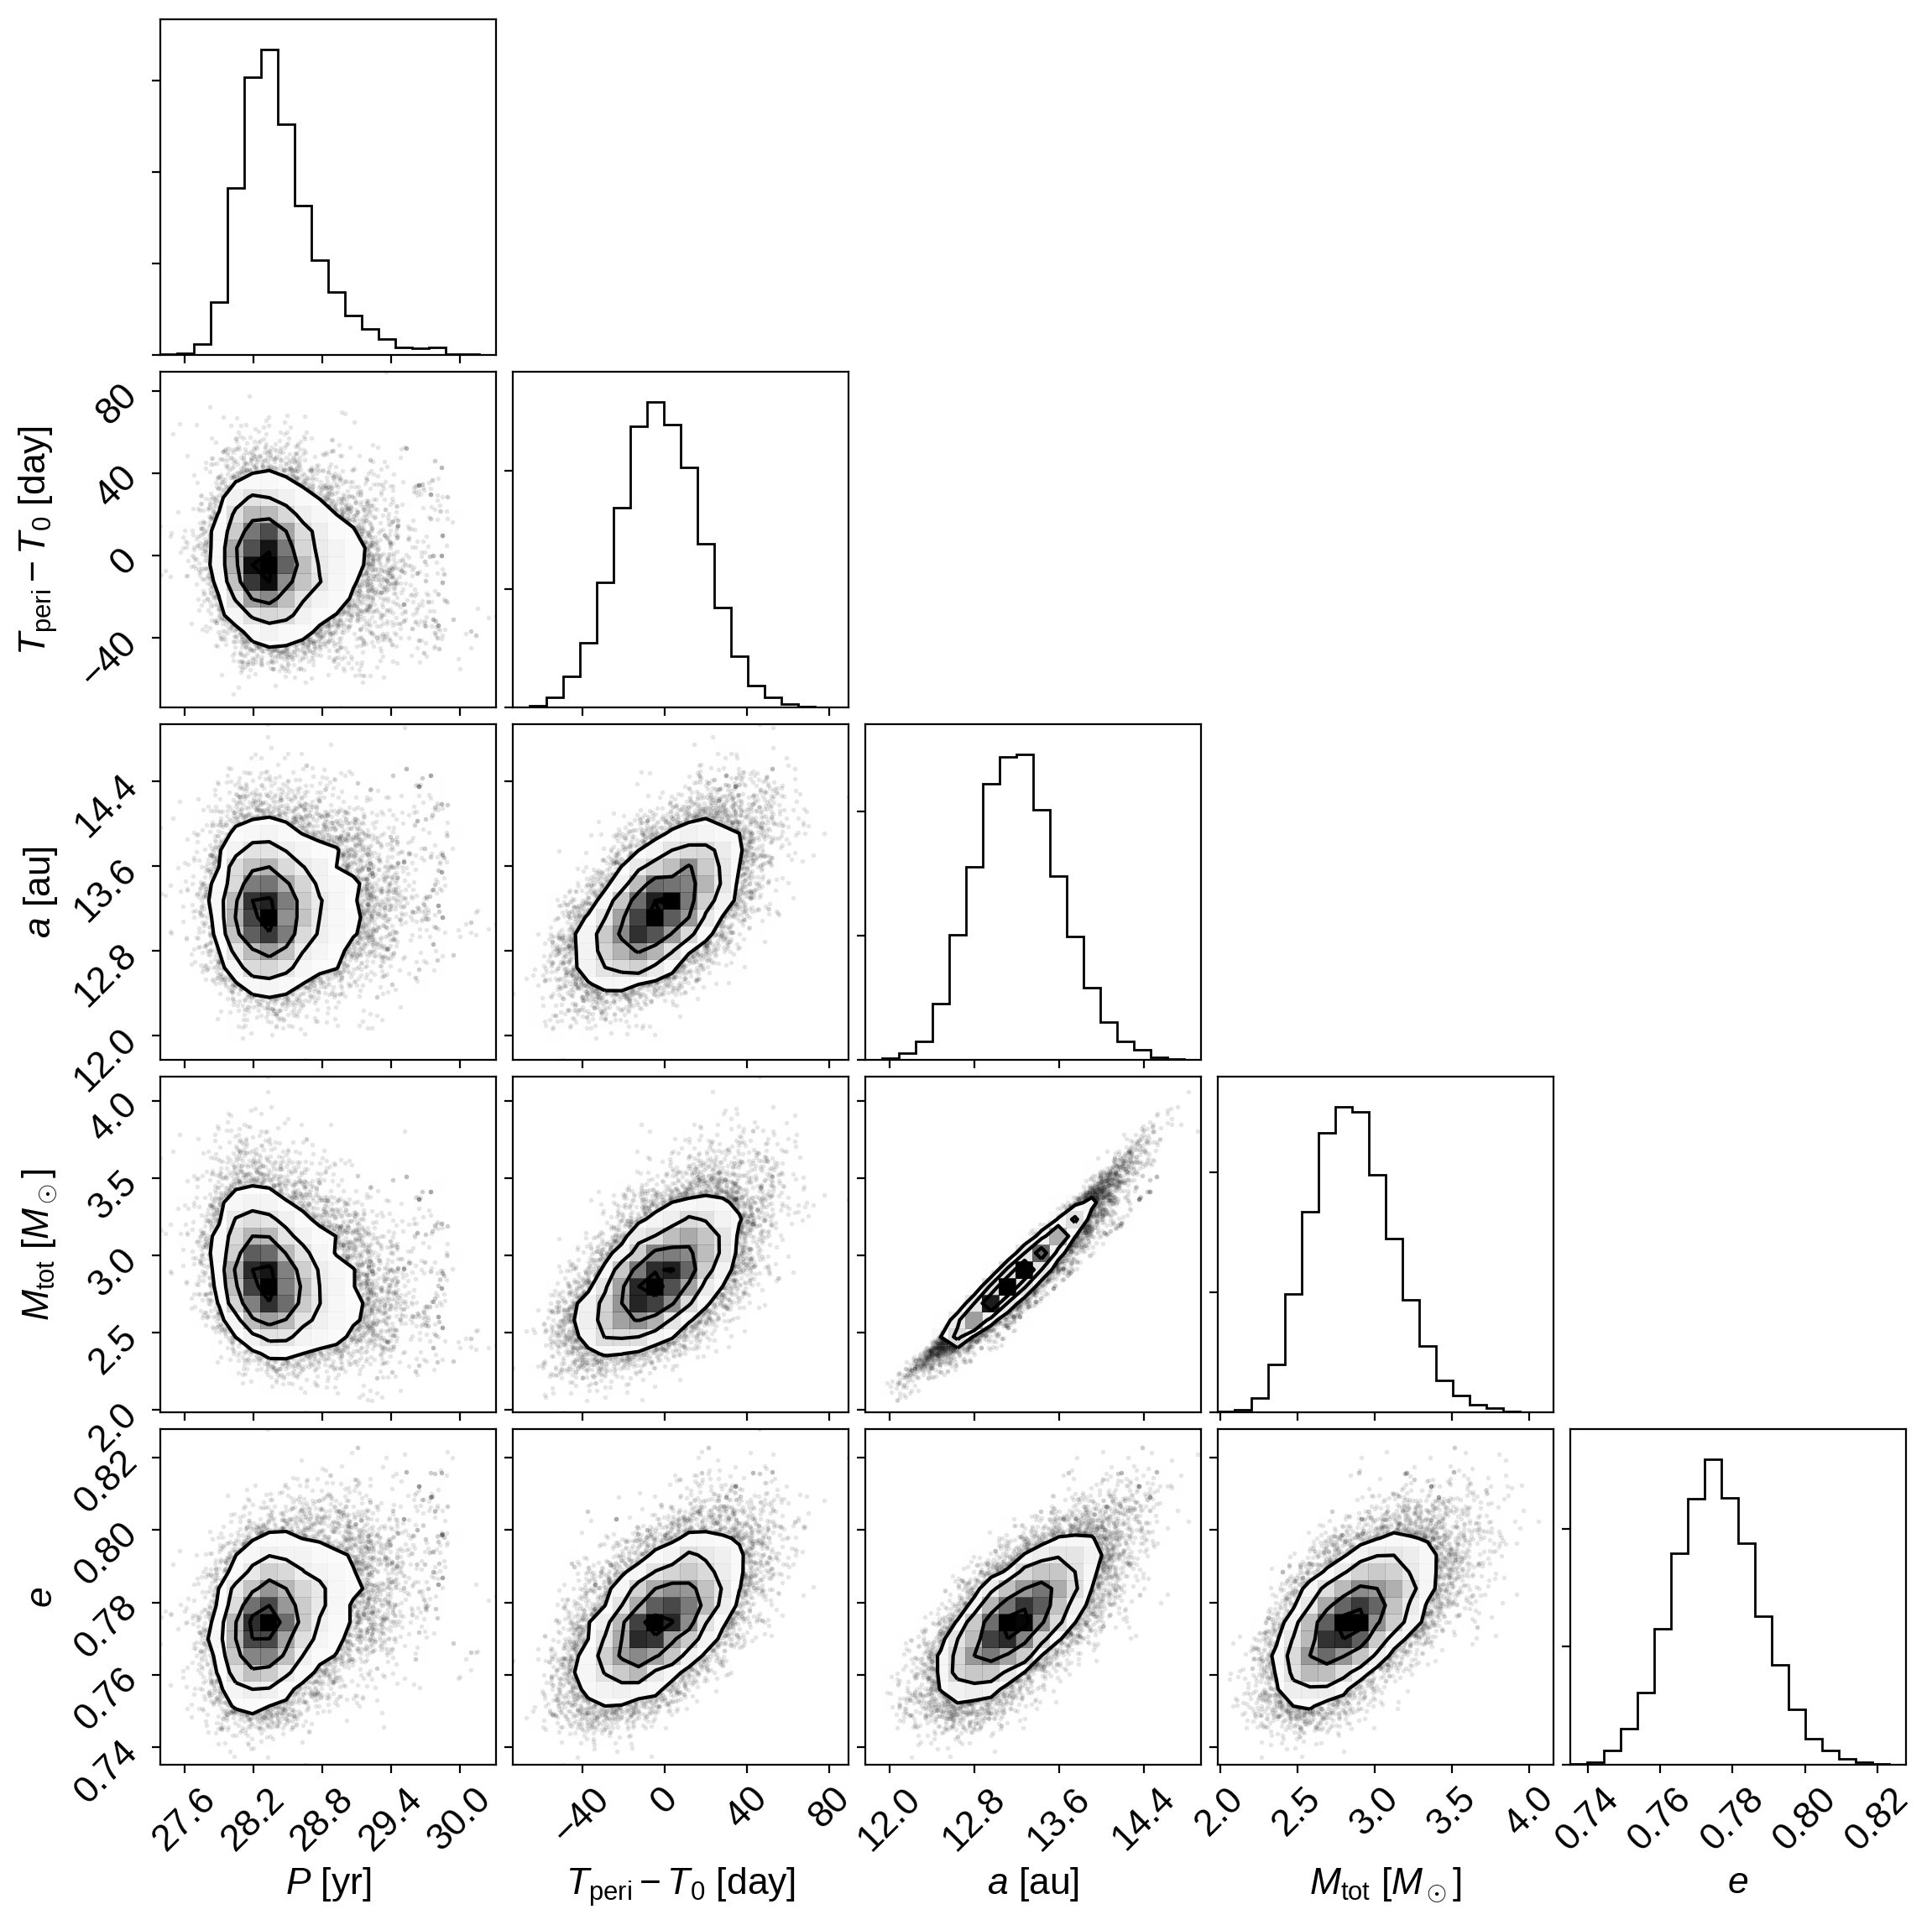

In [17]:
samples = pm.trace_to_dataframe(plx_trace, varnames=["ecc"])
samples["$P$ [yr]"] = plx_trace["P"] / yr
samples["$T_\mathrm{peri} - T_0$ [day]"] = plx_trace["tperi"] - T0
samples["$a$ [au]"] = plx_trace["a"]
samples["$M_\mathrm{tot}$ [$M_\odot$]"] = plx_trace["M_tot"]
samples["$e$"] = plx_trace["ecc"]
del samples["ecc"]
corner.corner(samples);

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [18]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:pymc3, exoplanet:theano}.


In [19]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.6},
   month = apr,
    year = 2019,
     doi = {10.5281/zenodo.2651251},
     url = {https://doi.org/10.5281/zenodo.2651251}
...
